In [13]:
#TFM UNIR BIG DATA


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from collections import Counter
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier 
from sklearn.svm import SVC
import warnings


import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install arch
from arch import arch_model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten


from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    Multiply, Permute, Lambda, Activation, Concatenate)
from tensorflow.keras import backend as K


In [5]:
df=pd.read_csv("/kaggle/input/dataset/preus_tancament_r.csv")

In [6]:
assets = ['AAPL', 'AMS', 'AMZN', 'BBVA', 'CABK', 'CLNX', 'FER', 'GOOGL', 'GSPC', 'IBE', 
 'IBEX', 'ITX', 'IXIC', 'JPM', 'LLY', 'META', 'MSFT', 'NVDA', 'SAN', 'TEF', 'TSLA']

# Inicialitzar DataFrame de treball
df_features = df
df_features['Date'] = pd.to_datetime(df['Date'])

In [7]:

# Per a cada actiu, generem les següents variables:
# - Retorn diari
# - Target (1 si retorn demà és positiu, 0 si no)
# - Lags (retards dels retorns)
# - Mitjana mòbil i desviació típica (rolling)


for asset in assets:
    close_col = f'{asset}.Close'
    volume_col = f'{asset}.Volume'

    if close_col in df.columns and volume_col in df.columns:
        # Retorn diari
        df_features[f'{asset}_return'] = df[close_col].pct_change()

        # Variable objectiu: retorn del dia següent
        df_features[f'{asset}_target'] = (df_features[f'{asset}_return'].shift(-1) > 0).astype(int)

        # Lags
        df_features[f'{asset}_lag1'] = df_features[f'{asset}_return'].shift(1)
        df_features[f'{asset}_lag2'] = df_features[f'{asset}_return'].shift(2)

        # Mitjana mòbil i desviació
        df_features[f'{asset}_ma5'] = df[close_col].rolling(5).mean()
        df_features[f'{asset}_std5'] = df[close_col].rolling(5).std()

        # Z-score del volum
        df_features[f'{asset}_volume_z'] = (
            (df[volume_col] - df[volume_col].rolling(20).mean()) /
            df[volume_col].rolling(20).std()
        )

## Eliminem només les files amb valors nuls a qualsevol columna creada
df_clean = df_features.dropna()

# Mostrem les dimensions resultants
print(f"Número total d'actius: {len(assets)}")
print(f"Dimensions del df_clean: {df_clean.shape}")

Número total d'actius: 21
Dimensions del df_clean: (2, 275)


In [8]:
df_clean_dict = {}
assets_valids = []

for asset in assets:
    relevant_cols = [f'{asset}_return', f'{asset}_target', f'{asset}_lag1',
                     f'{asset}_lag2', f'{asset}_ma5', f'{asset}_std5', f'{asset}_volume_z']

    if all(col in df_features.columns for col in relevant_cols):
        df_asset = df_features[relevant_cols].dropna()
        num_files_valides = len(df_asset)

        if num_files_valides >= 1900:
            df_clean_dict[asset] = df_asset
            assets_valids.append(asset)
            print(f"{asset}: {num_files_valides} files vàlides (✔)")
        else:
            print(f"{asset}: {num_files_valides} files vàlides (✘)")

AAPL: 1987 files vàlides (✔)
AMS: 1987 files vàlides (✔)
AMZN: 1987 files vàlides (✔)
BBVA: 1987 files vàlides (✔)
CABK: 211 files vàlides (✘)
CLNX: 2 files vàlides (✘)
FER: 1457 files vàlides (✘)
GOOGL: 1987 files vàlides (✔)
GSPC: 1987 files vàlides (✔)
IBE: 17 files vàlides (✘)
IBEX: 3227 files vàlides (✔)
ITX: 49 files vàlides (✘)
IXIC: 1987 files vàlides (✔)
JPM: 1987 files vàlides (✔)
LLY: 1987 files vàlides (✔)
META: 1667 files vàlides (✘)
MSFT: 1987 files vàlides (✔)
NVDA: 1987 files vàlides (✔)
SAN: 1987 files vàlides (✔)
TEF: 1987 files vàlides (✔)
TSLA: 1928 files vàlides (✔)


In [19]:

#Random Forest
warnings.filterwarnings("ignore")

# Definim el grid de paràmetres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# Validació creuada estratificada
cv = TimeSeriesSplit(n_splits=5)

results = []

for asset in assets_valids:
    df_asset = df_clean_dict[asset]
    X = df_asset.drop(columns=[f'{asset}_target'])
    y = df_asset[f'{asset}_target']

    # Divisió en train/test
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Grid search amb Random Forest
    clf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Millor model i prediccions
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Mètriques
    roc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'asset': asset,
        'roc_auc': roc,
        'accuracy': acc,
        'conf_matrix': cm,
        'best_params': grid.best_params_
    })

# Mostrem resultats
results_df_rf = pd.DataFrame(results)#.sort_values(by='roc_auc', ascending=False)
results_df_rf


asset   roc_auc  accuracy               conf_matrix  \
0    AAPL  0.470272  0.482412    [[118, 84], [122, 74]]   
1     AMS  0.600656  0.550251      [[216, 0], [179, 3]]   
2    AMZN  0.501137  0.484925    [[54, 148], [57, 139]]   
3    BBVA  0.511522  0.484925      [[187, 7], [198, 6]]   
4   GOOGL  0.530884  0.520101    [[46, 152], [39, 161]]   
5    GSPC  0.491249  0.492462    [[22, 179], [23, 174]]   
6    IBEX  0.458329  0.478328  [[166, 132], [205, 143]]   
7    IXIC  0.519646  0.510050    [[38, 162], [33, 165]]   
8     JPM  0.488475  0.479899   [[82, 106], [101, 109]]   
9     LLY  0.492112  0.482412      [[185, 7], [199, 7]]   
10   MSFT  0.471124  0.469849    [[120, 79], [132, 67]]   
11   NVDA  0.504940  0.517588    [[120, 74], [118, 86]]   
12    SAN  0.495325  0.512563    [[176, 28], [166, 28]]   
13    TEF  0.468901  0.502513    [[164, 57], [141, 36]]   
14   TSLA  0.513013  0.479275    [[52, 159], [42, 133]]   

                                          best_params  
0   {'max_depth': None, 'min_samples_split': 2, 'n...  
1   {'max_depth': 3, 'min_samples_split': 5, 'n_es...  
2   {'max_depth': 5, 'min_samples_split': 5, 'n_es...  
3   {'max_depth': 3, 'min_samples_split': 5, 'n_es...  
4   {'max_depth': 5, 'min_samples_split': 5, 'n_es...  
5   {'max_depth': 3, 'min_samples_split': 5, 'n_es...  
6   {'max_depth': None, 'min_samples_split': 2, 'n...  
7   {'max_depth': 5, 'min_samples_split': 10, 'n_e...  
8   {'max_depth': 10, 'min_samples_split': 10, 'n_...  
9   {'max_depth': 3, 'min_samples_split': 10, 'n_e...  
10  {'max_depth': None, 'min_samples_split': 2, 'n...  
11  {'max_depth': None, 'min_samples_split': 5, 'n...  
12  {'max_depth': 3, 'min_samples_split': 2, 'n_es...  
13  {'max_depth': 3, 'min_samples_split': 5, 'n_es...  
14  {'max_depth': 10, 'min_samples_split': 5, 'n_e...

In [12]:
# XGBOOST


results = []

# Paràmetres per fer grid search
param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

for asset in assets_valids:
    X_cols = [col for col in df_features.columns if col.startswith(asset) and col != f'{asset}_target']
    y_col = f'{asset}_target'

    df_model = df_features[X_cols + [y_col]].dropna()
    
    if len(df_model) < 1900:
        continue  # Saltar si no hi ha prou dades

    X = df_model[X_cols]
    y = df_model[y_col]

    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


    model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

    grid = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    roc_auc = roc_auc_score(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'asset': asset,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix.tolist(),
        'best_params': grid.best_params_
    })

# Convertir resultats a DataFrame
results_df_xgb = pd.DataFrame(results)
results_df_xgb.sort_values(by='roc_auc', ascending=False, inplace=True)
results_df_xgb.reset_index(drop=True, inplace=True)

results_df_xgb.head(10)



asset   roc_auc  accuracy             conf_matrix  \
0    AMS  0.589222  0.542714    [[215, 1], [181, 1]]   
1  GOOGL  0.543548  0.537688  [[66, 132], [52, 148]]   
2   BBVA  0.531067  0.532663  [[153, 41], [145, 59]]   
3   IXIC  0.520253  0.517588  [[77, 123], [69, 129]]   
4   TSLA  0.512146  0.510363  [[100, 111], [78, 97]]   
5   AMZN  0.500278  0.497487  [[91, 111], [89, 107]]   
6   MSFT  0.495480  0.497487  [[101, 98], [102, 97]]   
7    SAN  0.490954  0.505025  [[118, 86], [111, 83]]   
8    LLY  0.489495  0.492462  [[161, 31], [171, 35]]   
9   NVDA  0.476400  0.469849   [[96, 98], [113, 91]]   

                                         best_params  
0  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  
1  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  
2  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  
3  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  
4  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  
5  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  
6  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  
7  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  
8  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  
9  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...

In [13]:
#Regressión logistica

feature_suffixes = ["_lag1", "_lag2", "_ma5", "_std5", "_volume_z"]
results = []

for asset in assets_valids:
    feature_cols = [f"{asset}{suffix}" for suffix in feature_suffixes]
    target_col = f"{asset}_target"

    # Verifiquem que existeixin totes les columnes necessàries
    if all(col in df_features.columns for col in feature_cols + [target_col]):
        df_model = df_features[feature_cols + [target_col]].dropna()
        X = df_model[feature_cols]
        y = df_model[target_col]

        split_index = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        # Grid search amb regularització
        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']  # liblinear suporta l1 i l2
        }
        model = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='roc_auc')
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        roc_auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        best_params = model.best_params_

        results.append({
            "asset": asset,
            "roc_auc": roc_auc,
            "accuracy": accuracy,
            "conf_matrix": conf_matrix.tolist(),
            "best_params": best_params
        })

results_df_log = pd.DataFrame(results)
results_df_log.sort_values("roc_auc", ascending=False, inplace=True)
results_df_log.reset_index(drop=True, inplace=True)
results_df_log.head(10)


asset   roc_auc  accuracy             conf_matrix  \
0    JPM  0.576798  0.562814  [[106, 82], [92, 118]]   
1    TEF  0.535266  0.555276    [[217, 4], [173, 4]]   
2   BBVA  0.534933  0.487437    [[194, 0], [204, 0]]   
3    LLY  0.523665  0.522613  [[14, 178], [12, 194]]   
4   IXIC  0.520076  0.500000    [[9, 191], [8, 190]]   
5   GSPC  0.519736  0.494975    [[0, 201], [0, 197]]   
6   MSFT  0.518232  0.500000    [[0, 199], [0, 199]]   
7   NVDA  0.512634  0.512563    [[0, 194], [0, 204]]   
8  GOOGL  0.512336  0.502513    [[0, 198], [0, 200]]   
9    AMS  0.503103  0.542714    [[216, 0], [182, 0]]   

                                         best_params  
0   {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}  
1  {'C': 100, 'penalty': 'l1', 'solver': 'libline...  
2  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...  
3  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...  
4  {'C': 100, 'penalty': 'l1', 'solver': 'libline...  
5   {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}  
6  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...  
7  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...  
8  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...  
9  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...

In [14]:
# Ensemble de los 3 modelos (RF, XGB, LOG)



ensemble_results = []

for asset in assets_valids:
    X_cols = [col for col in df_features.columns if col.startswith(asset) and col != f'{asset}_target']
    y_col = f'{asset}_target'

    df_model = df_features[X_cols + [y_col]].dropna() 
   
    X = df_model[X_cols]
    y = df_model[y_col]

    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Models base
    rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    xgb = XGBClassifier(n_estimators=50, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
    logreg = LogisticRegression(max_iter=1000, random_state=42)

    # Stacking ensemble
    stack = StackingClassifier(
        estimators=[
            ('rf', rf),
            ('xgb', xgb),
            ('logreg', logreg)
        ],
        final_estimator=LogisticRegression(),
        passthrough=False,
        cv=5
    )

    # Entrenament
    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)
    y_proba = stack.predict_proba(X_test)[:, 1]

    # Mètriques
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    ensemble_results.append({
        'asset': asset,
        'roc_auc': roc,
        'accuracy': acc,
        'conf_matrix': cm.tolist()
    })

ensemble_results_df = pd.DataFrame(ensemble_results)
ensemble_results_df.sort_values(by='roc_auc', ascending=False, inplace=True)
ensemble_results_df.reset_index(drop=True, inplace=True)
ensemble_results_df.head()





asset   roc_auc  accuracy             conf_matrix
0    JPM  0.564488  0.515075  [[161, 27], [166, 44]]
1   NVDA  0.539393  0.535176  [[80, 114], [71, 133]]
2    TEF  0.537490  0.552764    [[220, 1], [177, 0]]
3   GSPC  0.523474  0.494975    [[0, 201], [0, 197]]
4  GOOGL  0.518535  0.512563  [[131, 67], [127, 73]]

In [16]:


nn_results = []

for asset in assets_valids:
    X_cols = [col for col in df_clean_dict[asset].columns if col != f'{asset}_target']
    y_col = f'{asset}_target'

    df_model = df_clean_dict[asset]

    X = df_model[X_cols].values
    y = df_model[y_col].values

    # Escalat
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Divisió en train/test
    split_index = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Model de xarxa neuronal
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenament
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    # Avaluació
    y_proba = model.predict(X_test).flatten()
    y_pred = (y_proba > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    nn_results.append({
        'asset': asset,
        'roc_auc': roc,
        'accuracy': acc,
        'conf_matrix': cm.tolist()
    })

# Resultats
nn_results_df = pd.DataFrame(nn_results)
nn_results_df.sort_values(by='roc_auc', ascending=False, inplace=True)
nn_results_df.reset_index(drop=True, inplace=True)
nn_results_df.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


asset   roc_auc  accuracy              conf_matrix
0    AMS  0.583893  0.547739     [[209, 7], [173, 9]]
1  GOOGL  0.566035  0.540201   [[43, 155], [28, 172]]
2    JPM  0.524240  0.535176  [[110, 78], [107, 103]]
3   BBVA  0.520012  0.469849   [[175, 19], [192, 12]]
4   AMZN  0.519044  0.507538   [[36, 166], [30, 166]]

In [16]:


lstm_results = []

sequence_length = 10  # n dies consecutius com a entrada

for asset in assets_valids:
    df = df_clean_dict[asset]
    
    X_cols = [col for col in df.columns if col != f'{asset}_target']
    y_col = f'{asset}_target'

    # Convertir a arrays
    X = df[X_cols].values
    y = df[y_col].values

    # Escalat
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Crear seqüències
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Dividir en train/test (80/20)
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Model LSTM
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenament
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    # Prediccions
    y_proba = model.predict(X_test).flatten()
    y_pred = (y_proba > 0.5).astype(int)

    # Mètriques
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    lstm_results.append({
        'asset': asset,
        'roc_auc': roc,
        'accuracy': acc,
        'conf_matrix': cm.tolist()
    })

# Resultats
lstm_results_df = pd.DataFrame(lstm_results)
lstm_results_df.sort_values(by='roc_auc', ascending=False, inplace=True)
lstm_results_df.reset_index(drop=True, inplace=True)
lstm_results_df.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


asset   roc_auc  accuracy             conf_matrix
0   TSLA  0.545270  0.570312  [[149, 62], [103, 70]]
1    LLY  0.535284  0.540404  [[36, 156], [26, 178]]
2  GOOGL  0.528276  0.510101  [[121, 76], [118, 81]]
3    JPM  0.507876  0.489899  [[91, 97], [105, 103]]
4   AMZN  0.501939  0.507576  [[80, 120], [75, 121]]

In [ ]:

#LSTM amb majos sequence_length
lstm_results_2 = []

sequence_length = 30  # n dies consecutius com a entrada

for asset in assets_valids:
    df = df_clean_dict[asset]
    
    X_cols = [col for col in df.columns if col != f'{asset}_target']
    y_col = f'{asset}_target'

    # Convertir a arrays
    X = df[X_cols].values
    y = df[y_col].values

    # Escalat
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Crear seqüències
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X_seq.append(X_scaled[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Dividir en train/test (80/20)
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Model LSTM
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrenament

    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Prediccions
    y_proba = model.predict(X_test).flatten()
    y_pred = (y_proba > 0.5).astype(int)

    # Mètriques
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    lstm_results_2.append({
        'asset': asset,
        'roc_auc': roc,
        'accuracy': acc,
        'conf_matrix': cm.tolist()
    })

# Resultats
lstm_results_2_df = pd.DataFrame(lstm_results_2)
lstm_results_2_df.sort_values(by='roc_auc', ascending=False, inplace=True)
lstm_results_2_df.reset_index(drop=True, inplace=True)
lstm_results_2_df.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step

In [ ]:

#LSTM+CNN+Attention layer
# Custom attention layer
def attention_layer(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    attention = Dense(1, activation='tanh')(inputs)                     # shape: (batch_size, time_steps, 1)
    attention = tf.keras.layers.Flatten()(attention)                   # shape: (batch_size, time_steps)
    attention = Activation('softmax')(attention)                       # softmax over time_steps
    attention = tf.keras.layers.RepeatVector(inputs.shape[2])(attention)  # (batch_size, input_dim, time_steps)
    attention = Permute([2, 1])(attention)                             # (batch_size, time_steps, input_dim)
    weighted = Multiply()([inputs, attention])                         # (batch_size, time_steps, input_dim)
    return Lambda(lambda x: K.sum(x, axis=1))(weighted)                # sum over time axis → (batch_size, input_dim)

# Input
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
inputs = Input(shape=input_shape)

# CNN + LSTM + Attention
x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.3)(x)

# Attention
x = attention_layer(x)  # Output: (batch_size, 64)

# Final Dense
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenament
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)


cnn_lstm_attention_results = []

# Prediccions
y_proba = model.predict(X_test).flatten()
y_pred = (y_proba > 0.5).astype(int)

# Mètriques
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

cnn_lstm_attention_results.append({
    'asset': asset,
    'roc_auc': roc,
    'accuracy': acc,
    'conf_matrix': cm.tolist()
})



In [ ]:
y_train.mean()

In [ ]:
## LSTM+ random forest

# -------------------------------
# 1. Defineix el model deep
# -------------------------------
def attention_layer(inputs):
    attention = Dense(1, activation='tanh')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[2])(attention)
    attention = Permute([2, 1])(attention)
    weighted = Multiply()([inputs, attention])
    return Lambda(lambda x: K.sum(x, axis=1))(weighted)

input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, num_features)
inputs = Input(shape=input_shape)

x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.3)(x)

x = attention_layer(x)
x = Dense(32, activation='relu', name='deep_features')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -------------------------------
# 2. Entrenament
# -------------------------------
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# -------------------------------
# 3. Extracció de deep features
# -------------------------------
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('deep_features').output)

X_train_feats = feature_extractor.predict(X_train)
X_test_feats = feature_extractor.predict(X_test)

# -------------------------------
# 4. Model clàssic (Random Forest)
# -------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feats, y_train)

y_pred = rf.predict(X_test_feats)
y_proba = rf.predict_proba(X_test_feats)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC:  {roc:.4f}")
print("Confusion matrix:")
print(cm)



--- Iniciant l'aplicació de models ARIMA i GARCH ---

--- Aplicant models per a l'actiu: AAPL ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398

Aplicant model ARIMA per a AAPL...
Resum del model ARIMA per a AAPL (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            AAPL_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4156.897', 'Date:                Sun, 15 Jun 2025   AIC                          -8305.794', 'Time:                        17:09:37   BIC                          -8284.311', 'Sample:                             0   HQIC                         -8297.814', '                               - 1589                                         ', 'Covariance Type:                  opg                                      

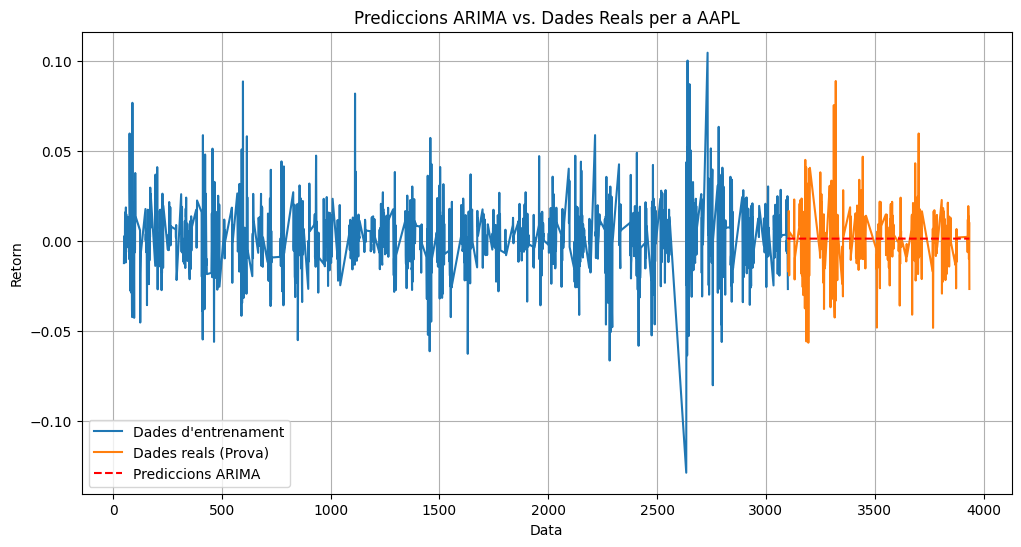


Aplicant model GARCH per a AAPL...
Resum del model GARCH per a AAPL (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  AAPL_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3325.66', "Distribution:      Standardized Student's t   AIC:                          -6641.32", 'Method:                  Maximum Likelihood   BIC:                          -6614.46', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:37   Df Model:                            1']
Error en aplicar el model GARCH

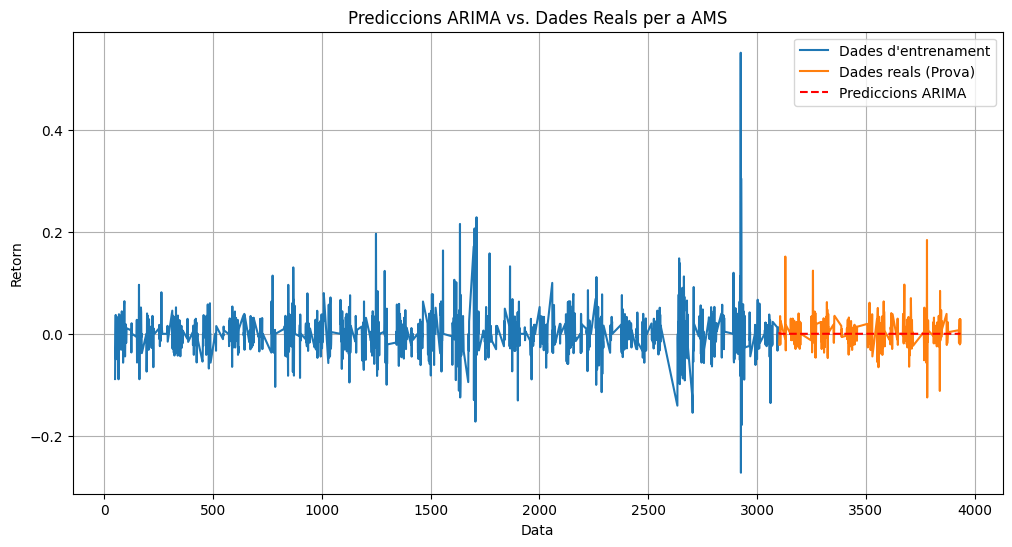


Aplicant model GARCH per a AMS...
Resum del model GARCH per a AMS (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   AMS_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                1936.95', "Distribution:      Standardized Student's t   AIC:                          -3863.91", 'Method:                  Maximum Likelihood   BIC:                          -3837.05', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:38   Df Model:                            1']
Error en aplicar el model GARCH p

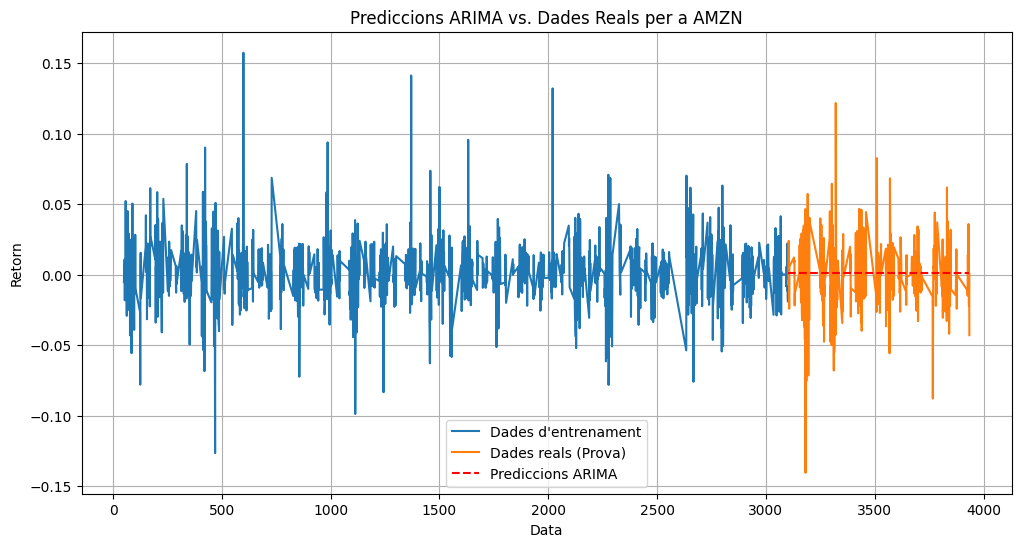


Aplicant model GARCH per a AMZN...
Resum del model GARCH per a AMZN (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  AMZN_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4163.65', "Distribution:      Standardized Student's t   AIC:                          -8317.30", 'Method:                  Maximum Likelihood   BIC:                          -8290.45', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:39   Df Model:                            1']
Error en aplicar el model GARCH

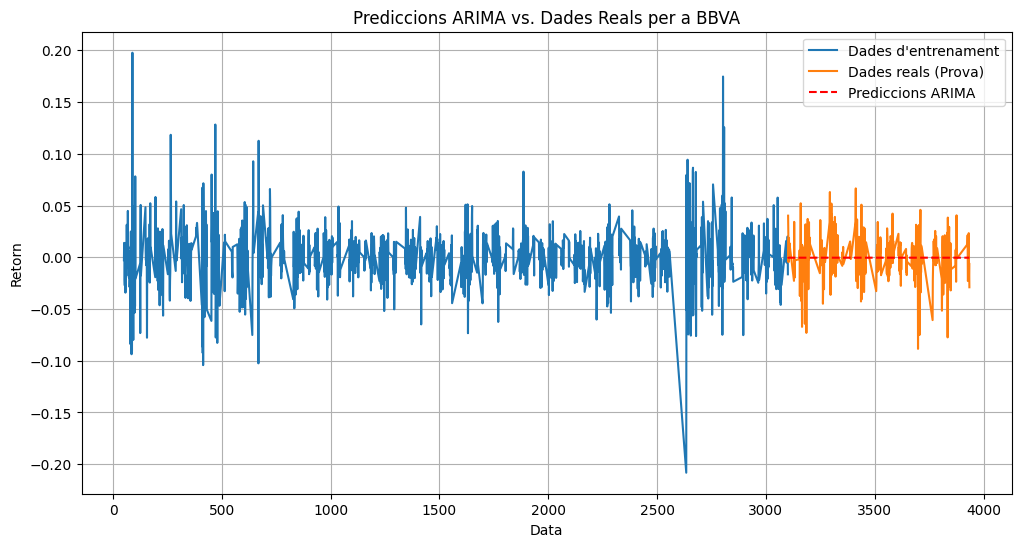


Aplicant model GARCH per a BBVA...
Resum del model GARCH per a BBVA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  BBVA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                2558.29', "Distribution:      Standardized Student's t   AIC:                          -5106.59", 'Method:                  Maximum Likelihood   BIC:                          -5079.74', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:40   Df Model:                            1']
Error en aplicar el model GARCH

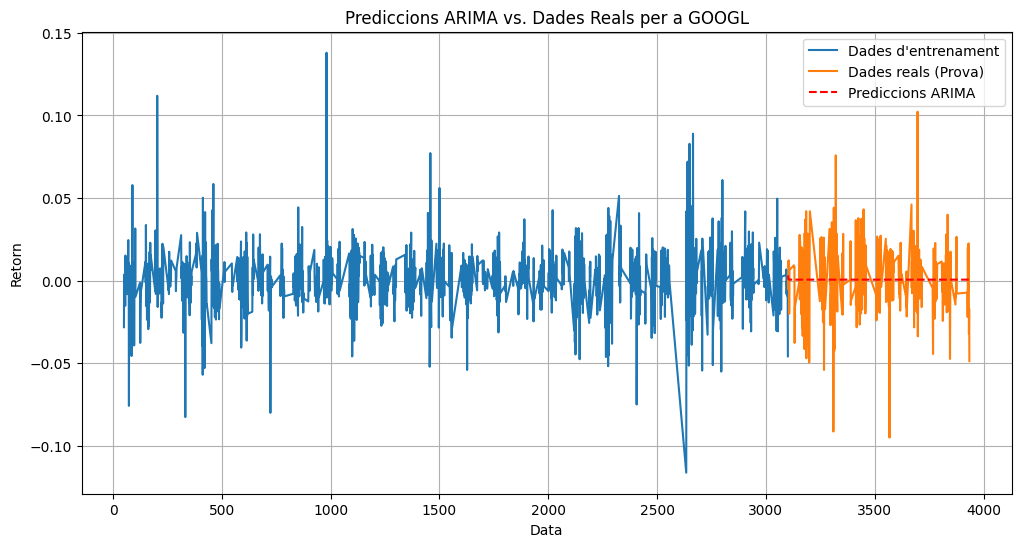


Aplicant model GARCH per a GOOGL...
Resum del model GARCH per a GOOGL (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                 GOOGL_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                922.318', "Distribution:      Standardized Student's t   AIC:                          -1834.64", 'Method:                  Maximum Likelihood   BIC:                          -1807.78', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:41   Df Model:                            1']
Error en aplicar el model GAR

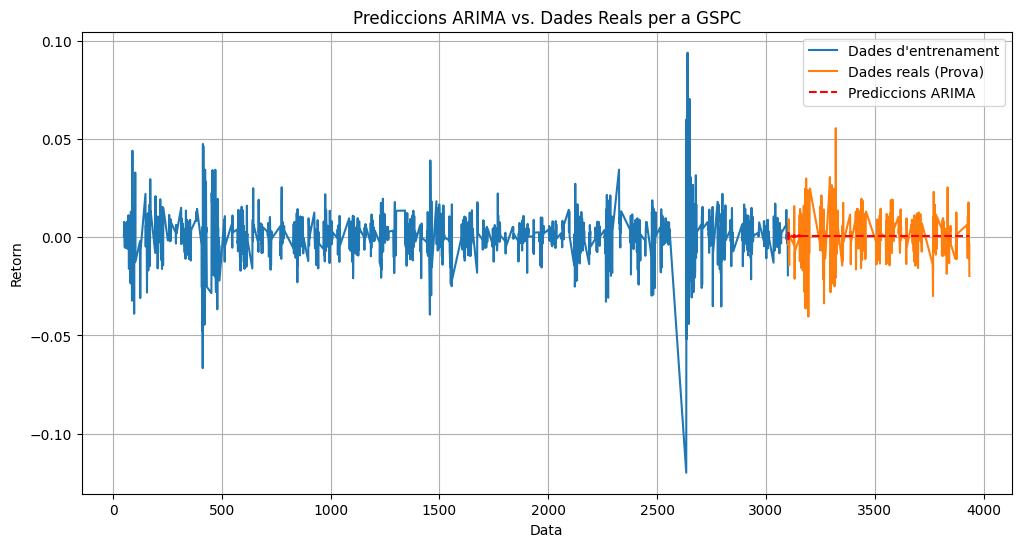


Aplicant model GARCH per a GSPC...
Resum del model GARCH per a GSPC (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  GSPC_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3825.58', "Distribution:      Standardized Student's t   AIC:                          -7641.16", 'Method:                  Maximum Likelihood   BIC:                          -7614.31', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:42   Df Model:                            1']
Error en aplicar el model GARCH

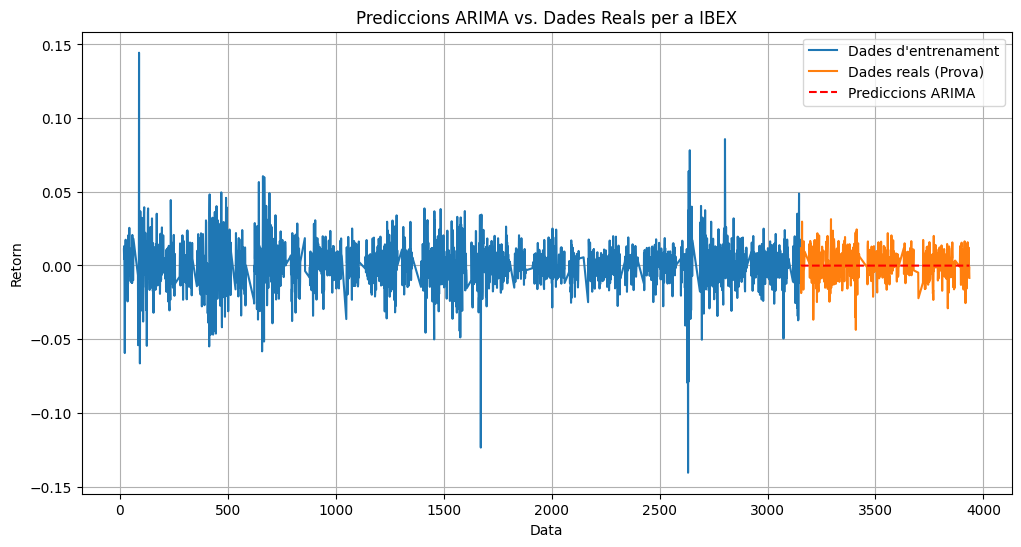


Aplicant model GARCH per a IBEX...
Resum del model GARCH per a IBEX (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  IBEX_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                5234.22', "Distribution:      Standardized Student's t   AIC:                          -10458.4", 'Method:                  Maximum Likelihood   BIC:                          -10429.2', '                                              No. Observations:                 2581', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     2580', 'Time:                              17:09:43   Df Model:                            1']
Error en aplicar el model GARCH

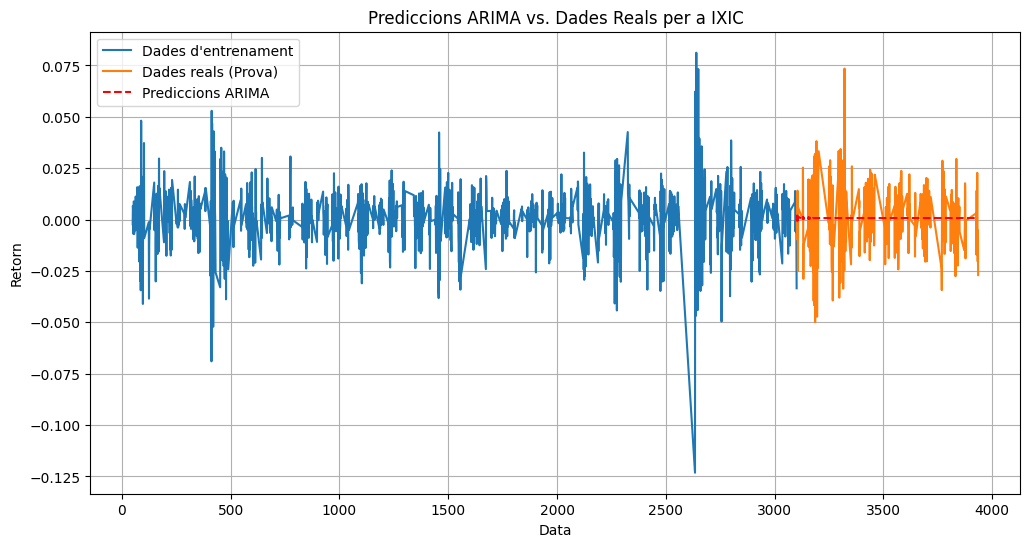


Aplicant model GARCH per a IXIC...
Resum del model GARCH per a IXIC (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  IXIC_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3822.46', "Distribution:      Standardized Student's t   AIC:                          -7634.93", 'Method:                  Maximum Likelihood   BIC:                          -7608.07', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:44   Df Model:                            1']
Error en aplicar el model GARCH

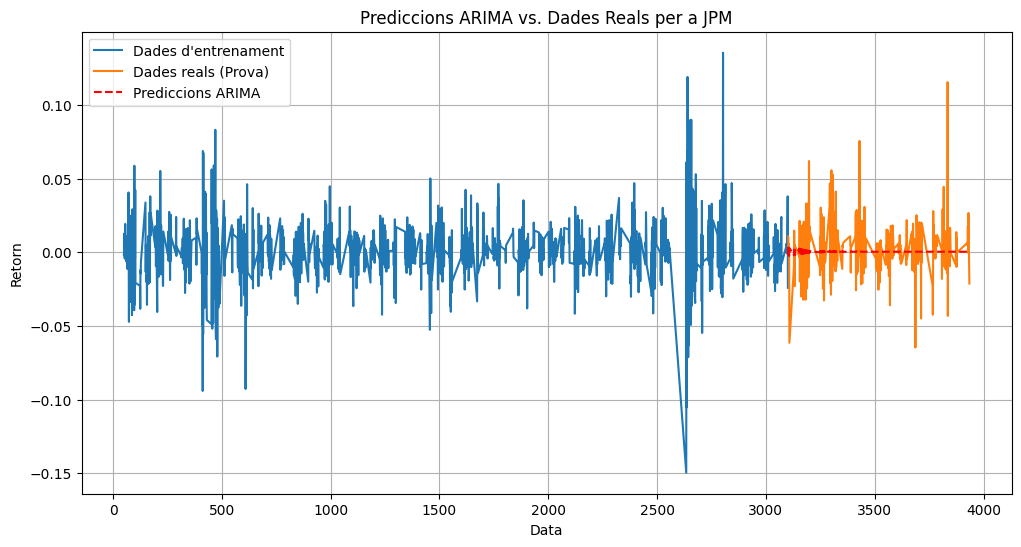


Aplicant model GARCH per a JPM...
Resum del model GARCH per a JPM (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   JPM_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3179.83', "Distribution:      Standardized Student's t   AIC:                          -6349.67", 'Method:                  Maximum Likelihood   BIC:                          -6322.81', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:45   Df Model:                            1']
Error en aplicar el model GARCH p

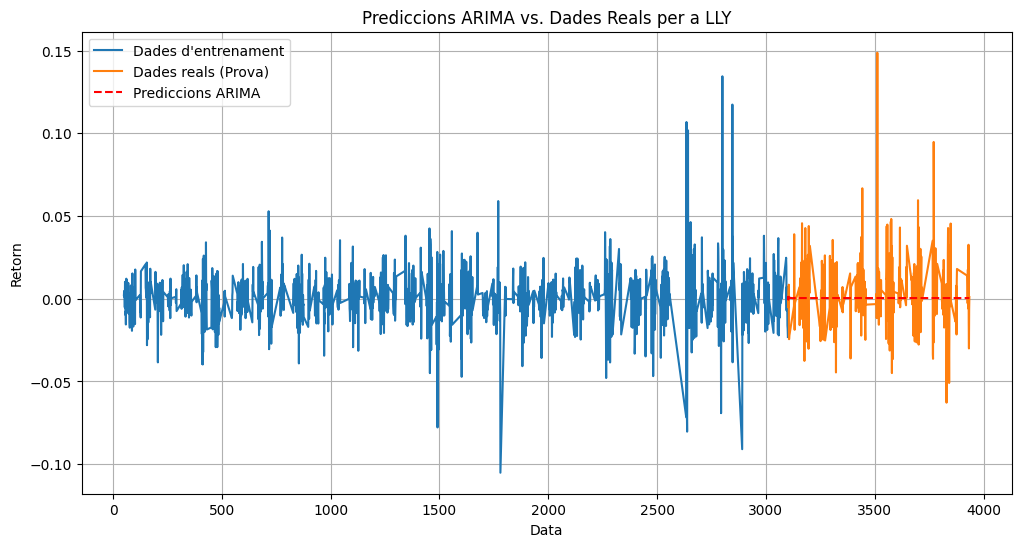


Aplicant model GARCH per a LLY...
Resum del model GARCH per a LLY (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   LLY_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4709.53', "Distribution:      Standardized Student's t   AIC:                          -9409.06", 'Method:                  Maximum Likelihood   BIC:                          -9382.21', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:47   Df Model:                            1']
Error en aplicar el model GARCH p

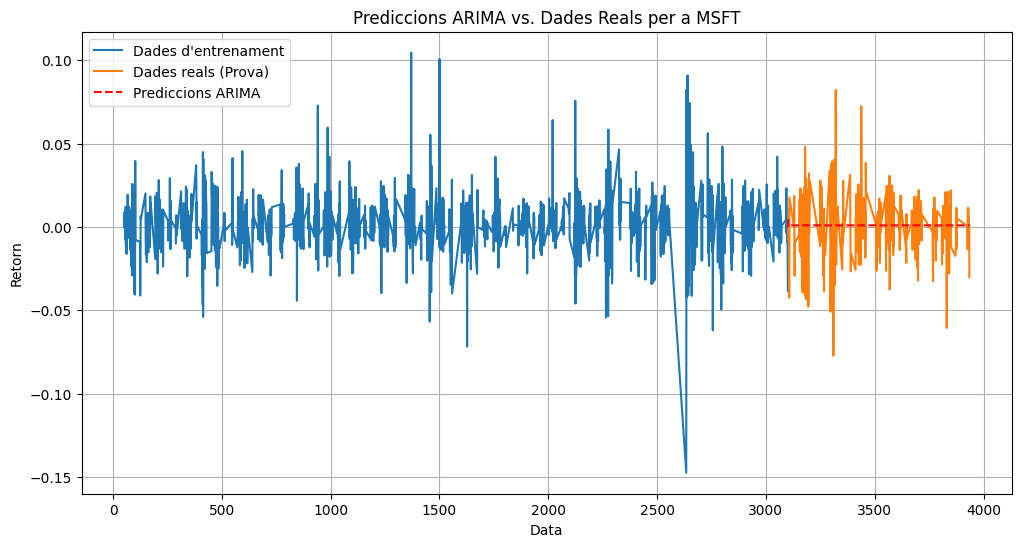


Aplicant model GARCH per a MSFT...
Resum del model GARCH per a MSFT (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  MSFT_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4580.36', "Distribution:      Standardized Student's t   AIC:                          -9150.73", 'Method:                  Maximum Likelihood   BIC:                          -9123.87', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:48   Df Model:                            1']
Error en aplicar el model GARCH

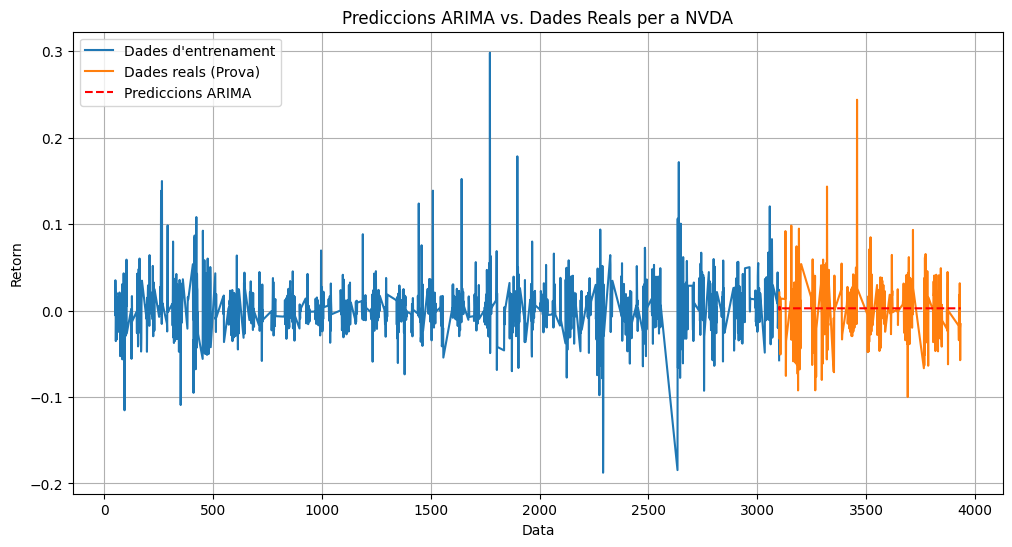


Aplicant model GARCH per a NVDA...
Resum del model GARCH per a NVDA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  NVDA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3327.43', "Distribution:      Standardized Student's t   AIC:                          -6644.86", 'Method:                  Maximum Likelihood   BIC:                          -6618.00', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:49   Df Model:                            1']
Error en aplicar el model GARCH

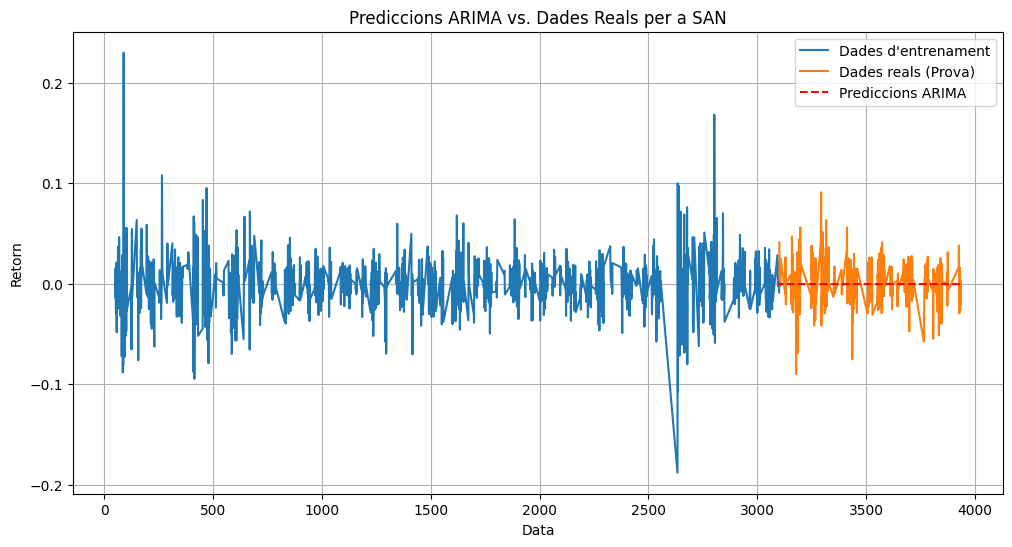


Aplicant model GARCH per a SAN...
Resum del model GARCH per a SAN (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   SAN_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                2607.39', "Distribution:      Standardized Student's t   AIC:                          -5204.79", 'Method:                  Maximum Likelihood   BIC:                          -5177.93', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:51   Df Model:                            1']
Error en aplicar el model GARCH p

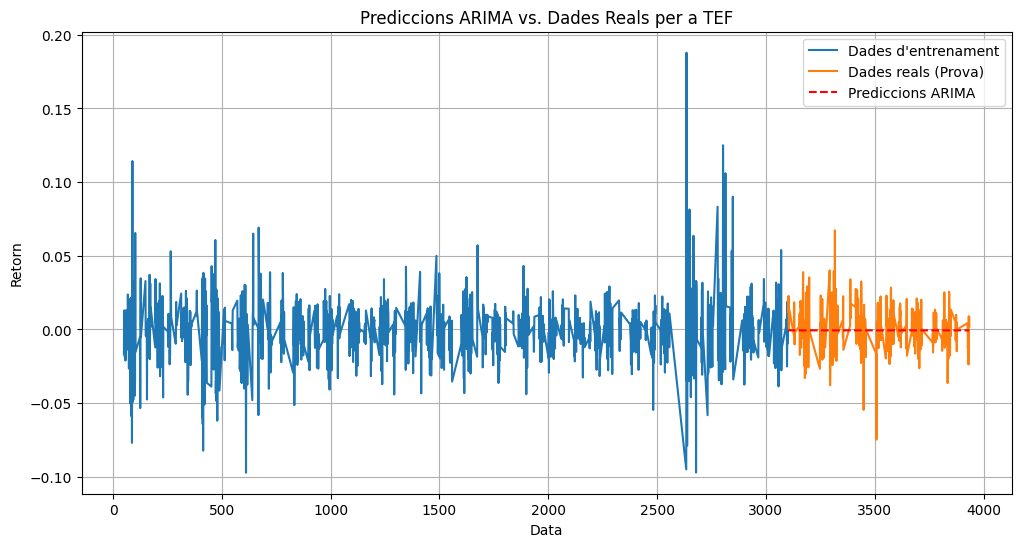


Aplicant model GARCH per a TEF...
Resum del model GARCH per a TEF (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   TEF_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4303.12', "Distribution:      Standardized Student's t   AIC:                          -8596.23", 'Method:                  Maximum Likelihood   BIC:                          -8569.38', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:09:51   Df Model:                            1']
Error en aplicar el model GARCH p

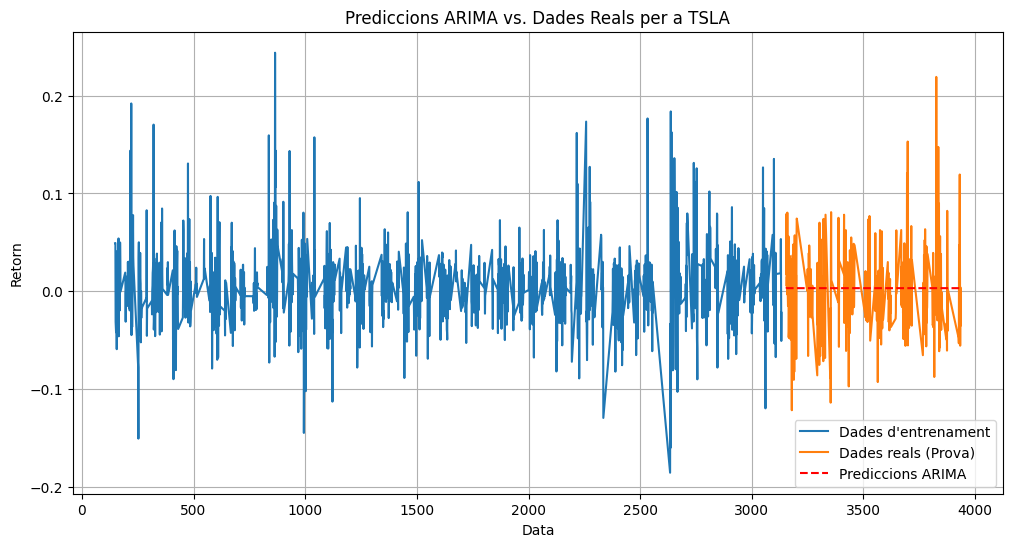


Aplicant model GARCH per a TSLA...
Resum del model GARCH per a TSLA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  TSLA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:               -1832.20', "Distribution:      Standardized Student's t   AIC:                           3674.40", 'Method:                  Maximum Likelihood   BIC:                           3701.10', '                                              No. Observations:                 1542', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1541', 'Time:                              17:09:52   Df Model:                            1']
Error en aplicar el model GARCH

In [36]:

# Per suprimir advertiments, especialment de la convergència dels models
warnings.filterwarnings("ignore")

print("\n--- Iniciant l'aplicació de models ARIMA i GARCH ---")

# --- SUPOSICIONS CLAU ---
# df_clean_dict: Un diccionari on les claus són els noms dels actius
#              i els valors són DataFrames que contenen la columna '{asset}_return'.
# assets_valids: Una llista de noms d'actius que vols processar.



if not df_clean_dict or not assets_valids:
    print("Error: df_clean_dict o assets_valids no estan definits o estan buits.")
    print("Assegura't que les cel·les anteriors del notebook s'han executat correctament.")
else:
    for asset in assets_valids:
        print(f"\n--- Aplicant models per a l'actiu: {asset} ---")

        # Seleccionem la sèrie de retorns de l'actiu
        returns_col_name = f'{asset}_return'
        if returns_col_name not in df_clean_dict[asset].columns:
            print(f"Error: La columna '{returns_col_name}' no es troba per a l'actiu {asset}. Saltant.")
            continue

        returns = df_clean_dict[asset][returns_col_name]

        # Dividim les dades en entrenament i prova (80% entrenament, 20% prova)
        train_size = int(len(returns) * 0.8)
        train_data, test_data = returns[0:train_size], returns[train_size:]

        # Hauríem de verificar que el test_data no estigui buit
        if len(test_data) == 0:
            print(f"AVÍS: El conjunt de prova per a {asset} està buit. Saltant l'avaluació d'aquest actiu.")
            continue

        print(f"Grandària de les dades d'entrenament: {len(train_data)}")
        print(f"Grandària de les dades de prova: {len(test_data)}")

        # Inicialitzem les prediccions a None per gestionar errors
        arima_predictions_continuous = None
        garch_conditional_volatility = None # Per a GARCH, prediem volatilitat

        # ----------------------------------------------------
        # Model ARIMA
        # ----------------------------------------------------
        print(f"\nAplicant model ARIMA per a {asset}...")
        try:
            arima_model = ARIMA(train_data, order=(1, 0, 1))
            arima_results = arima_model.fit()
            print(f"Resum del model ARIMA per a {asset} (primeres línies):\n{arima_results.summary().as_text().splitlines()[0:10]}") # Limitem el summary

            # --- CORRECCIÓ CLAU PER ARIMA: Predicció per al període de test ---
            # Utilitzem `get_forecast` per obtenir prediccions futures.
            # `steps` és el nombre de prediccions, que és la longitud del test_data
            arima_forecast_obj = arima_results.get_forecast(steps=len(test_data))
            arima_predictions_continuous = arima_forecast_obj.predicted_mean
            arima_predictions_continuous.index = test_data.index # Assegurem l'índex per al gràfic i RMSE

            # Calcul del RMSE
            rmse_arima = np.sqrt(np.mean((arima_predictions_continuous - test_data)**2))
            print(f"RMSE (ARIMA) per a {asset}: {rmse_arima:.4f}")

            # Visualització de les prediccions ARIMA
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data, label='Dades d\'entrenament')
            plt.plot(test_data.index, test_data, label='Dades reals (Prova)')
            # Plot només si les prediccions tenen dades
            if not arima_predictions_continuous.empty:
                plt.plot(arima_predictions_continuous.index, arima_predictions_continuous, label='Prediccions ARIMA', color='red', linestyle='--')
            else:
                print(f"AVÍS: No hi ha prediccions ARIMA per graficar per a {asset}.")
            plt.title(f'Prediccions ARIMA vs. Dades Reals per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model ARIMA per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}")

        # ----------------------------------------------------
        # Model GARCH
        # ----------------------------------------------------
        print(f"\nAplicant model GARCH per a {asset}...")
        try:
            # Per a GARCH, s'utilitzen normalment retorns no escalats o escalats per 100 si són molt petits
            # Utilitzem .loc[train_data.index] per evitar FutureWarnings i assegurar que és una sèrie
            garch_model = arch_model(train_data.loc[train_data.index], vol='Garch', p=1, q=1, dist='StudentsT')
            garch_results = garch_model.fit(disp='off')
            print(f"Resum del model GARCH per a {asset} (primeres línies):\n{garch_results.summary().as_text().splitlines()[0:10]}") # Limitem el summary

            # --- CORRECCIÓ CLAU PER GARCH: Predicció de la volatilitat per al període de test ---
            # `horizon` és el nombre de passos a predir, que és la longitud del conjunt de prova.
            # `last_obs` per aliniar el forecast amb la darrera observació d'entrenament.
            forecasts = garch_results.forecast(horizon=len(test_data), last_obs=train_data.index[-1], reindex=False)
            
            # La predicció de la variància condicional és el que ens interessa per GARCH
            # forecasts.variance.iloc[-1].values conté les prediccions de variància per al mateix horitzó
            garch_conditional_volatility = pd.Series(np.sqrt(forecasts.variance.iloc[-1].values), index=test_data.index)

            # Visualització de la volatilitat predita pel GARCH (mantingut del teu codi original)
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data**2, label='Retorns al Quadrat (Train)') # Proxy de volatilitat real
            plt.plot(test_data.index, test_data**2, label='Retorns al Quadrat (Test)') # Proxy de volatilitat real
            if not garch_conditional_volatility.empty:
                plt.plot(garch_conditional_volatility.index, garch_conditional_volatility, label='Volatilitat Condicional GARCH', color='red', linestyle='--')
            else:
                print(f"AVÍS: No hi ha prediccions de volatilitat GARCH per graficar per a {asset}.")
            plt.title(f'Volatilitat Condicional GARCH per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn^2 / Volatilitat Condicional')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model GARCH per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}")

print("\n--- Finalitzada l'aplicació de models ARIMA i GARCH ---")


--- Iniciant l'aplicació de models ARIMA i GARCH ---

--- Aplicant models per a l'actiu: AAPL ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398

Aplicant model ARIMA per a AAPL...
Resum del model ARIMA per a AAPL:
                               SARIMAX Results                                
Dep. Variable:            AAPL_return   No. Observations:                 1589
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4156.897
Date:                Sun, 15 Jun 2025   AIC                          -8305.794
Time:                        17:06:38   BIC                          -8284.311
Sample:                             0   HQIC                         -8297.814
                               - 1589                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

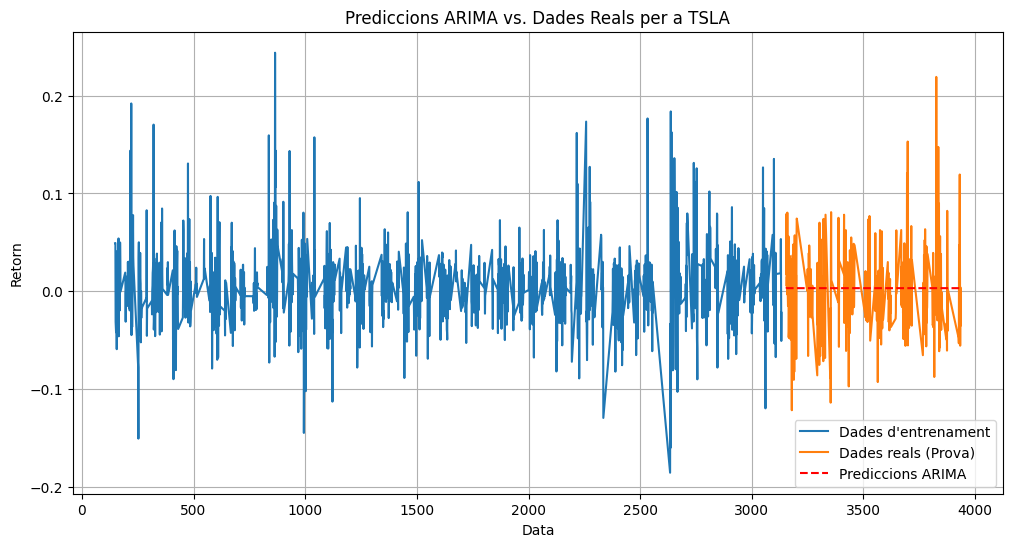


Aplicant model GARCH per a TSLA...
Resum del model GARCH per a TSLA:
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  TSLA_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1832.20
Distribution:      Standardized Student's t   AIC:                           3674.40
Method:                  Maximum Likelihood   BIC:                           3701.10
                                              No. Observations:                 1542
Date:                      Sun, Jun 15 2025   Df Residuals:                     1541
Time:                              17:06:50   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------

In [35]:

#NO BINARITZA mal grafic
# Per suprimir advertiments, especialment de la convergència dels models
warnings.filterwarnings("ignore")

print("\n--- Iniciant l'aplicació de models ARIMA i GARCH ---")

if not df_clean_dict or not assets_valids:
    print("Error: df_clean_dict o assets_valids no estan definits o estan buits.")
    print("Assegura't que les cel·les anteriors del notebook s'han executat correctament.")
else:
    for asset in assets_valids:
        print(f"\n--- Aplicant models per a l'actiu: {asset} ---")

        # Seleccionem la sèrie de retorns de l'actiu
        # La columna de retorns hauria de tenir el format '{asset}_return'
        returns_col_name = f'{asset}_return'
        if returns_col_name not in df_clean_dict[asset].columns:
            print(f"Error: La columna '{returns_col_name}' no es troba per a l'actiu {asset}. Saltant.")
            continue

        returns = df_clean_dict[asset][returns_col_name]

        # Dividim les dades en entrenament i prova (80% entrenament, 20% prova)
        train_size = int(len(returns) * 0.8)
        train_data, test_data = returns[0:train_size], returns[train_size:]

        print(f"Grandària de les dades d'entrenament: {len(train_data)}")
        print(f"Grandària de les dades de prova: {len(test_data)}")

        # ----------------------------------------------------
        # Model ARIMA
        # ----------------------------------------------------
        print(f"\nAplicant model ARIMA per a {asset}...")

        # Opcional: Visualitzar ACF i PACF per a l'entrenament per ajudar a la selecció de l'ordre
        # Descomenta les línies següents si vols veure els gràfics
        # fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        # plot_acf(train_data, ax=axes[0], lags=40)
        # plot_pacf(train_data, ax=axes[1], lags=40)
        # plt.suptitle(f'ACF and PACF for {asset} Returns (Training Data)')
        # plt.show()

        try:
            # Entrenem el model ARIMA. p=1, d=0, q=1 és un bon punt de partida per a retorns.
            # `d=0` perquè els retorns ja solen ser estacionaris.
            arima_model = ARIMA(train_data, order=(1, 0, 1))
            arima_results = arima_model.fit()
            print(f"Resum del model ARIMA per a {asset}:\n{arima_results.summary()}")

            # Realitzem prediccions en el conjunt de prova
            # `start` i `end` es basen en els índexs del conjunt original de dades
            start_index = len(train_data)
            end_index = len(returns) - 1
            arima_predictions = arima_results.predict(start=start_index, end=end_index, dynamic=False)
            

            # Avaluació simple del model ARIMA
            rmse_arima = np.sqrt(np.mean((arima_predictions - test_data)**2))
            print(f"RMSE (ARIMA) per a {asset}: {rmse_arima:.4f}")

            # Visualització de les prediccions ARIMA
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data, label='Dades d\'entrenament')
            plt.plot(test_data.index, test_data, label='Dades reals (Prova)')
            plt.plot(arima_predictions.index, arima_predictions, label='Prediccions ARIMA', color='red', linestyle='--')
            plt.title(f'Prediccions ARIMA vs. Dades Reals per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model ARIMA per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}") # Per obtenir més detalls si hi ha errors de convergència

        # ----------------------------------------------------
        # Model GARCH
        # ----------------------------------------------------
        print(f"\nAplicant model GARCH per a {asset}...")

        try:
            # Entrenem el model GARCH(1,1) amb distribució Students's t per captures cues pesades
            # `vol='Garch'` indica que volem un model GARCH
            # `p=1`, `q=1` són els ordres
            # `dist='StudentsT'` és una bona opció per retorns financers
            garch_model = arch_model(train_data, vol='Garch', p=1, q=1, dist='StudentsT')
            # `disp='off'` suprimeix la sortida del procés d'optimització
            garch_results = garch_model.fit(disp='off')
            print(f"Resum del model GARCH per a {asset}:\n{garch_results.summary()}")

            # Predicció de la volatilitat (desviació estàndard condicional)
            # El `forecast` de GARCH prediu la variància/volatilitat futura.
            # `horizon` és el nombre de passos a predir, que correspon al tamany del conjunt de prova.
            # `start` hauria de ser l'última data del conjunt d'entrenament.
            forecasts = garch_results.forecast(horizon=len(test_data), start=train_data.index[-1], reindex=False)
            
            # La predicció de la variància condicional està sota 'variance'
            # 'h.1' correspon a la predicció a 1 pas (la més immediata)
            # Agafem la primera fila de les prediccions, que són les futures.
            # Important: Ens assegurem que l'índex de les prediccions coincideix amb el de test_data.
            garch_conditional_volatility = np.sqrt(forecasts.variance.dropna().iloc[0])
            garch_conditional_volatility.index = test_data.index[:len(garch_conditional_volatility)] # Ajustem l'índex

            # Visualització de la volatilitat predita pel GARCH
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data**2, label='Retorns al Quadrat (Train)') # Proxy de volatilitat real
            plt.plot(test_data.index, test_data**2, label='Retorns al Quadrat (Test)') # Proxy de volatilitat real
            plt.plot(garch_conditional_volatility.index, garch_conditional_volatility, label='Volatilitat Condicional GARCH', color='red', linestyle='--')
            plt.title(f'Volatilitat Condicional GARCH per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn^2 / Volatilitat Condicional')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model GARCH per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}")

print("\n--- Finalitzada l'aplicació de models ARIMA i GARCH ---")

In [27]:
start_index,end_index

(1542, 1927)

In [31]:
len(train_data),len(test_data),len(returns)

(1542, 386, 1928)


--- Iniciant l'aplicació de models ARIMA i GARCH ---

--- Aplicant models per a l'actiu: AAPL ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a AAPL...
Resum del model ARIMA per a AAPL (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            AAPL_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4156.897', 'Date:                Sun, 15 Jun 2025   AIC                          -8305.794', 'Time:                        17:03:01   BIC                          -8284.311', 'Sample:                             0   HQIC                         -8297.814', '                               - 1589                                         ', 'Covariance Type:               

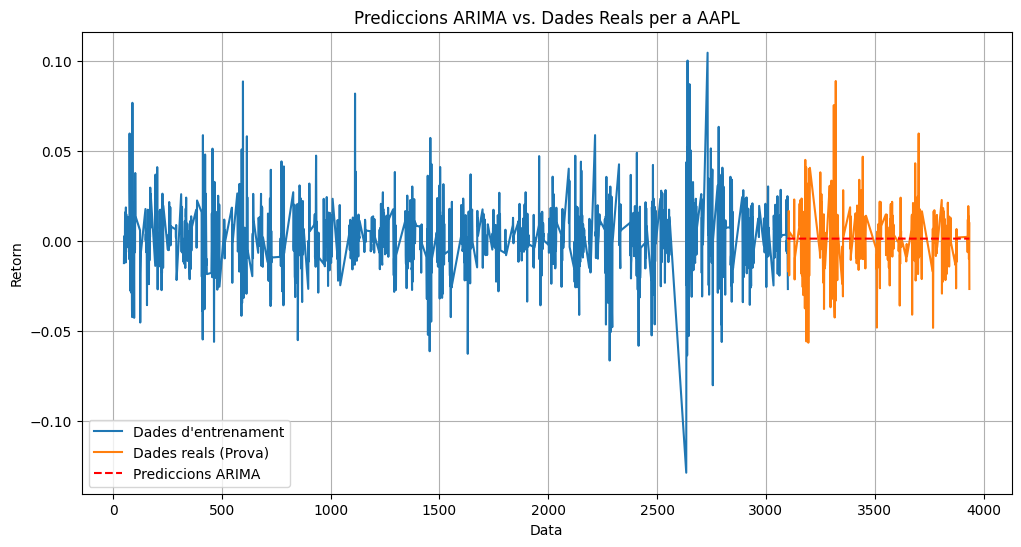


Aplicant model GARCH per a AAPL...
Resum del model GARCH per a AAPL (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  AAPL_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3325.66', "Distribution:      Standardized Student's t   AIC:                          -6641.32", 'Method:                  Maximum Likelihood   BIC:                          -6614.46', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:01   Df Model:                            1']


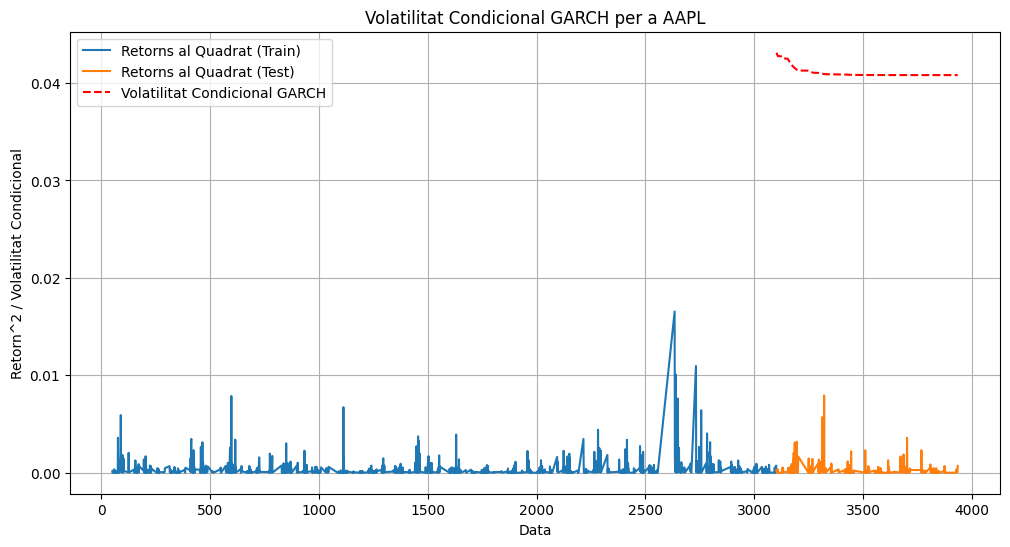


--- Avaluació de la Predicció de Direcció per a AAPL ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4925
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.49      1.00      0.66       196

    accuracy                           0.49       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.24      0.49      0.32       398


GARCH (Binaritzat) - Accuracy: 0.4925
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.49      1.00      0.66       196

    accuracy                           0.49       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.24      0.49      0.32       398



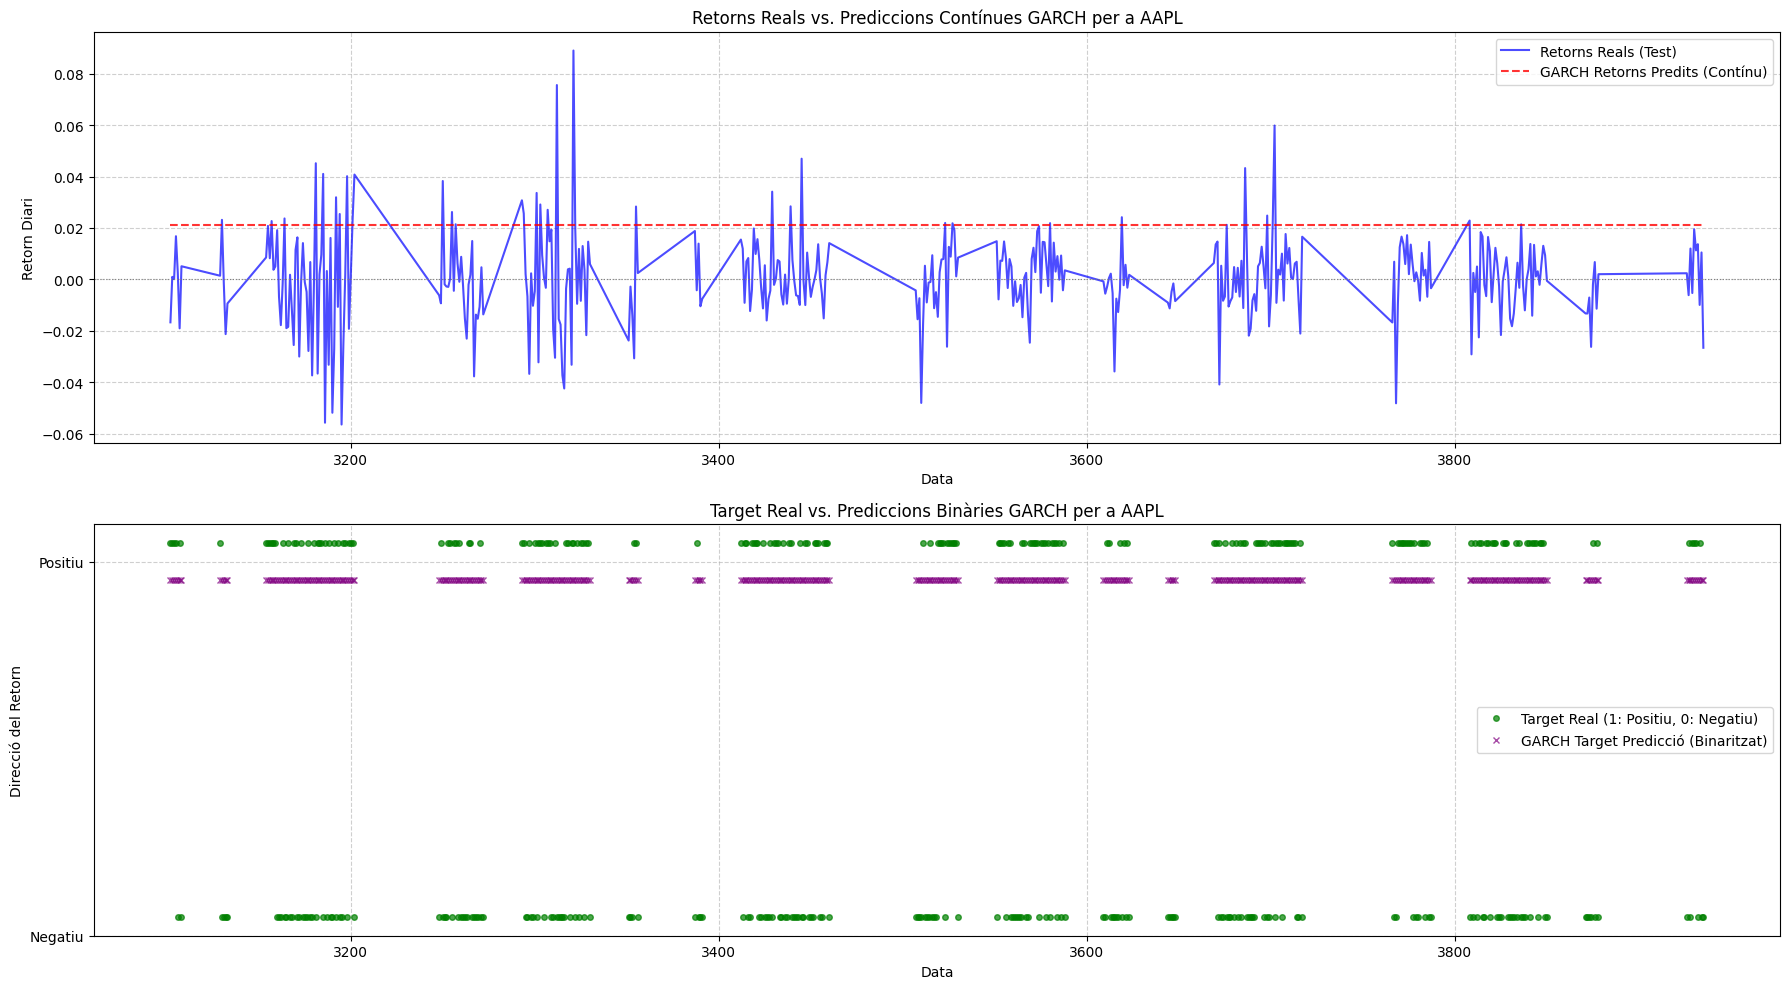


--- Aplicant models per a l'actiu: AMS ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a AMS...
Resum del model ARIMA per a AMS (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:             AMS_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                2873.789', 'Date:                Sun, 15 Jun 2025   AIC                          -5739.577', 'Time:                        17:03:03   BIC                          -5718.094', 'Sample:                             0   HQIC                         -5731.597', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '======

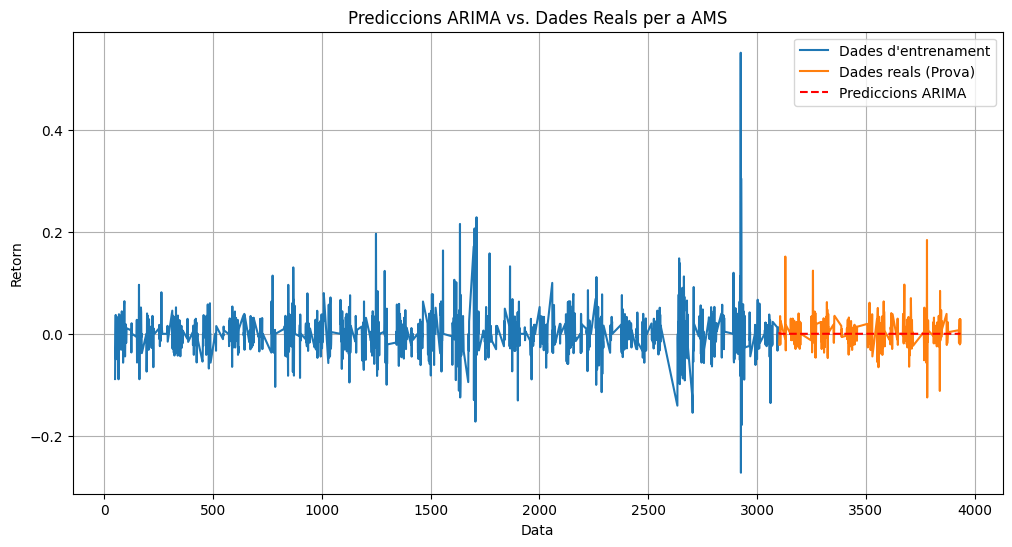


Aplicant model GARCH per a AMS...
Resum del model GARCH per a AMS (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   AMS_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                1936.95', "Distribution:      Standardized Student's t   AIC:                          -3863.91", 'Method:                  Maximum Likelihood   BIC:                          -3837.05', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:03   Df Model:                            1']


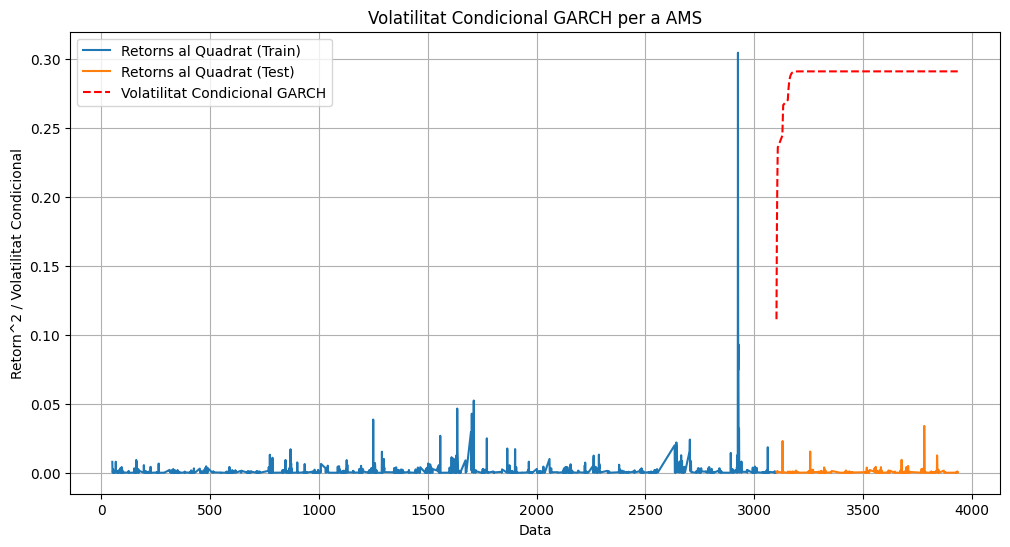


--- Avaluació de la Predicció de Direcció per a AMS ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4573
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.46      1.00      0.63       182

    accuracy                           0.46       398
   macro avg       0.23      0.50      0.31       398
weighted avg       0.21      0.46      0.29       398


GARCH (Binaritzat) - Accuracy: 0.5427
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       216
           1       0.00      0.00      0.00       182

    accuracy                           0.54       398
   macro avg       0.27      0.50      0.35       398
weighted avg       0.29      0.54      0.38       398



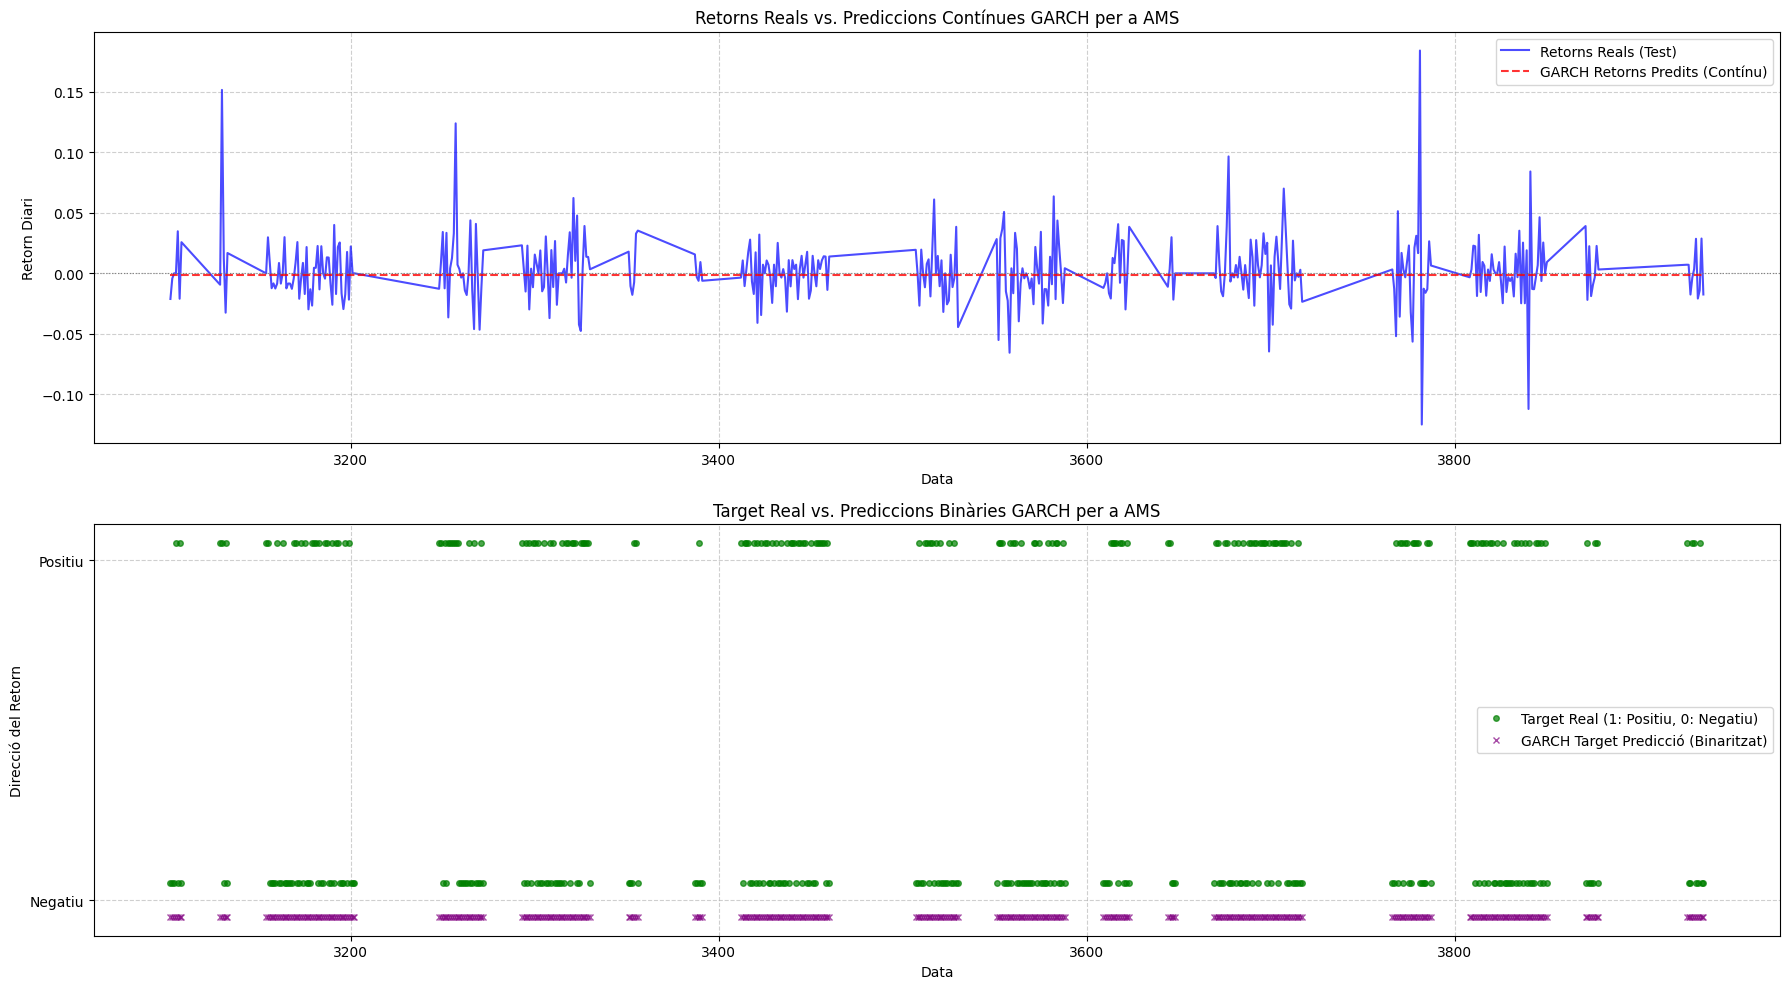


--- Aplicant models per a l'actiu: AMZN ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a AMZN...
Resum del model ARIMA per a AMZN (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            AMZN_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                3948.246', 'Date:                Sun, 15 Jun 2025   AIC                          -7888.491', 'Time:                        17:03:05   BIC                          -7867.008', 'Sample:                             0   HQIC                         -7880.511', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

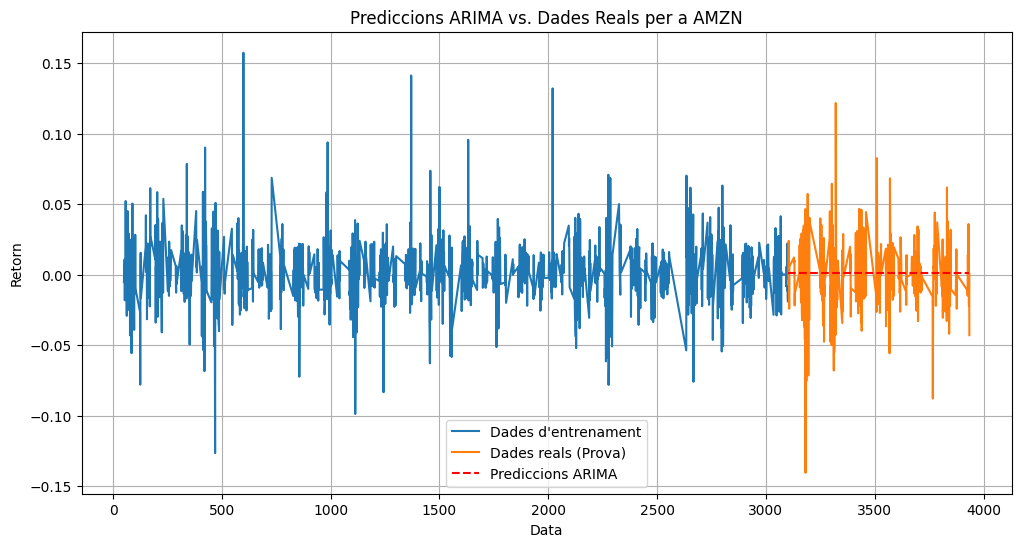


Aplicant model GARCH per a AMZN...
Resum del model GARCH per a AMZN (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  AMZN_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4163.65', "Distribution:      Standardized Student's t   AIC:                          -8317.30", 'Method:                  Maximum Likelihood   BIC:                          -8290.45', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:05   Df Model:                            1']


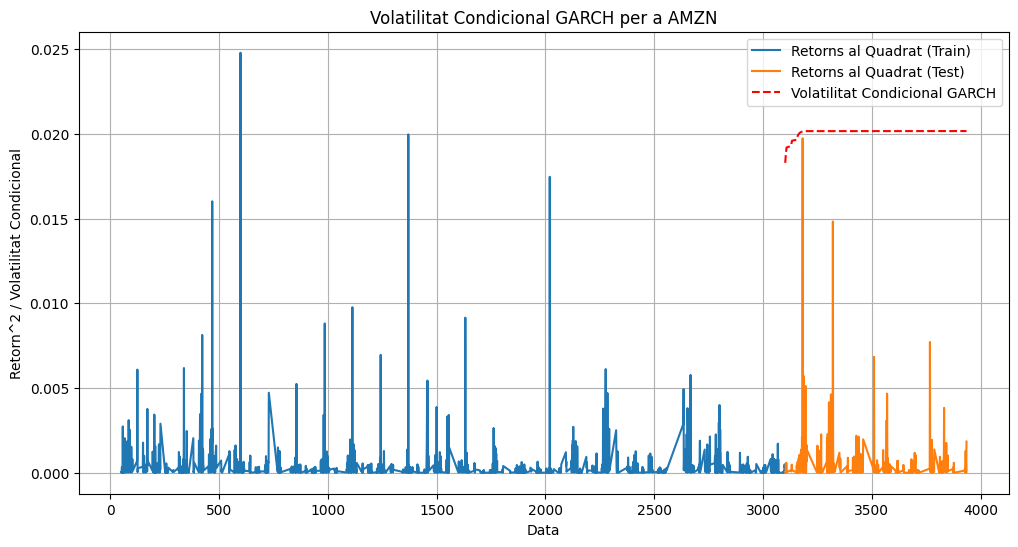


--- Avaluació de la Predicció de Direcció per a AMZN ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4925
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.49      1.00      0.66       196

    accuracy                           0.49       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.24      0.49      0.32       398


GARCH (Binaritzat) - Accuracy: 0.4925
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.49      1.00      0.66       196

    accuracy                           0.49       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.24      0.49      0.32       398



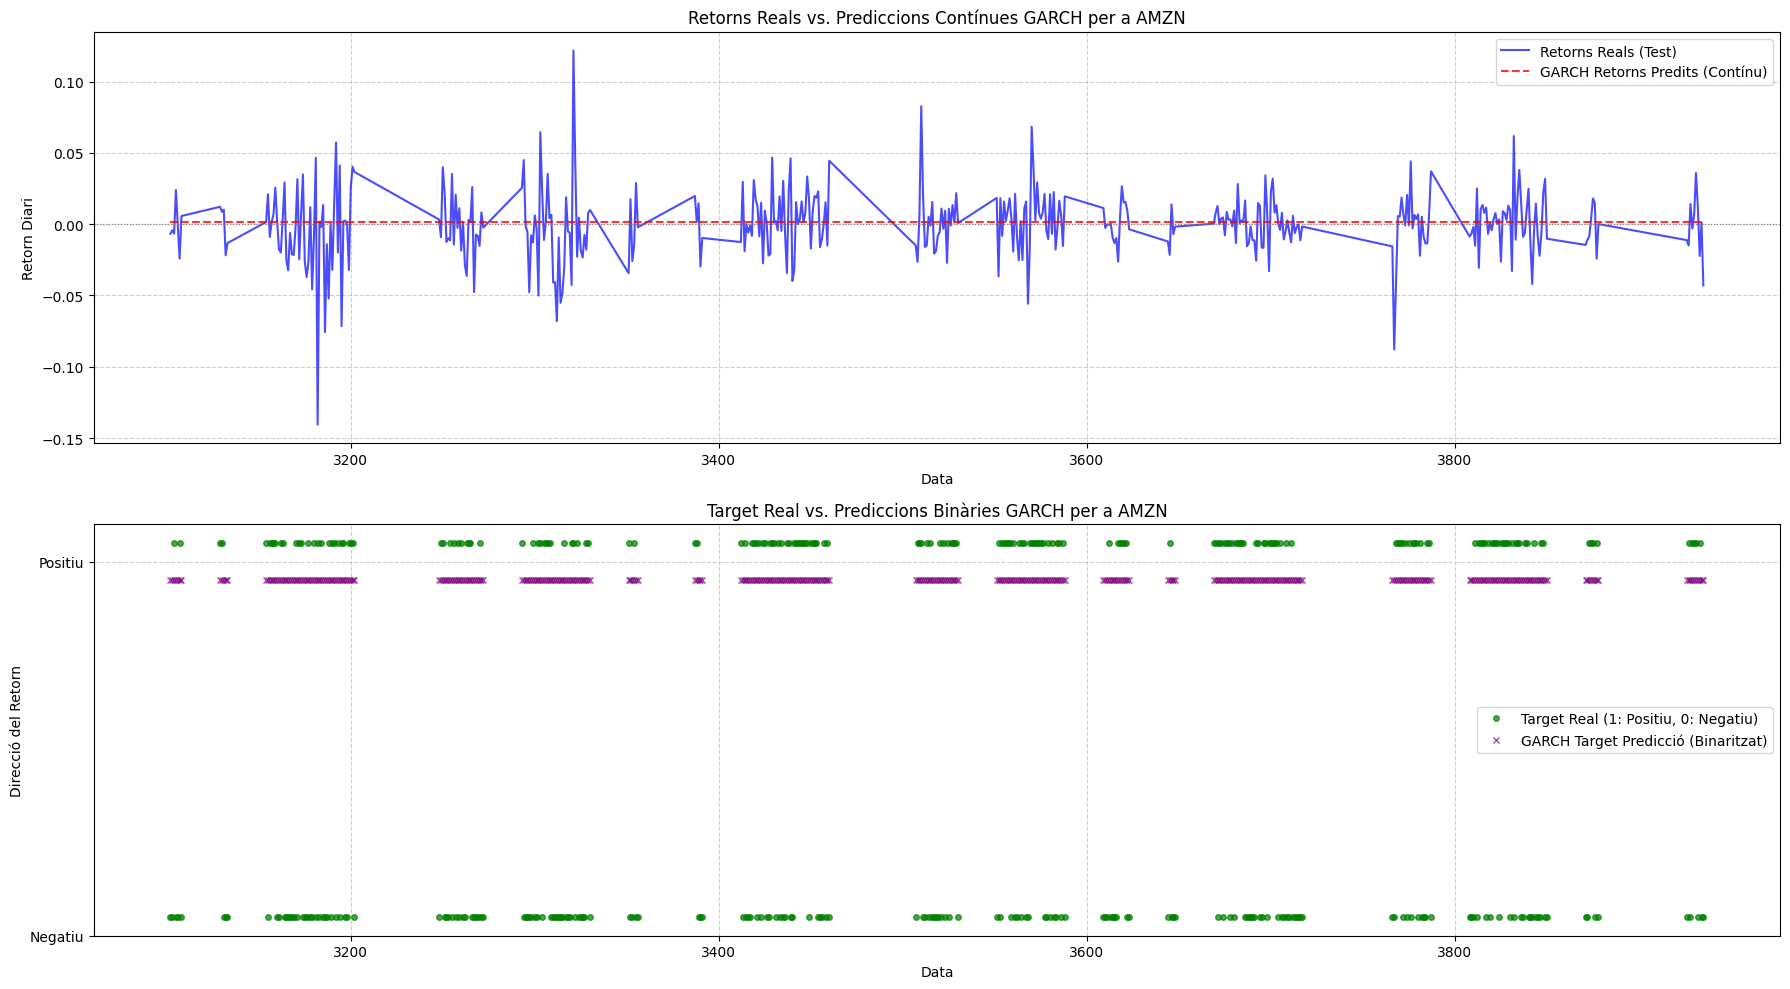


--- Aplicant models per a l'actiu: BBVA ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a BBVA...
Resum del model ARIMA per a BBVA (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            BBVA_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                3594.822', 'Date:                Sun, 15 Jun 2025   AIC                          -7181.643', 'Time:                        17:03:07   BIC                          -7160.160', 'Sample:                             0   HQIC                         -7173.663', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

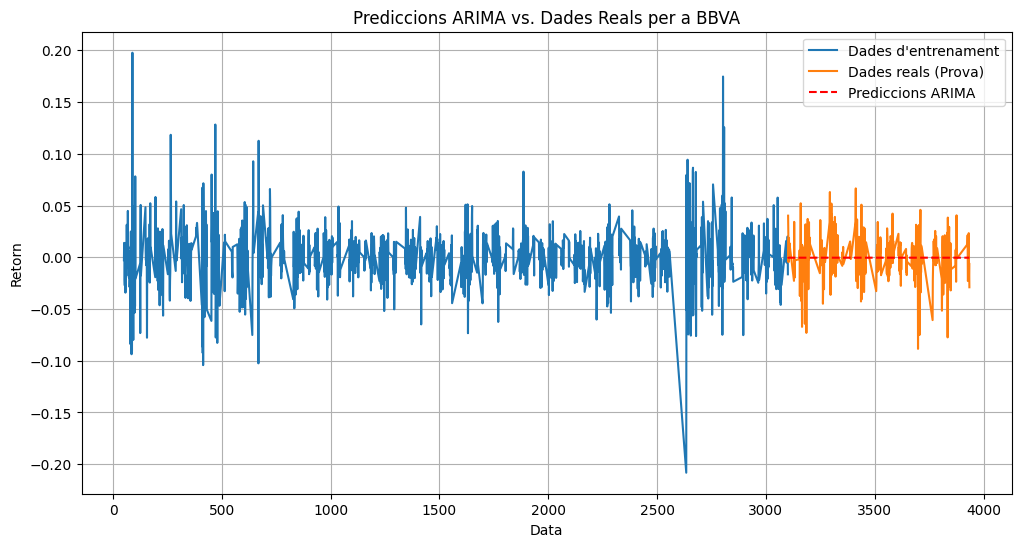


Aplicant model GARCH per a BBVA...
Resum del model GARCH per a BBVA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  BBVA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                2558.29', "Distribution:      Standardized Student's t   AIC:                          -5106.59", 'Method:                  Maximum Likelihood   BIC:                          -5079.74', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:08   Df Model:                            1']


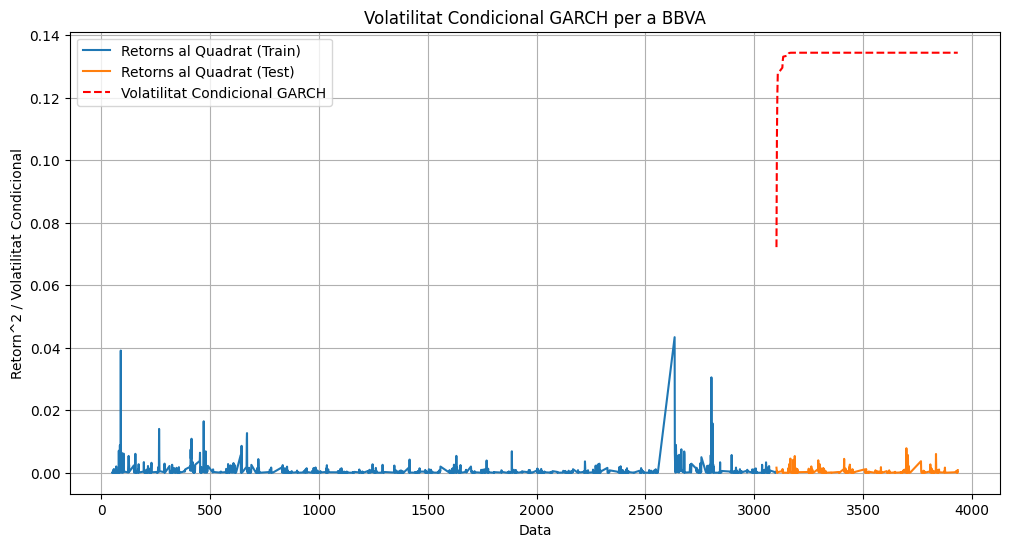


--- Avaluació de la Predicció de Direcció per a BBVA ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4899
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       194
           1       1.00      0.00      0.01       204

    accuracy                           0.49       398
   macro avg       0.74      0.50      0.33       398
weighted avg       0.75      0.49      0.33       398


GARCH (Binaritzat) - Accuracy: 0.4874
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       194
           1       0.00      0.00      0.00       204

    accuracy                           0.49       398
   macro avg       0.24      0.50      0.33       398
weighted avg       0.24      0.49      0.32       398



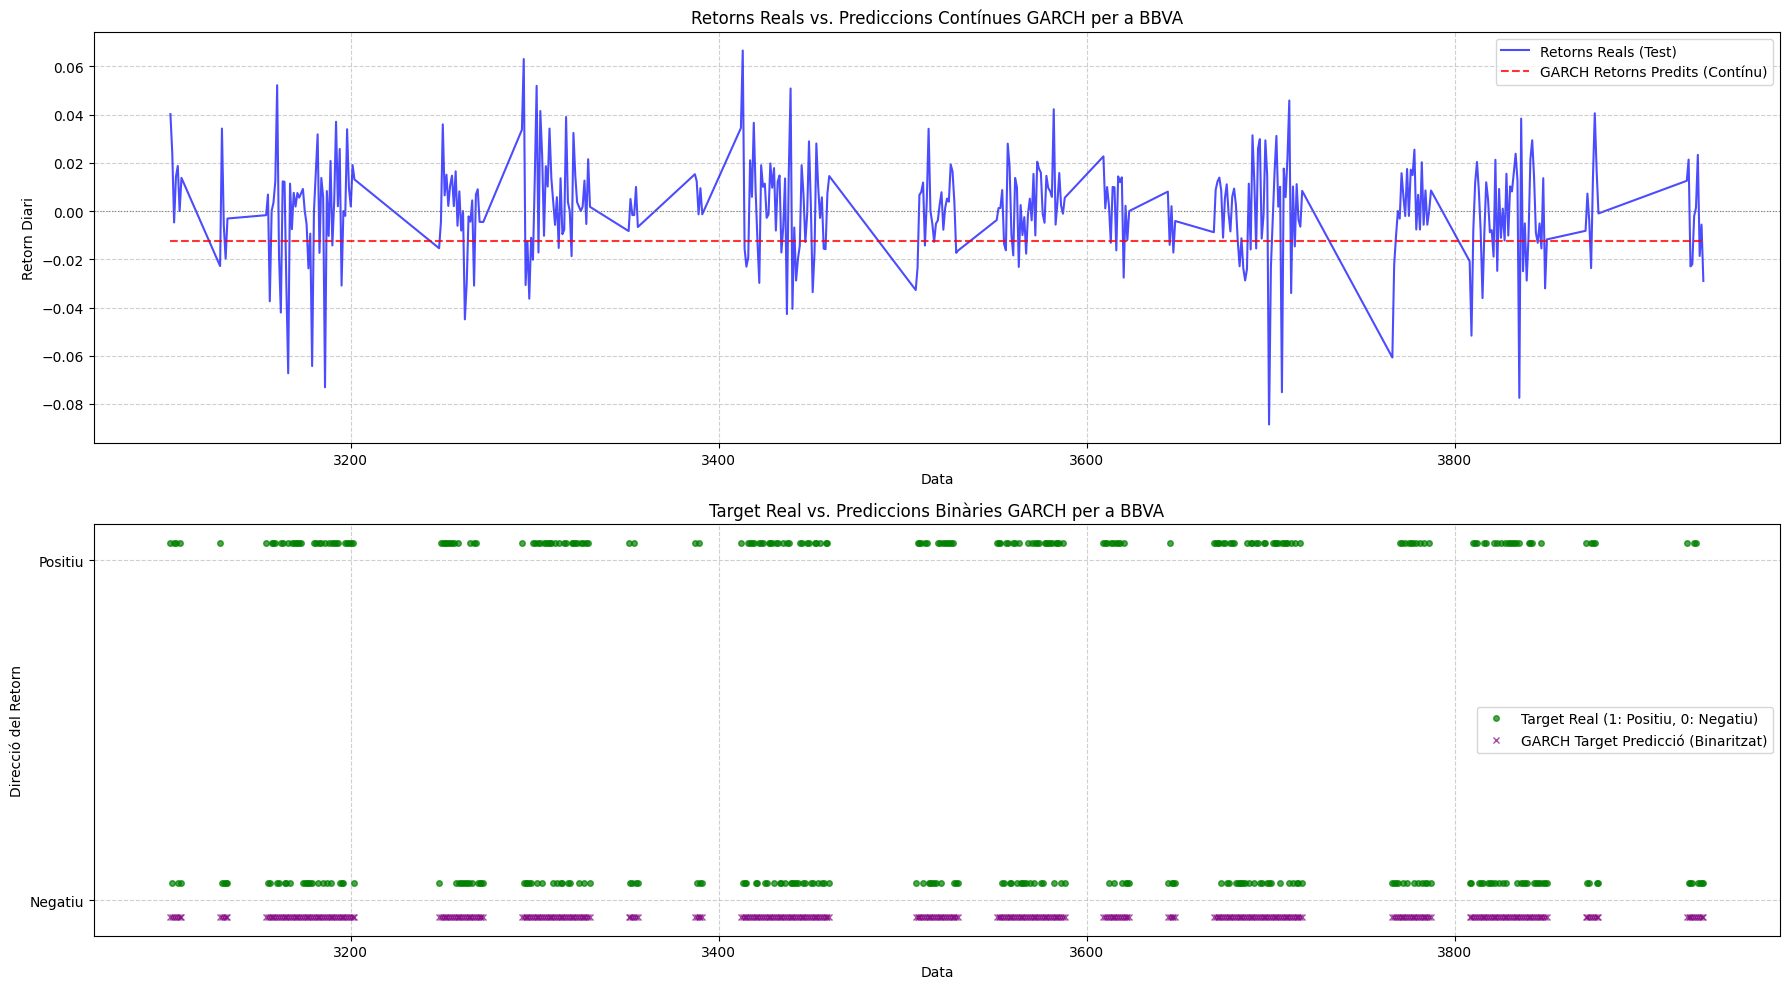


--- Aplicant models per a l'actiu: GOOGL ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a GOOGL...
Resum del model ARIMA per a GOOGL (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:           GOOGL_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4276.826', 'Date:                Sun, 15 Jun 2025   AIC                          -8545.652', 'Time:                        17:03:09   BIC                          -8524.169', 'Sample:                             0   HQIC                         -8537.672', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '

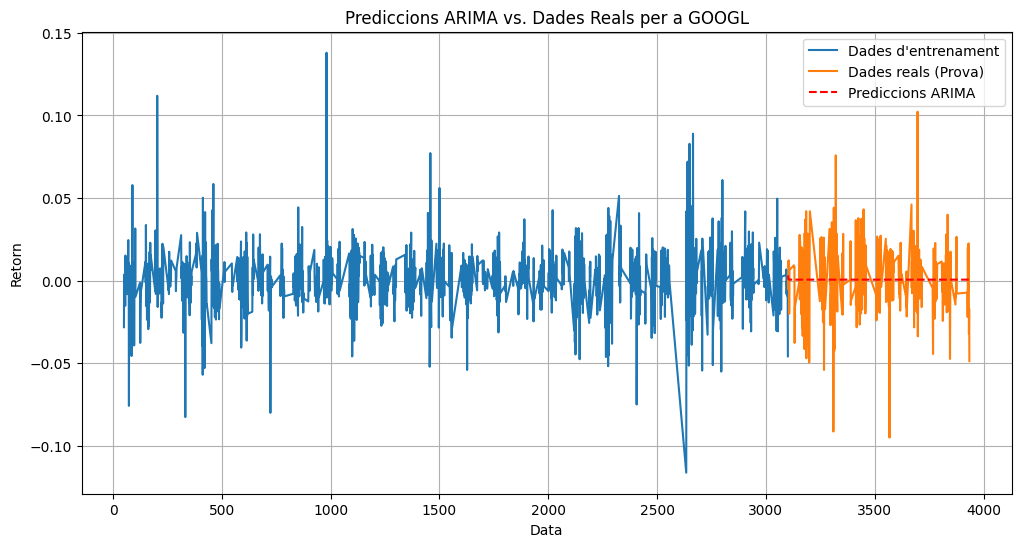


Aplicant model GARCH per a GOOGL...
Resum del model GARCH per a GOOGL (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                 GOOGL_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                922.318', "Distribution:      Standardized Student's t   AIC:                          -1834.64", 'Method:                  Maximum Likelihood   BIC:                          -1807.78', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:10   Df Model:                            1']


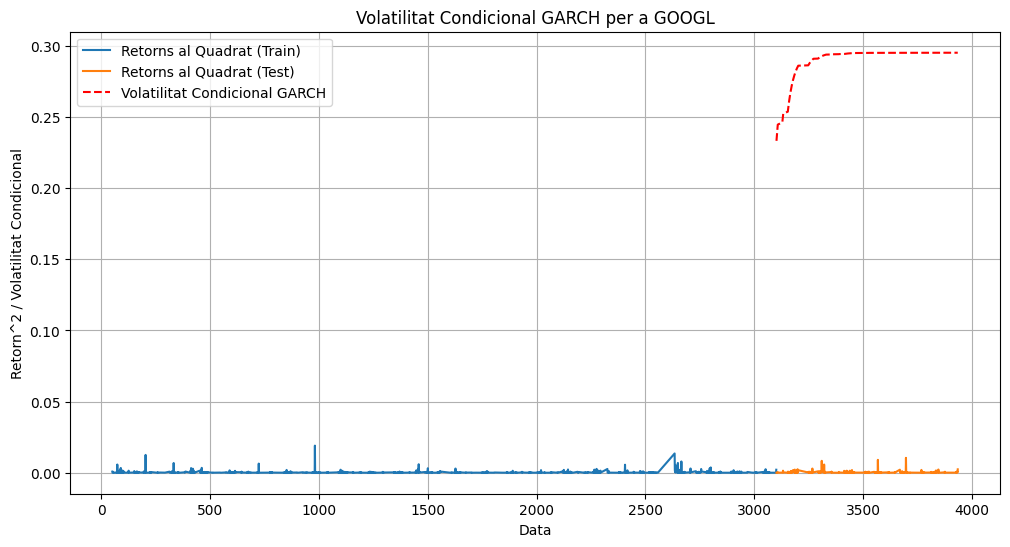


--- Avaluació de la Predicció de Direcció per a GOOGL ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5025
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.50      1.00      0.67       200

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.34       398


GARCH (Binaritzat) - Accuracy: 0.5025
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.50      1.00      0.67       200

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.34       398



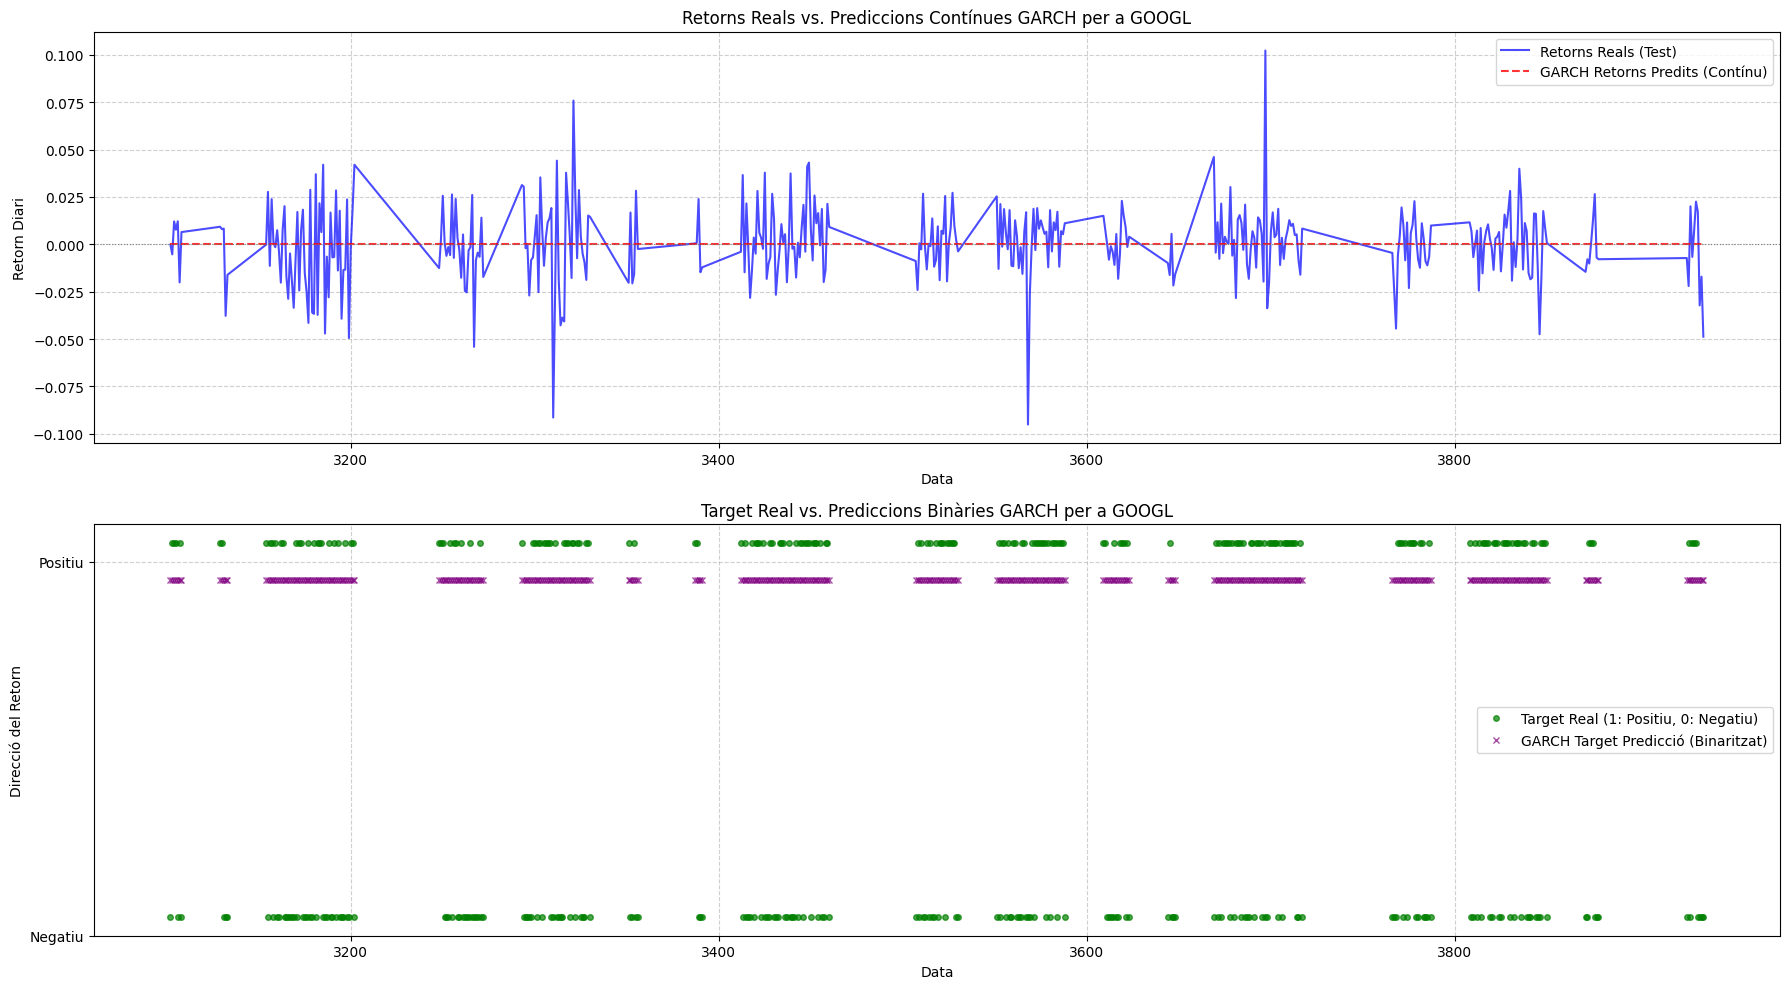


--- Aplicant models per a l'actiu: GSPC ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a GSPC...
Resum del model ARIMA per a GSPC (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            GSPC_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4907.203', 'Date:                Sun, 15 Jun 2025   AIC                          -9806.406', 'Time:                        17:03:11   BIC                          -9784.923', 'Sample:                             0   HQIC                         -9798.426', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

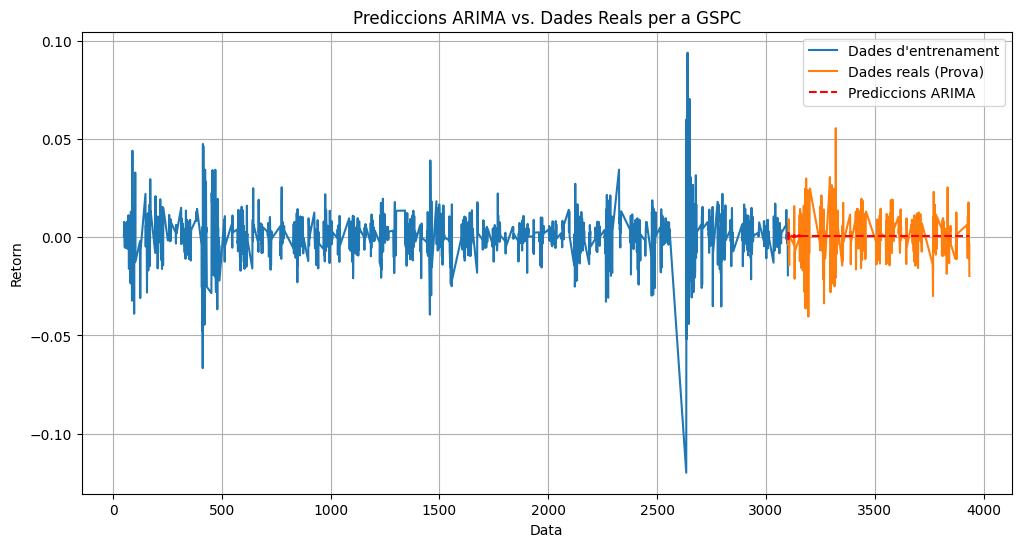


Aplicant model GARCH per a GSPC...
Resum del model GARCH per a GSPC (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  GSPC_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3825.58', "Distribution:      Standardized Student's t   AIC:                          -7641.16", 'Method:                  Maximum Likelihood   BIC:                          -7614.31', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:11   Df Model:                            1']


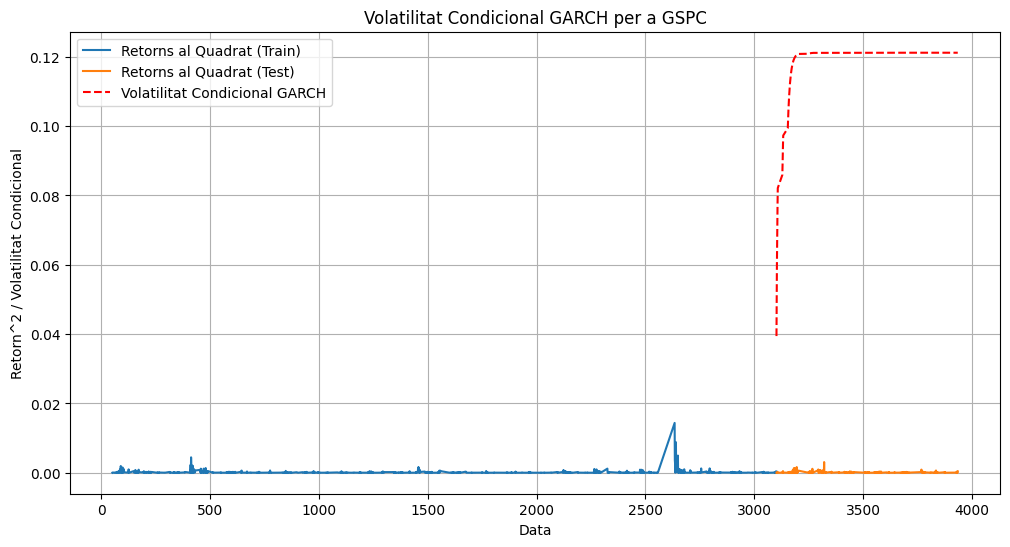


--- Avaluació de la Predicció de Direcció per a GSPC ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4899
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       201
           1       0.49      0.98      0.66       197

    accuracy                           0.49       398
   macro avg       0.37      0.49      0.33       398
weighted avg       0.37      0.49      0.33       398


GARCH (Binaritzat) - Accuracy: 0.4950
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       201
           1       0.49      1.00      0.66       197

    accuracy                           0.49       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.49      0.33       398



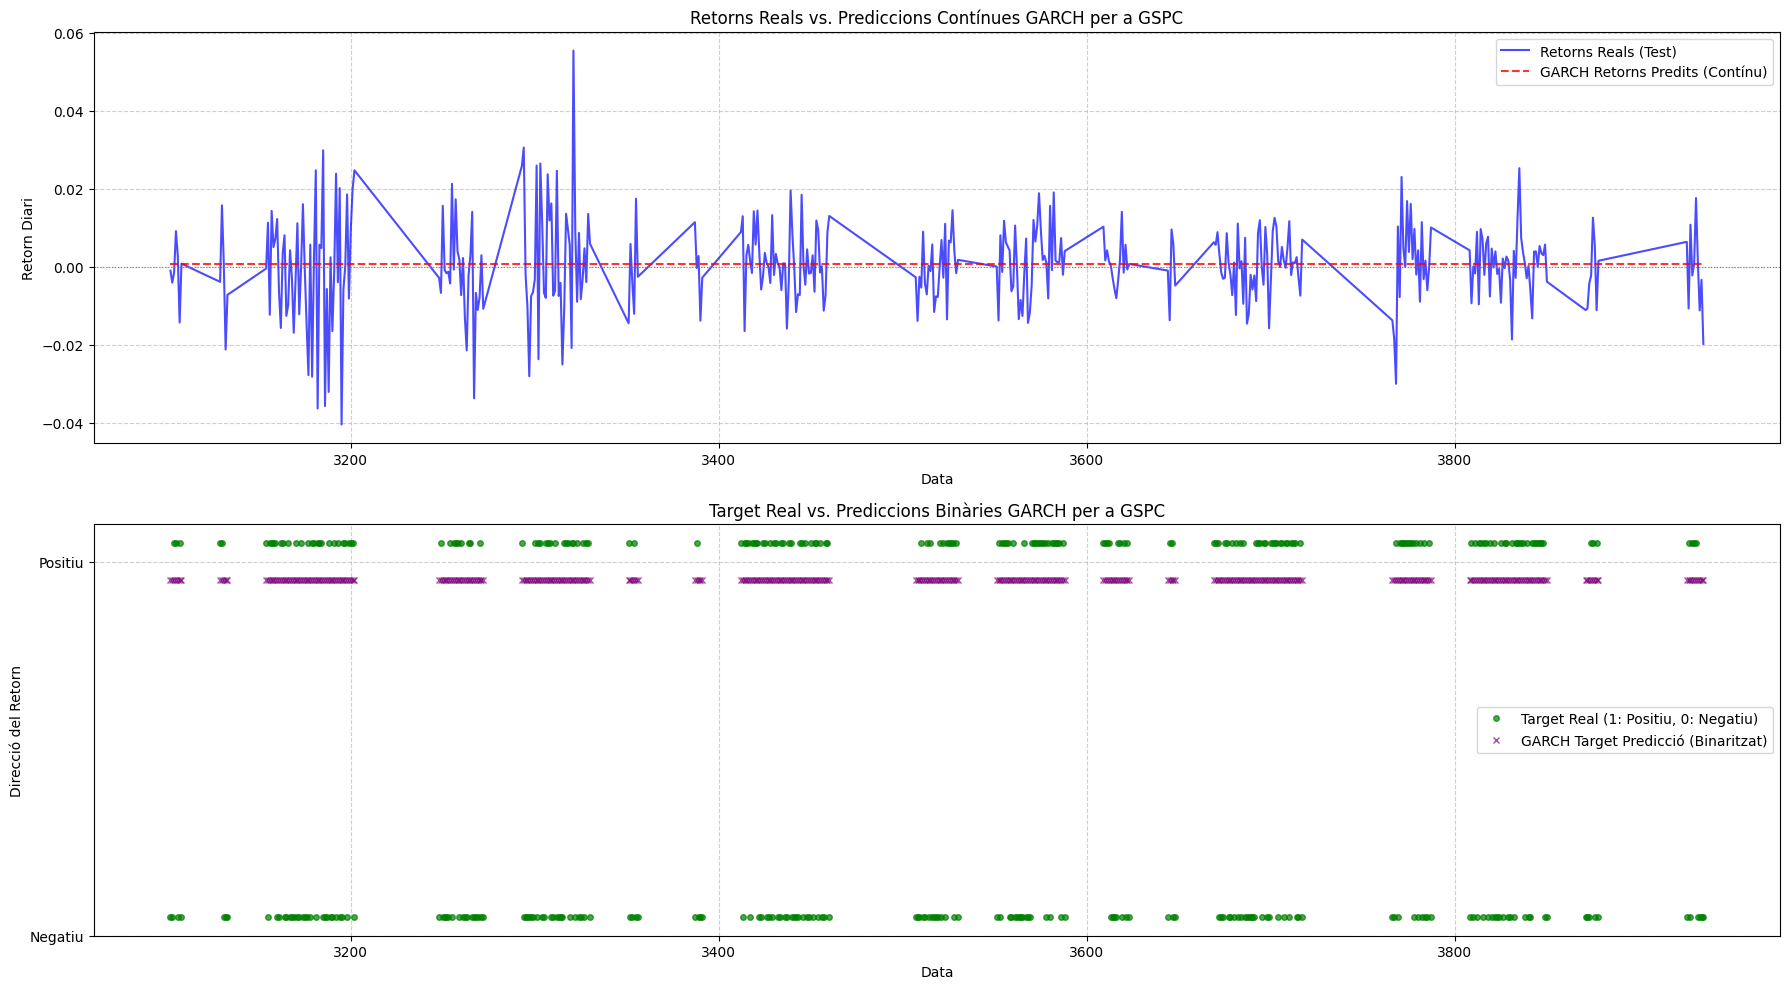


--- Aplicant models per a l'actiu: IBEX ---
Grandària de les dades d'entrenament: 2581
Grandària de les dades de prova: 646
Grandària del target de prova (y_test): 646

Aplicant model ARIMA per a IBEX...
Resum del model ARIMA per a IBEX (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            IBEX_return   No. Observations:                 2581', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                7238.347', 'Date:                Sun, 15 Jun 2025   AIC                         -14468.694', 'Time:                        17:03:13   BIC                         -14445.270', 'Sample:                             0   HQIC                        -14460.204', '                               - 2581                                         ', 'Covariance Type:                  opg                                         ', '===

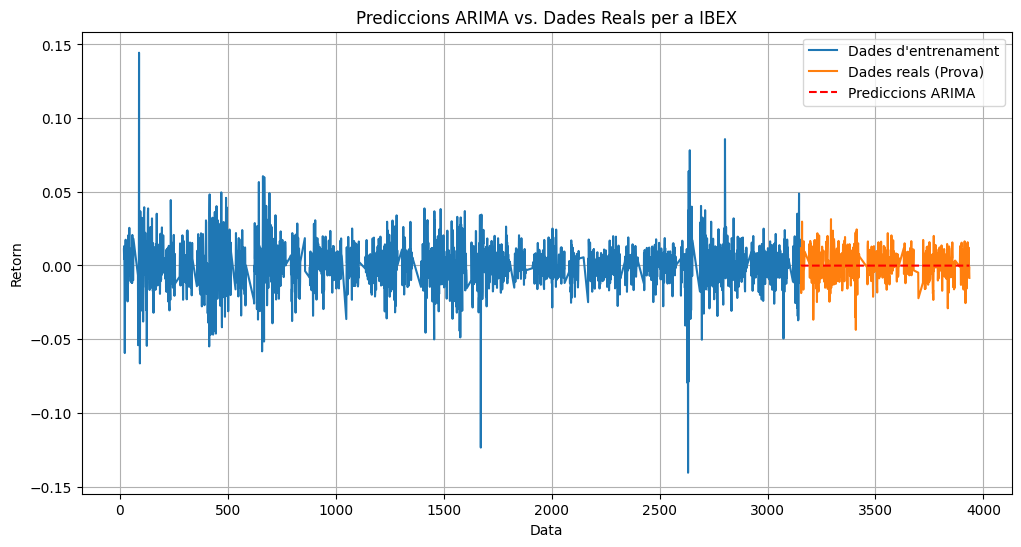


Aplicant model GARCH per a IBEX...
Resum del model GARCH per a IBEX (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  IBEX_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                5234.22', "Distribution:      Standardized Student's t   AIC:                          -10458.4", 'Method:                  Maximum Likelihood   BIC:                          -10429.2', '                                              No. Observations:                 2581', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     2580', 'Time:                              17:03:14   Df Model:                            1']


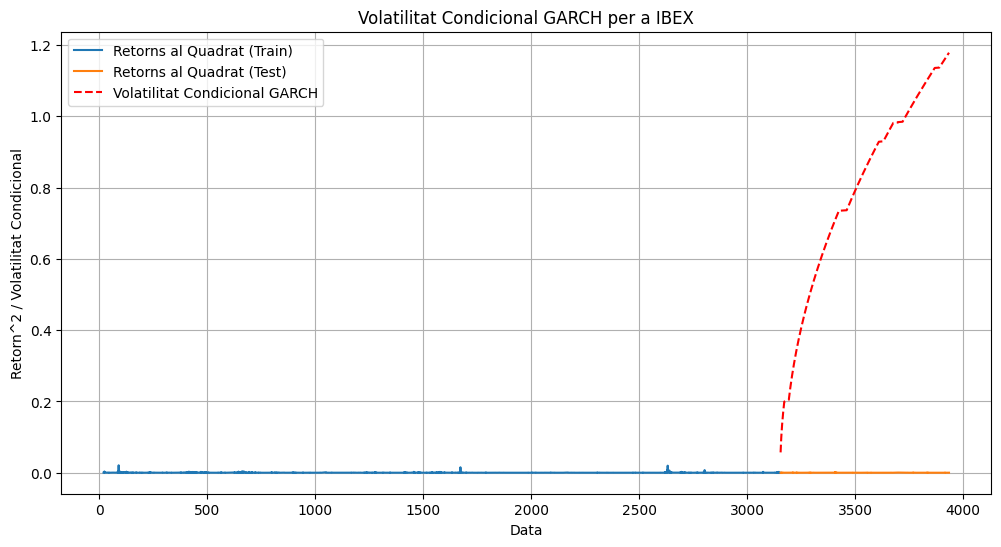


--- Avaluació de la Predicció de Direcció per a IBEX ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4613
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       298
           1       0.00      0.00      0.00       348

    accuracy                           0.46       646
   macro avg       0.23      0.50      0.32       646
weighted avg       0.21      0.46      0.29       646


GARCH (Binaritzat) - Accuracy: 0.5387
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       298
           1       0.54      1.00      0.70       348

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.29      0.54      0.38       646



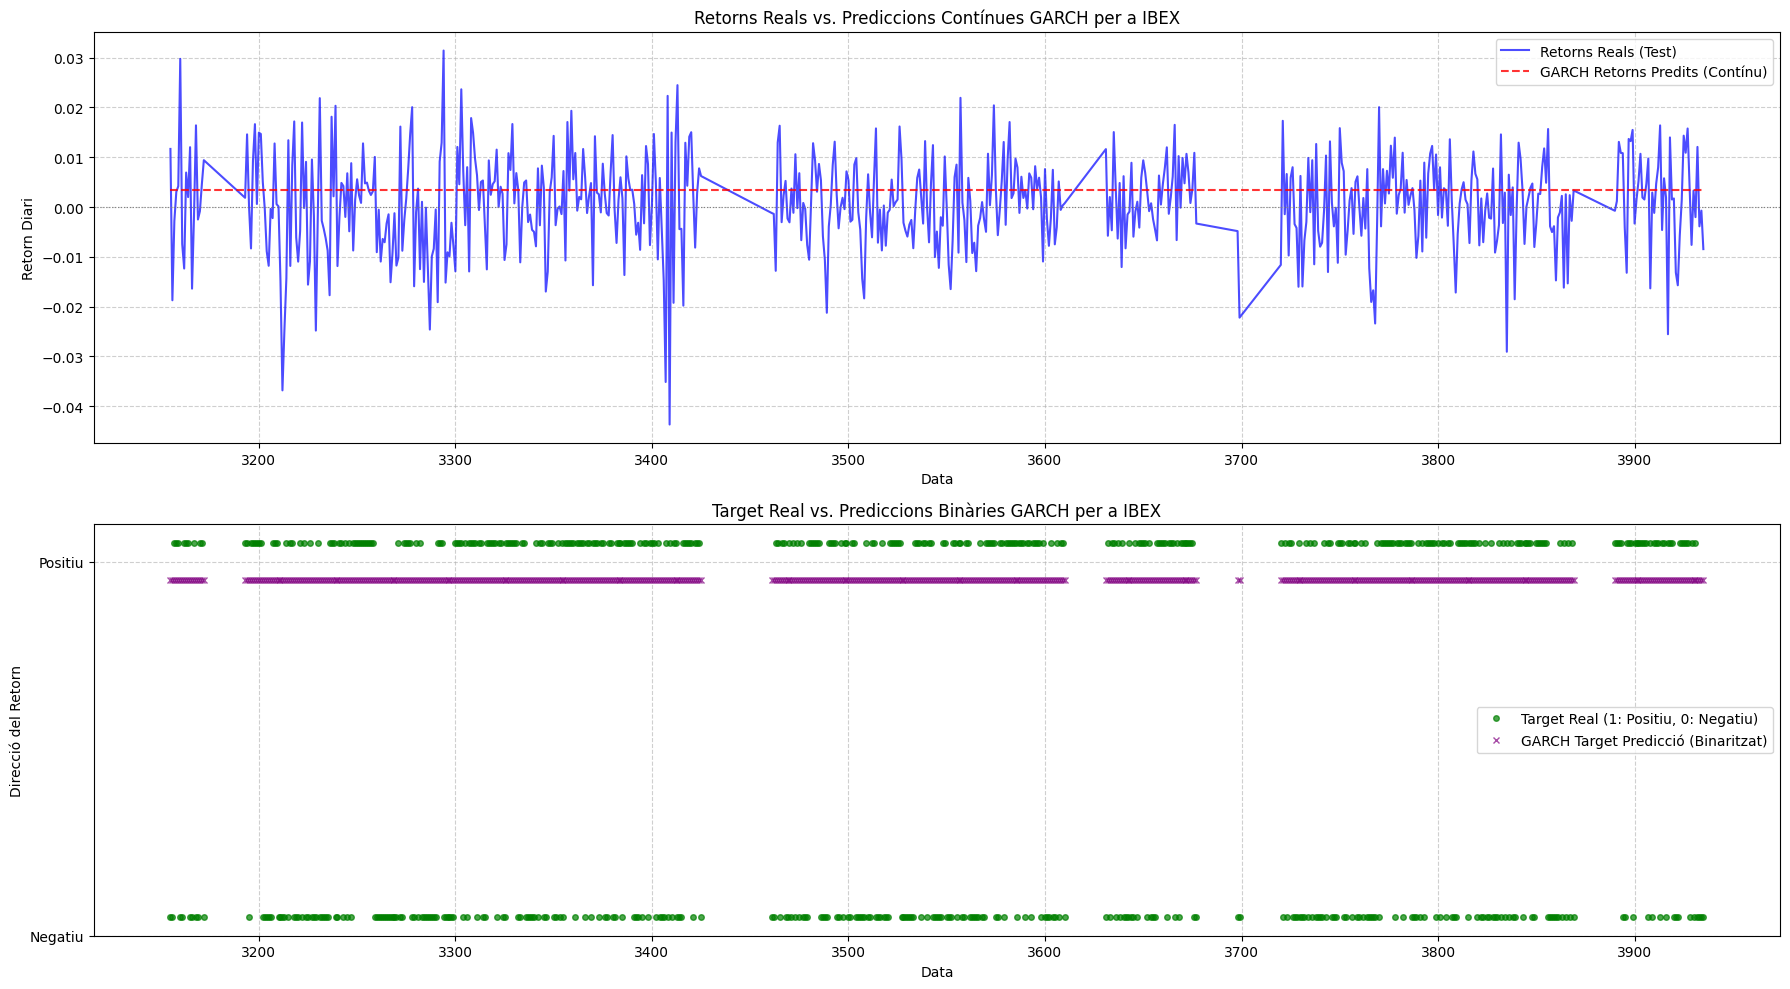


--- Aplicant models per a l'actiu: IXIC ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a IXIC...
Resum del model ARIMA per a IXIC (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            IXIC_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4696.400', 'Date:                Sun, 15 Jun 2025   AIC                          -9384.800', 'Time:                        17:03:15   BIC                          -9363.317', 'Sample:                             0   HQIC                         -9376.820', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

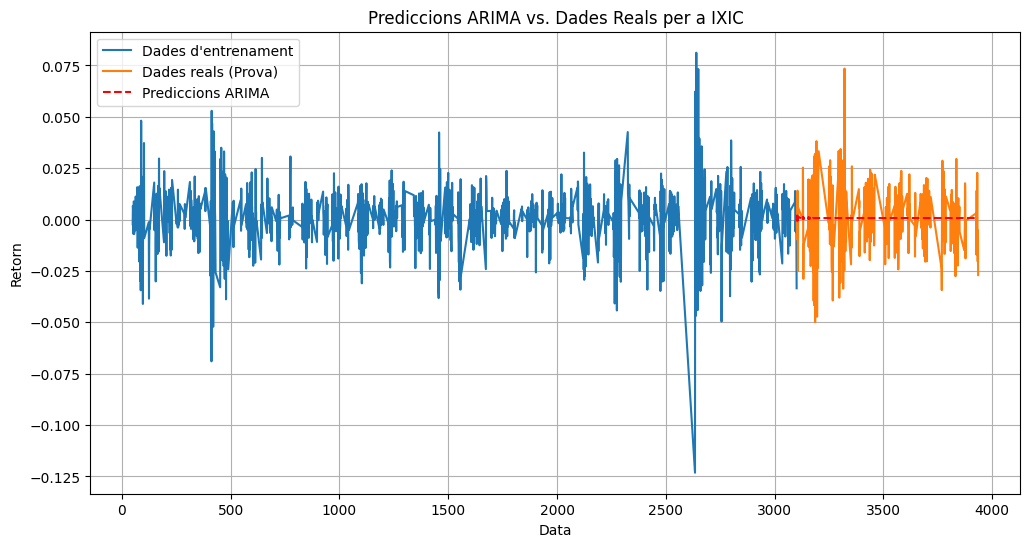


Aplicant model GARCH per a IXIC...
Resum del model GARCH per a IXIC (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  IXIC_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3822.46', "Distribution:      Standardized Student's t   AIC:                          -7634.93", 'Method:                  Maximum Likelihood   BIC:                          -7608.07', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:15   Df Model:                            1']


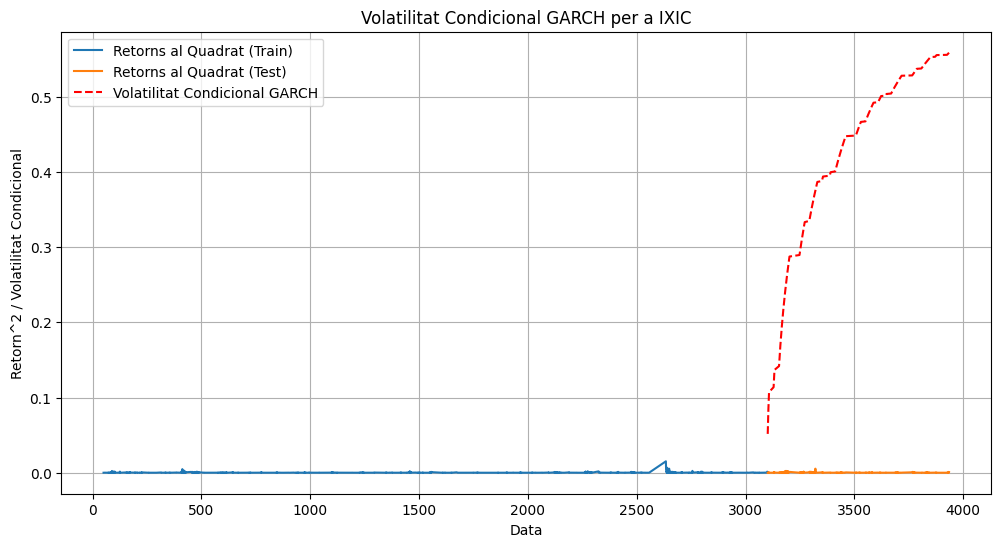


--- Avaluació de la Predicció de Direcció per a IXIC ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4899
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.49      0.98      0.66       198

    accuracy                           0.49       398
   macro avg       0.25      0.49      0.33       398
weighted avg       0.25      0.49      0.33       398


GARCH (Binaritzat) - Accuracy: 0.4975
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.50      1.00      0.66       198

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.33       398



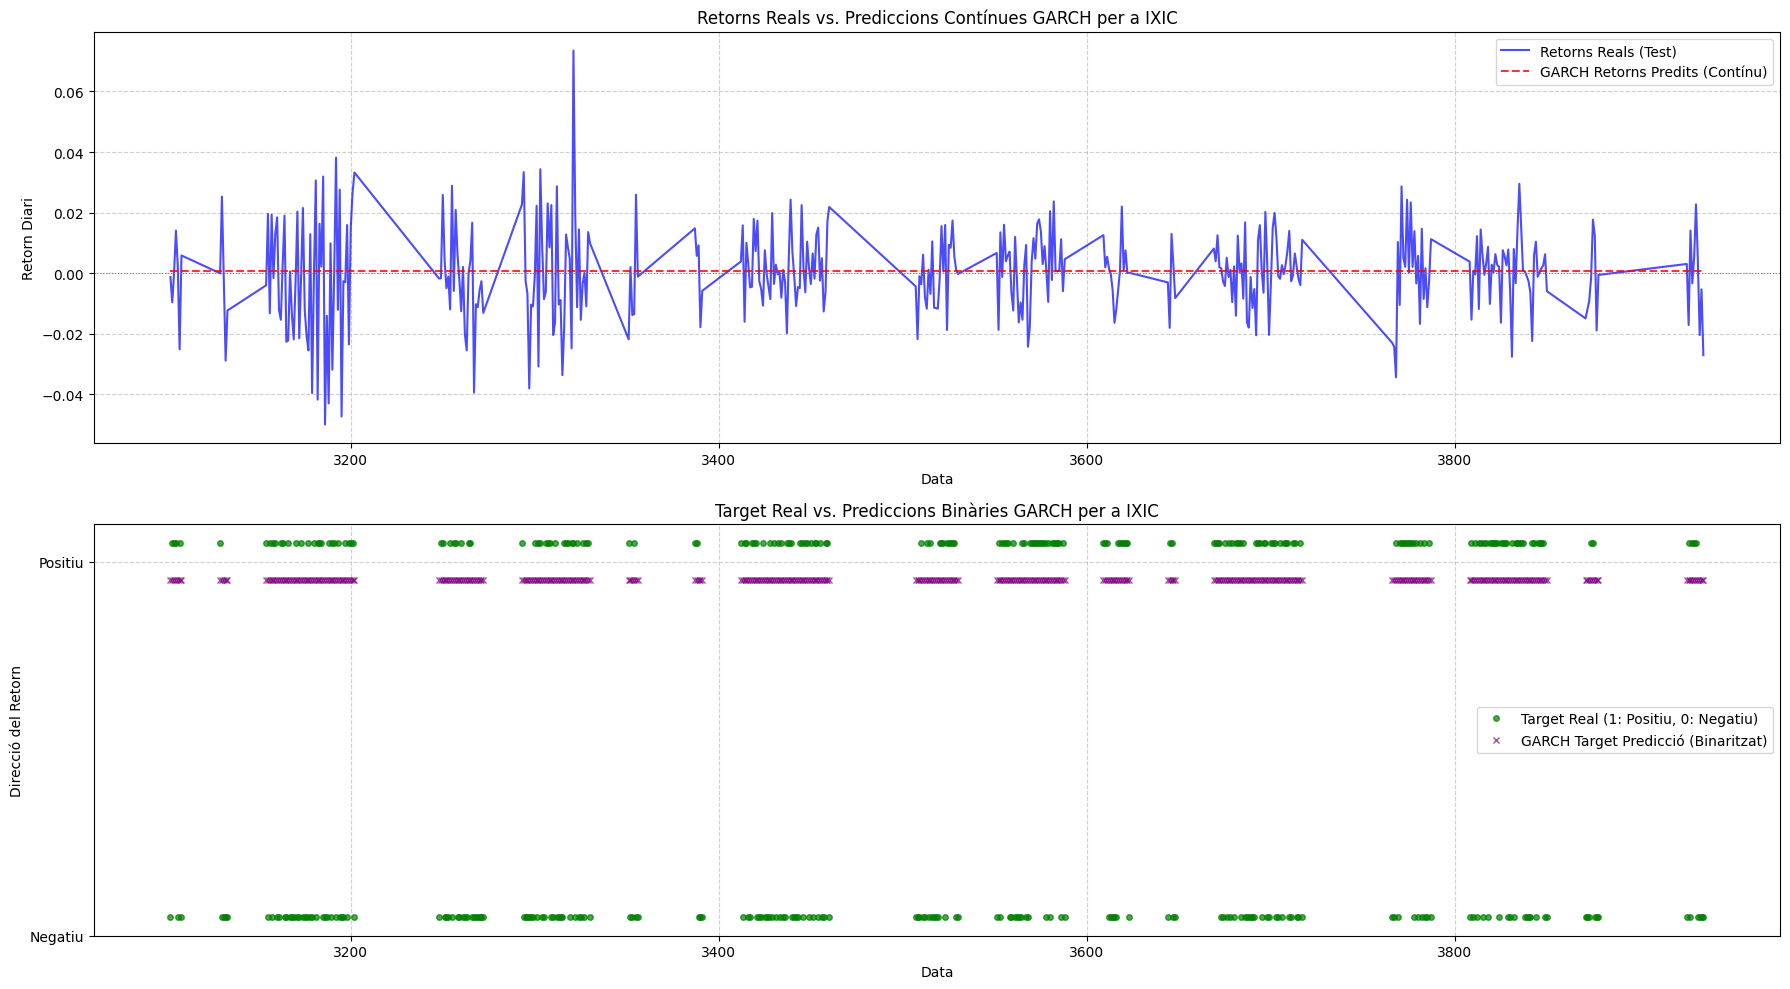


--- Aplicant models per a l'actiu: JPM ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a JPM...
Resum del model ARIMA per a JPM (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:             JPM_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4119.509', 'Date:                Sun, 15 Jun 2025   AIC                          -8231.017', 'Time:                        17:03:17   BIC                          -8209.534', 'Sample:                             0   HQIC                         -8223.037', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '======

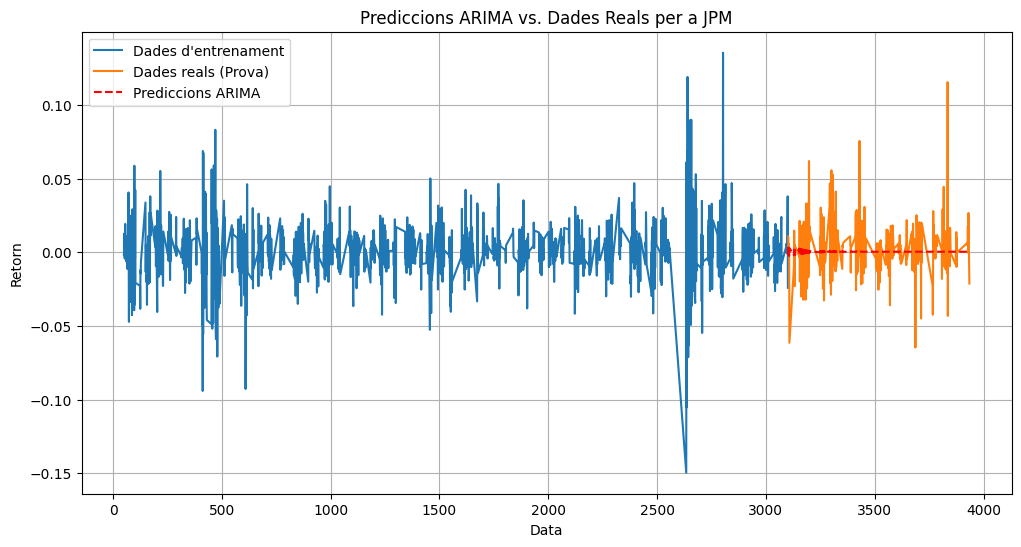


Aplicant model GARCH per a JPM...
Resum del model GARCH per a JPM (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   JPM_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3179.83', "Distribution:      Standardized Student's t   AIC:                          -6349.67", 'Method:                  Maximum Likelihood   BIC:                          -6322.81', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:17   Df Model:                            1']


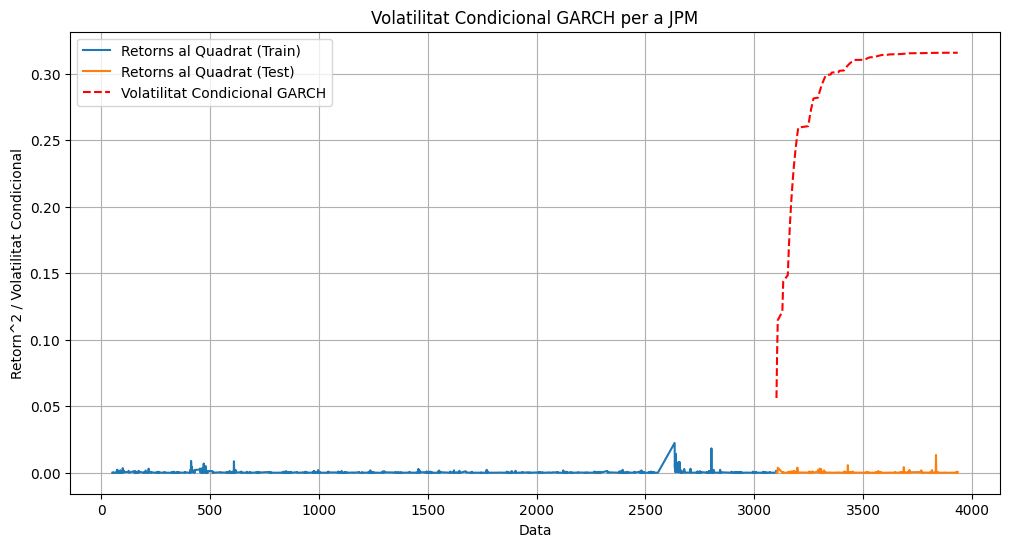


--- Avaluació de la Predicció de Direcció per a JPM ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5327
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.10      0.17       188
           1       0.53      0.92      0.67       210

    accuracy                           0.53       398
   macro avg       0.53      0.51      0.42       398
weighted avg       0.53      0.53      0.44       398


GARCH (Binaritzat) - Accuracy: 0.5276
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.53      1.00      0.69       210

    accuracy                           0.53       398
   macro avg       0.26      0.50      0.35       398
weighted avg       0.28      0.53      0.36       398



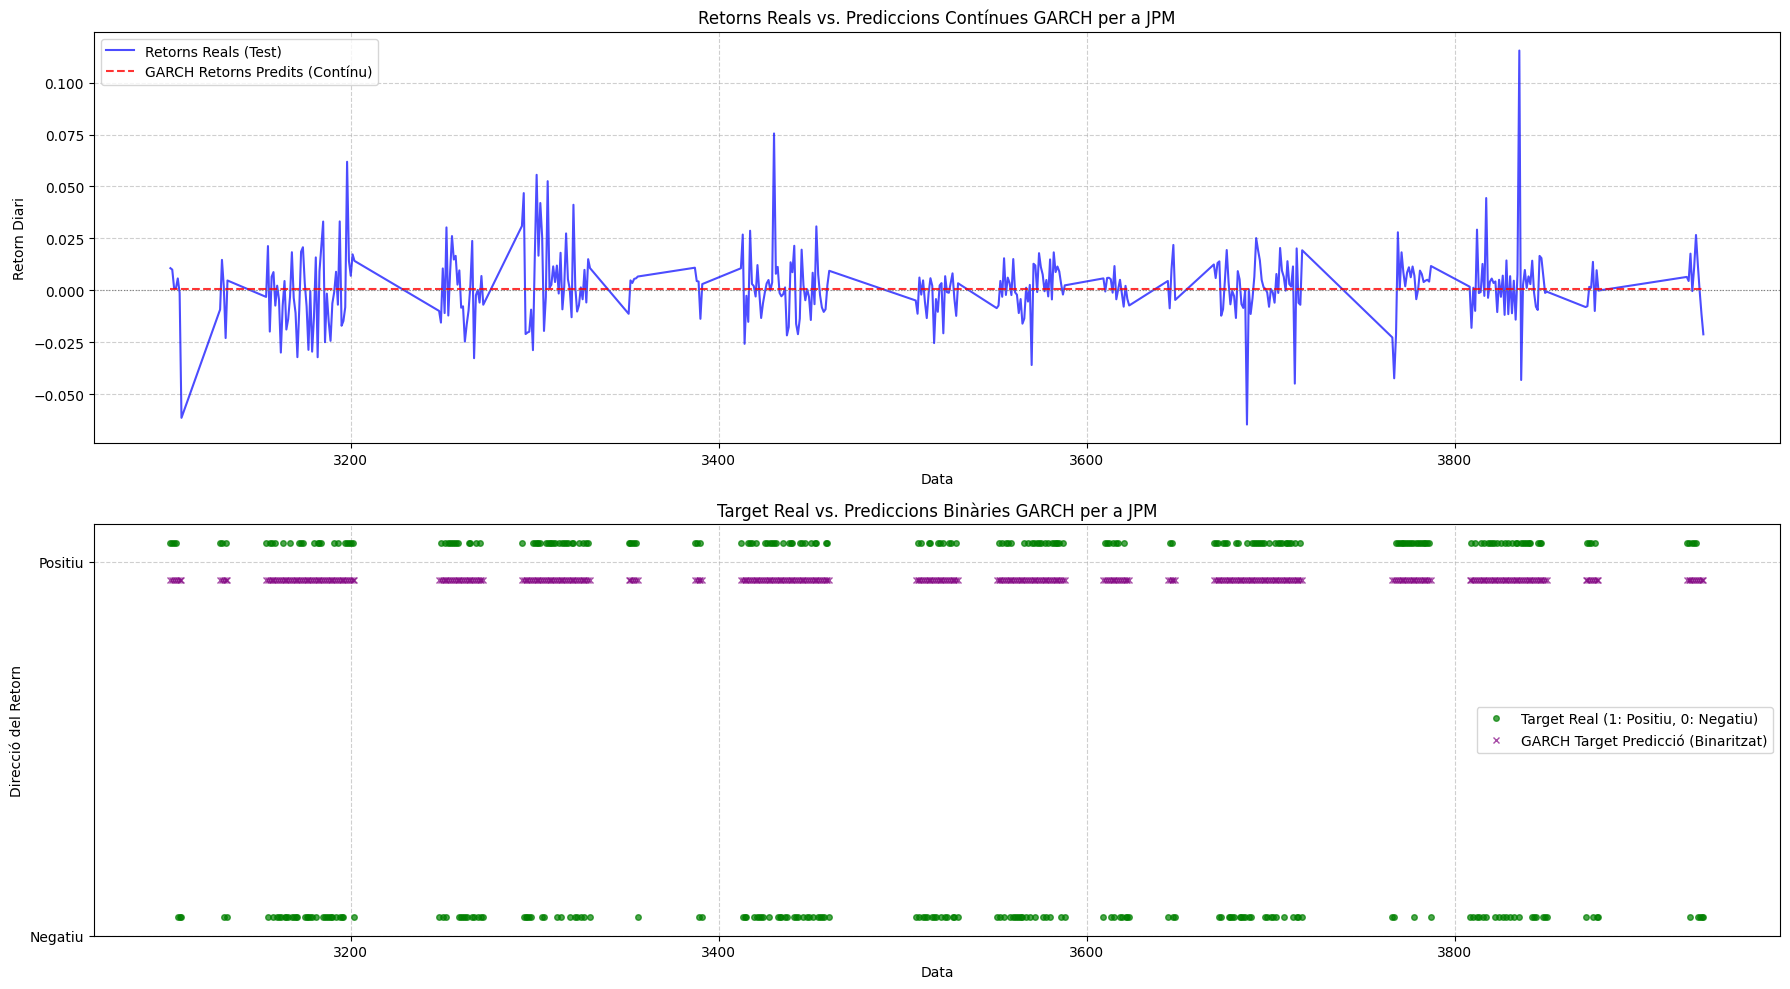


--- Aplicant models per a l'actiu: LLY ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a LLY...
Resum del model ARIMA per a LLY (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:             LLY_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4439.191', 'Date:                Sun, 15 Jun 2025   AIC                          -8870.383', 'Time:                        17:03:19   BIC                          -8848.899', 'Sample:                             0   HQIC                         -8862.402', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '======

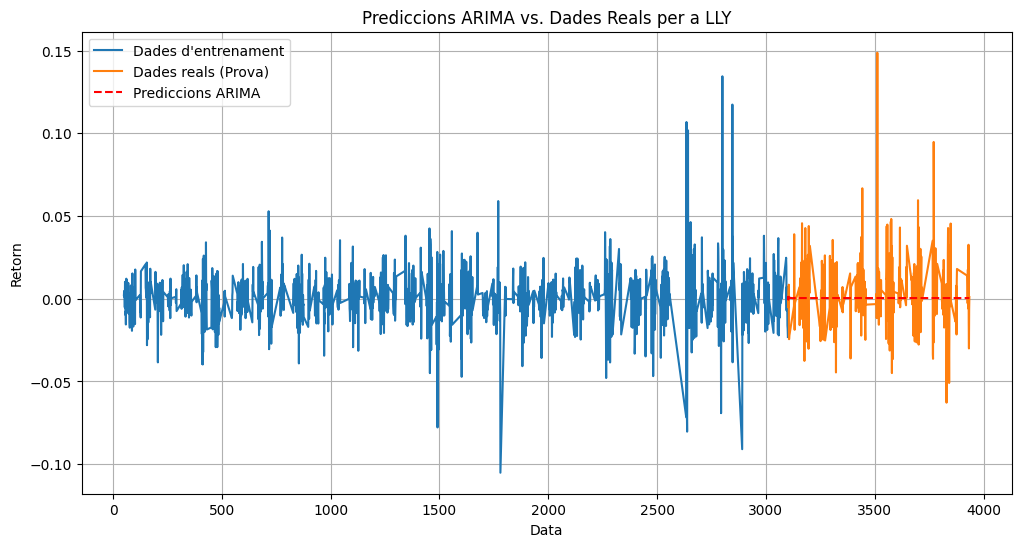


Aplicant model GARCH per a LLY...
Resum del model GARCH per a LLY (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   LLY_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4709.53', "Distribution:      Standardized Student's t   AIC:                          -9409.06", 'Method:                  Maximum Likelihood   BIC:                          -9382.21', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:19   Df Model:                            1']


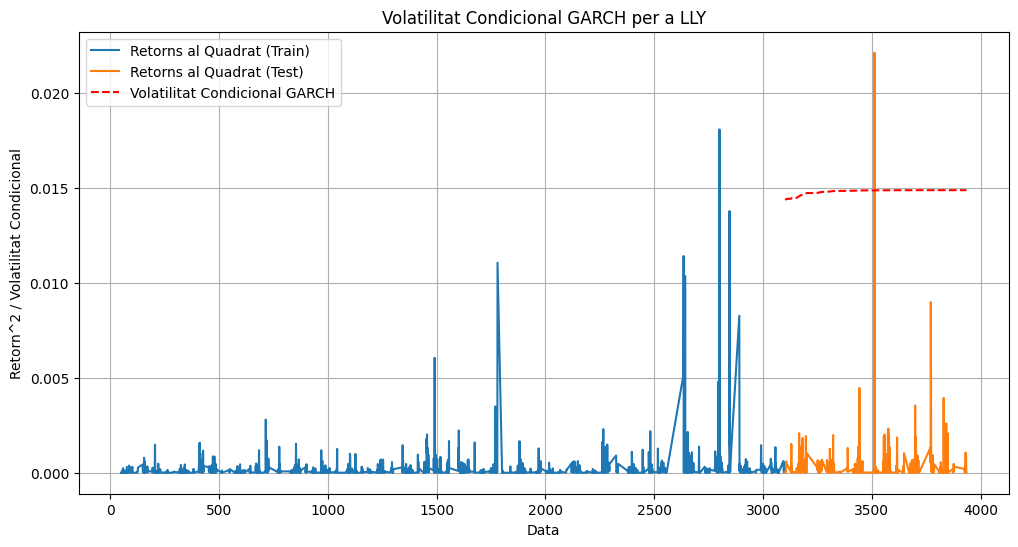


--- Avaluació de la Predicció de Direcció per a LLY ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5176
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.01       192
           1       0.52      1.00      0.68       206

    accuracy                           0.52       398
   macro avg       0.51      0.50      0.35       398
weighted avg       0.51      0.52      0.36       398


GARCH (Binaritzat) - Accuracy: 0.5176
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.52      1.00      0.68       206

    accuracy                           0.52       398
   macro avg       0.26      0.50      0.34       398
weighted avg       0.27      0.52      0.35       398



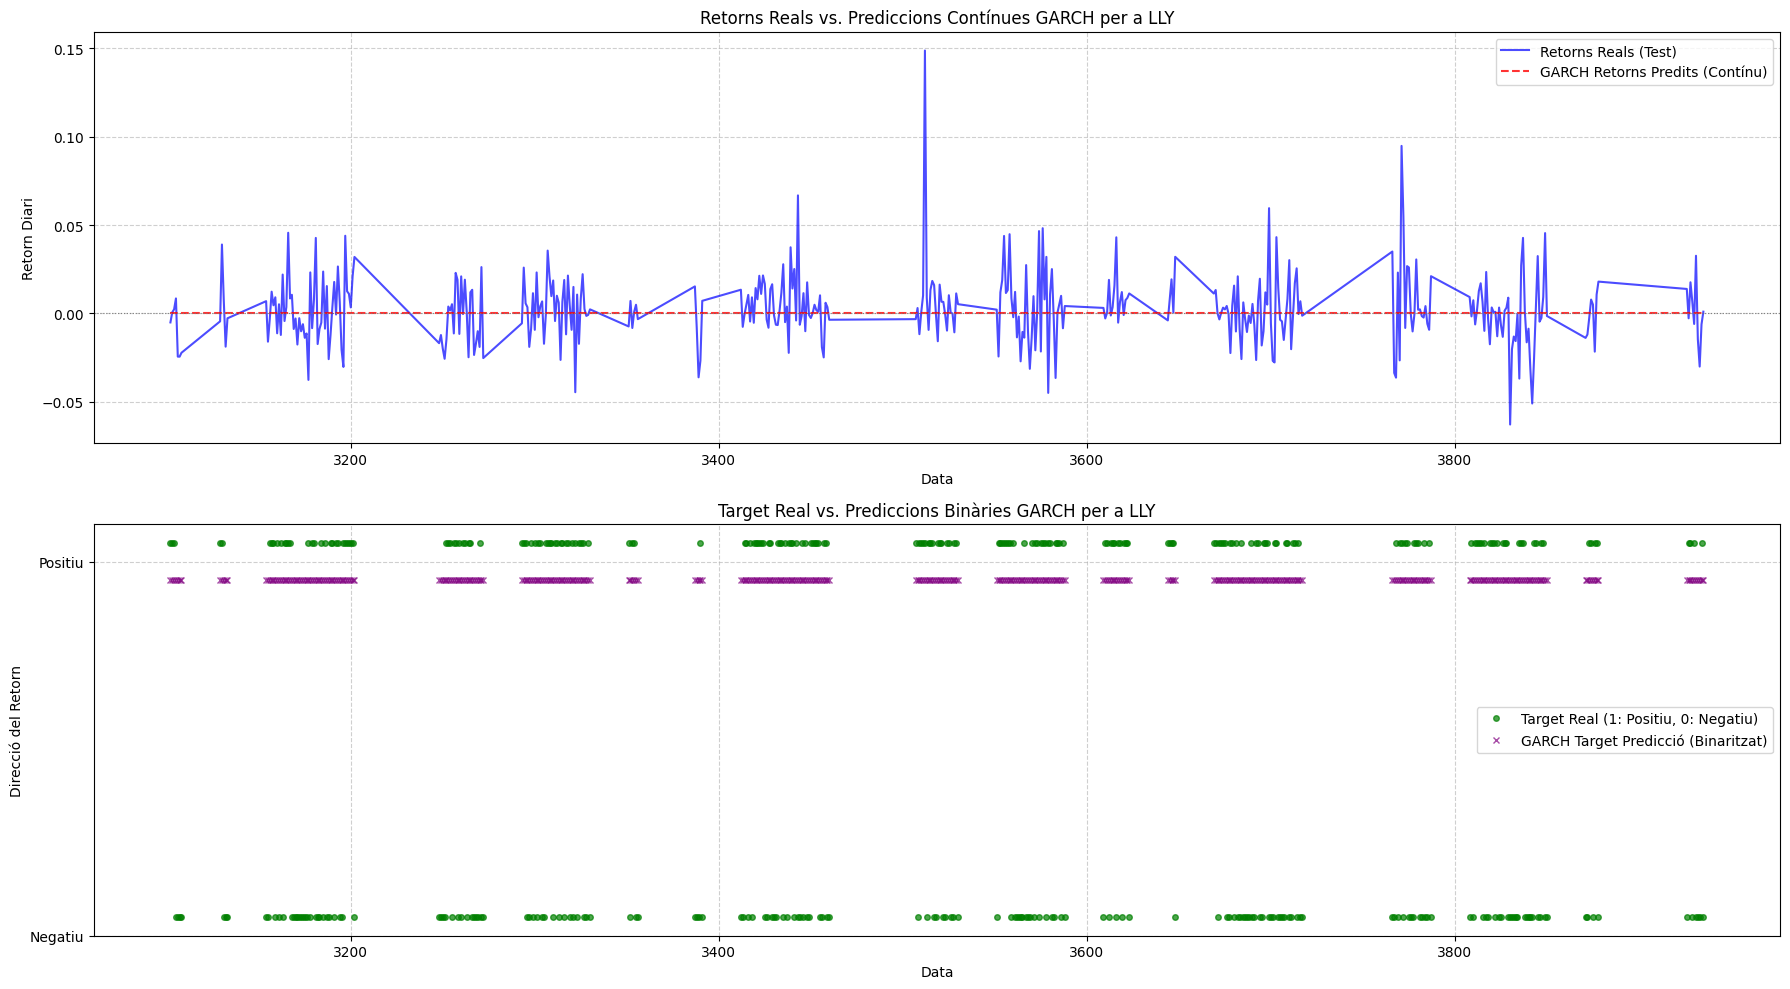


--- Aplicant models per a l'actiu: MSFT ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a MSFT...
Resum del model ARIMA per a MSFT (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            MSFT_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4328.133', 'Date:                Sun, 15 Jun 2025   AIC                          -8648.266', 'Time:                        17:03:21   BIC                          -8626.783', 'Sample:                             0   HQIC                         -8640.286', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

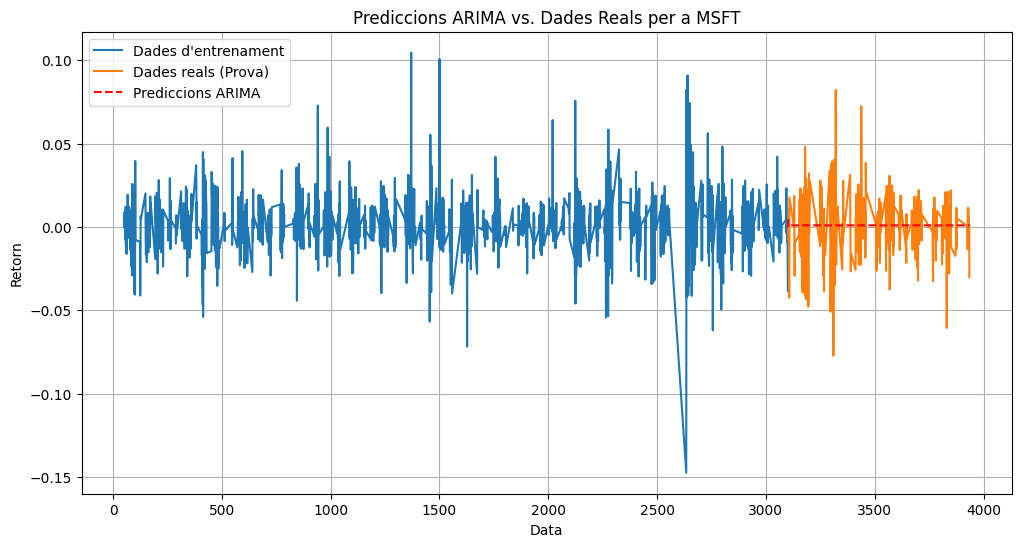


Aplicant model GARCH per a MSFT...
Resum del model GARCH per a MSFT (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  MSFT_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4580.36', "Distribution:      Standardized Student's t   AIC:                          -9150.73", 'Method:                  Maximum Likelihood   BIC:                          -9123.87', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:21   Df Model:                            1']


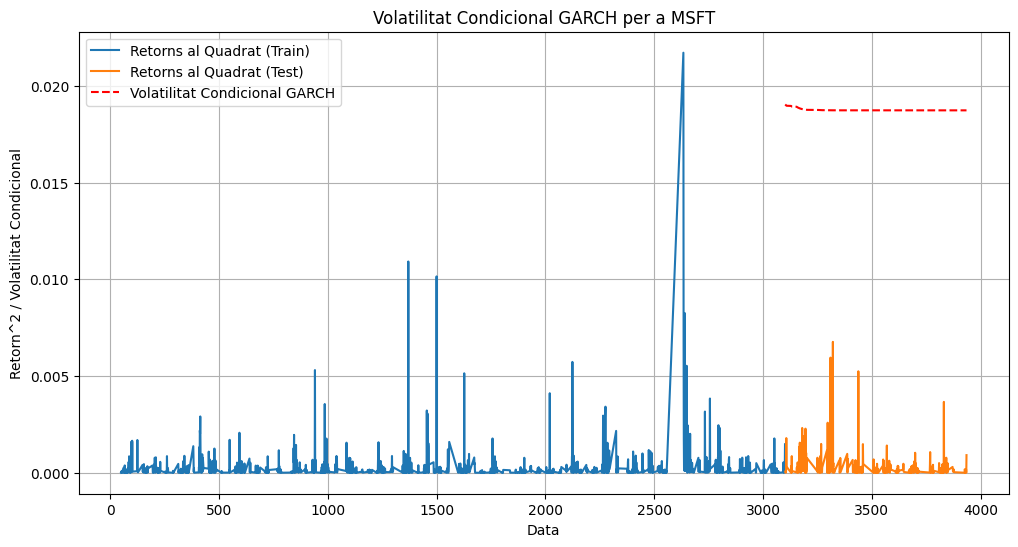


--- Avaluació de la Predicció de Direcció per a MSFT ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5000
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.50      1.00      0.67       199

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.33       398


GARCH (Binaritzat) - Accuracy: 0.5000
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.50      1.00      0.67       199

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.33       398



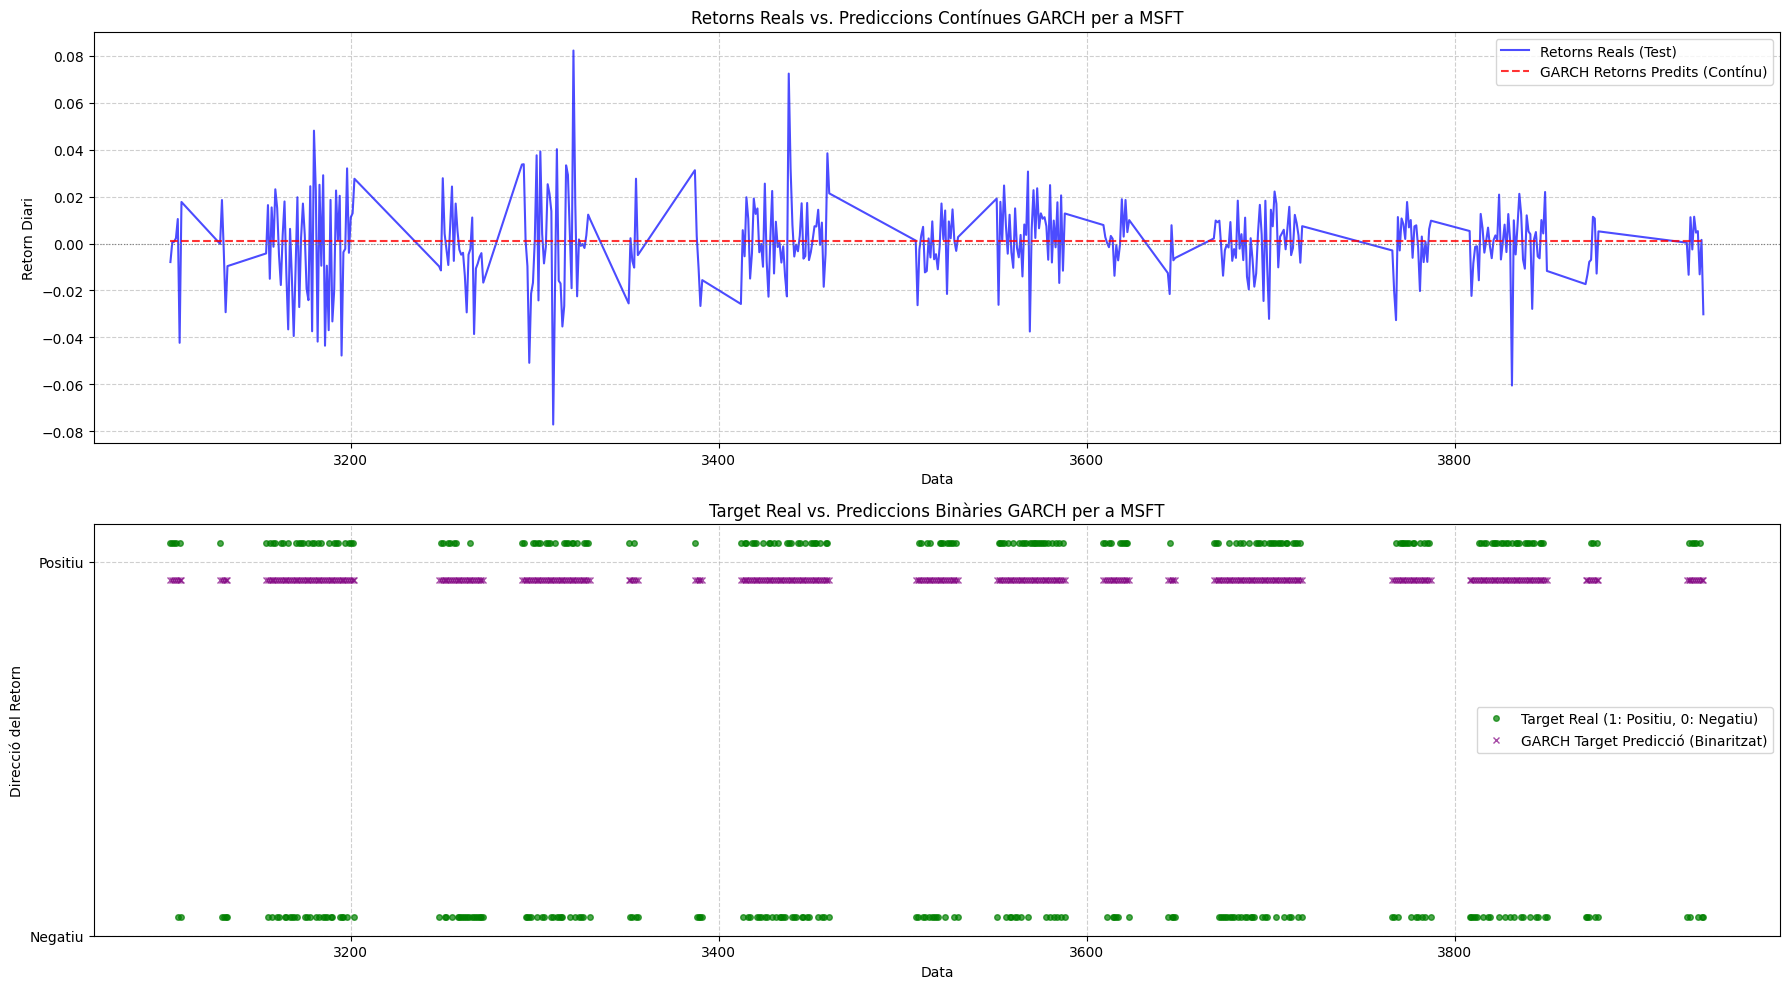


--- Aplicant models per a l'actiu: NVDA ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a NVDA...
Resum del model ARIMA per a NVDA (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            NVDA_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                3383.570', 'Date:                Sun, 15 Jun 2025   AIC                          -6759.139', 'Time:                        17:03:22   BIC                          -6737.656', 'Sample:                             0   HQIC                         -6751.159', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '===

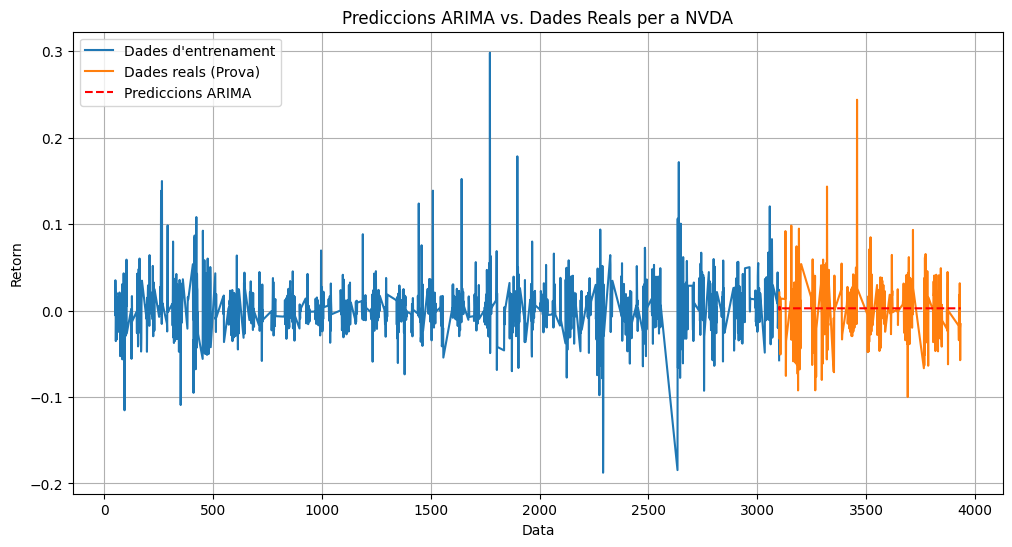


Aplicant model GARCH per a NVDA...
Resum del model GARCH per a NVDA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  NVDA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                3327.43', "Distribution:      Standardized Student's t   AIC:                          -6644.86", 'Method:                  Maximum Likelihood   BIC:                          -6618.00', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:23   Df Model:                            1']


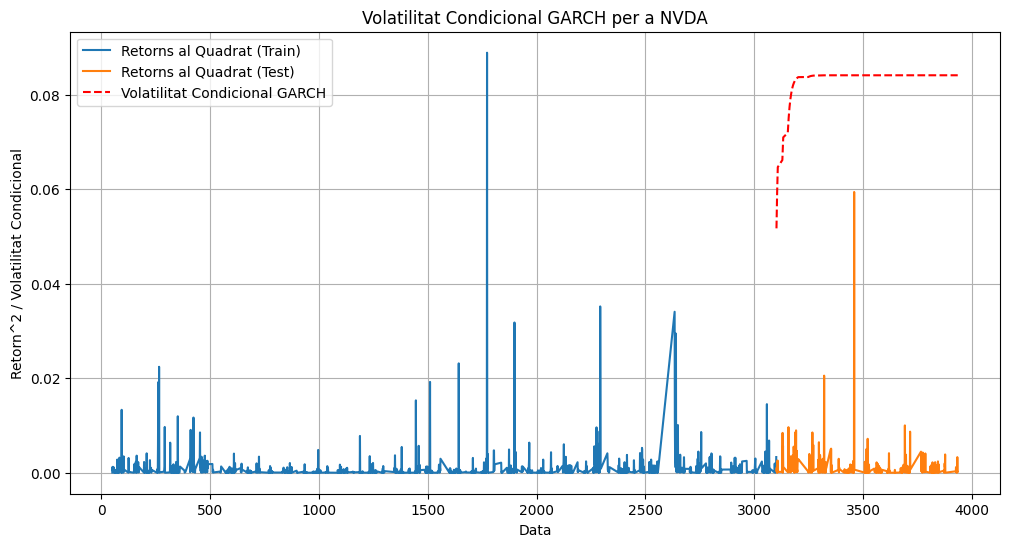


--- Avaluació de la Predicció de Direcció per a NVDA ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5126
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.51      1.00      0.68       204

    accuracy                           0.51       398
   macro avg       0.26      0.50      0.34       398
weighted avg       0.26      0.51      0.35       398


GARCH (Binaritzat) - Accuracy: 0.5126
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       194
           1       0.51      1.00      0.68       204

    accuracy                           0.51       398
   macro avg       0.26      0.50      0.34       398
weighted avg       0.26      0.51      0.35       398



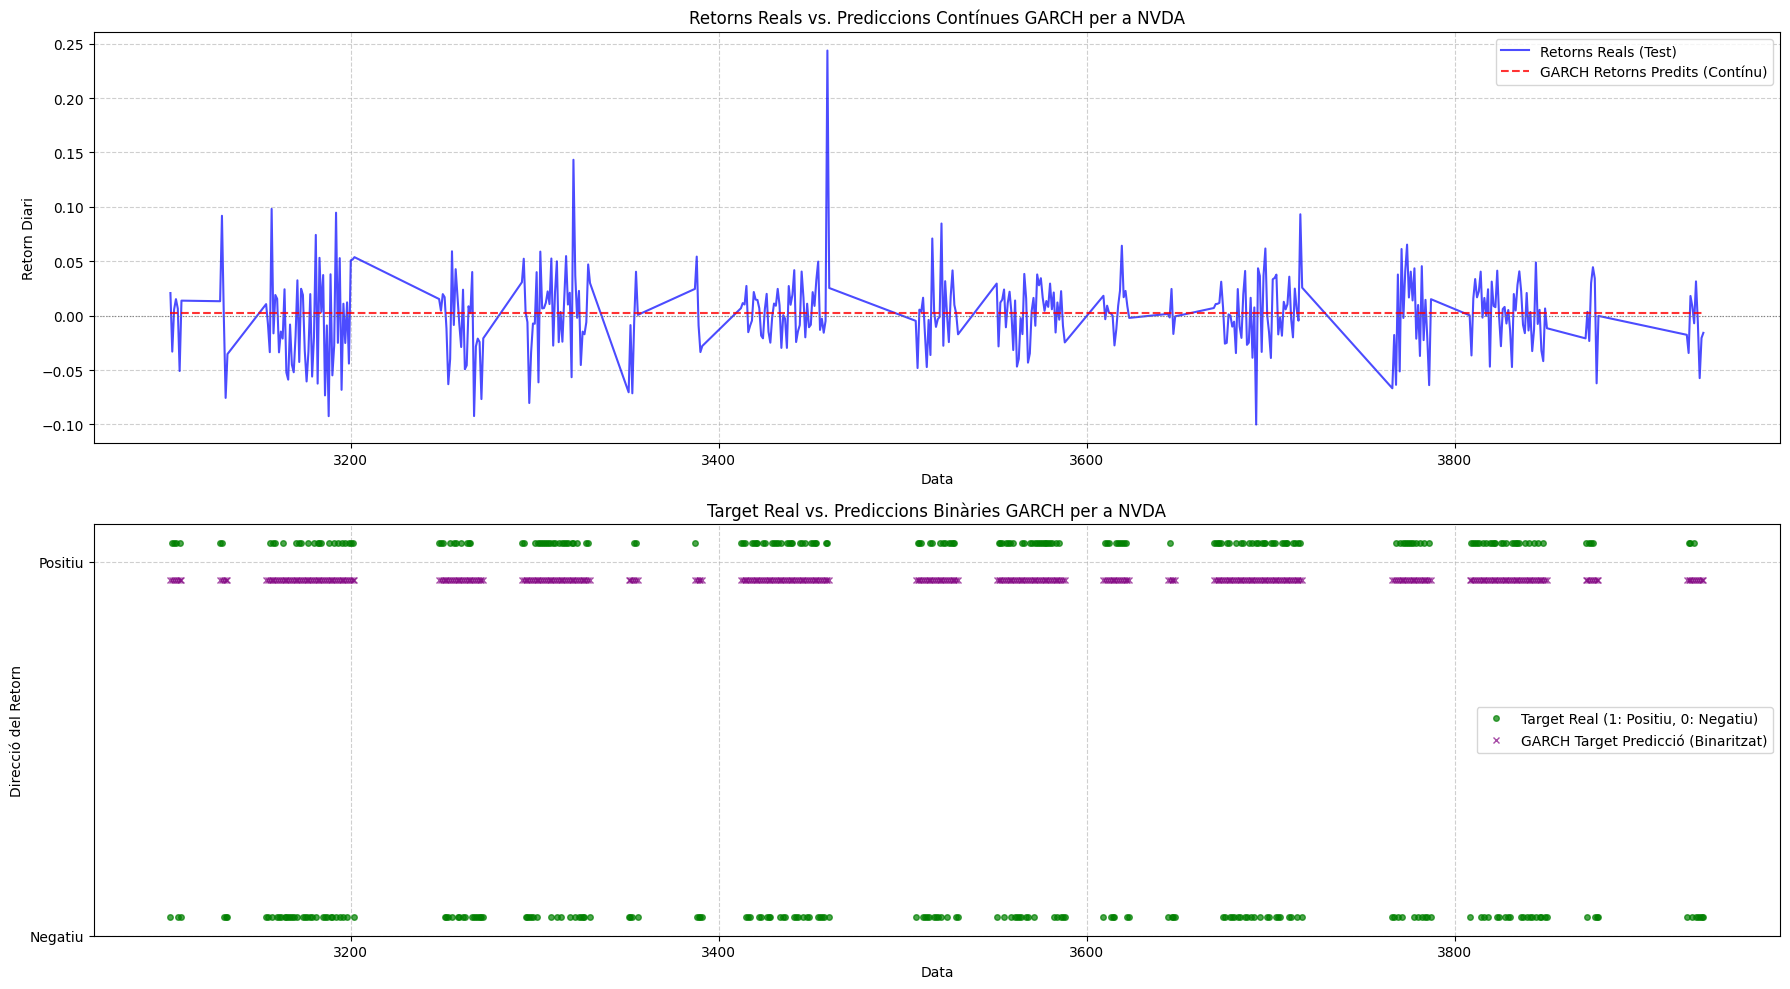


--- Aplicant models per a l'actiu: SAN ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a SAN...
Resum del model ARIMA per a SAN (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:             SAN_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                3691.797', 'Date:                Sun, 15 Jun 2025   AIC                          -7375.595', 'Time:                        17:03:26   BIC                          -7354.111', 'Sample:                             0   HQIC                         -7367.615', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '======

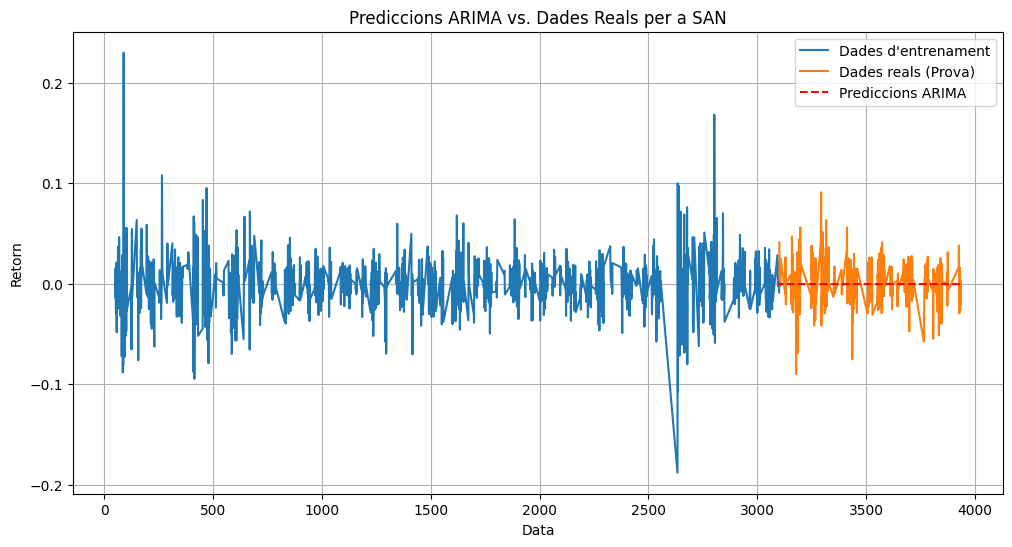


Aplicant model GARCH per a SAN...
Resum del model GARCH per a SAN (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   SAN_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                2607.39', "Distribution:      Standardized Student's t   AIC:                          -5204.79", 'Method:                  Maximum Likelihood   BIC:                          -5177.93', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:26   Df Model:                            1']


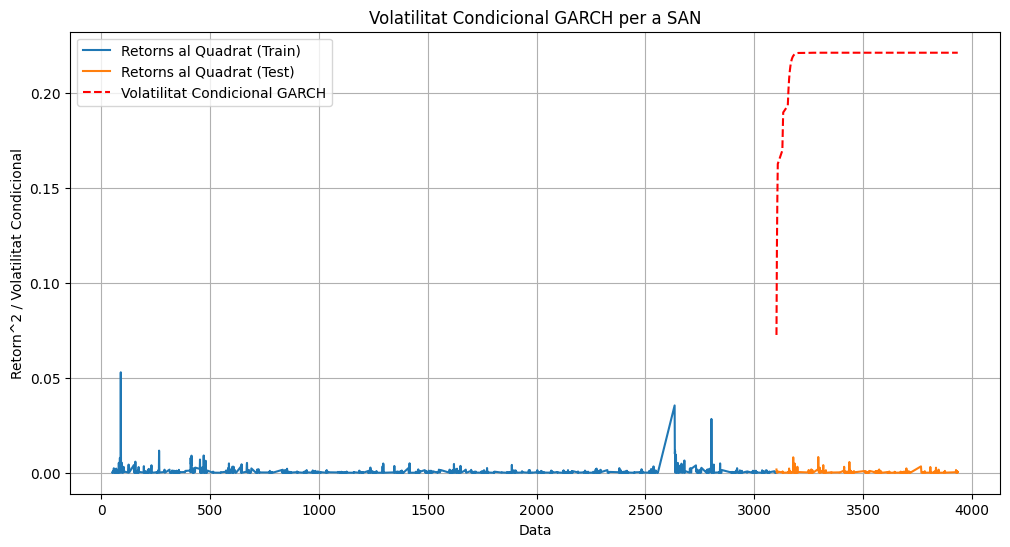


--- Avaluació de la Predicció de Direcció per a SAN ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5176
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       204
           1       1.00      0.01      0.02       194

    accuracy                           0.52       398
   macro avg       0.76      0.51      0.35       398
weighted avg       0.75      0.52      0.36       398


GARCH (Binaritzat) - Accuracy: 0.5126
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       204
           1       0.00      0.00      0.00       194

    accuracy                           0.51       398
   macro avg       0.26      0.50      0.34       398
weighted avg       0.26      0.51      0.35       398



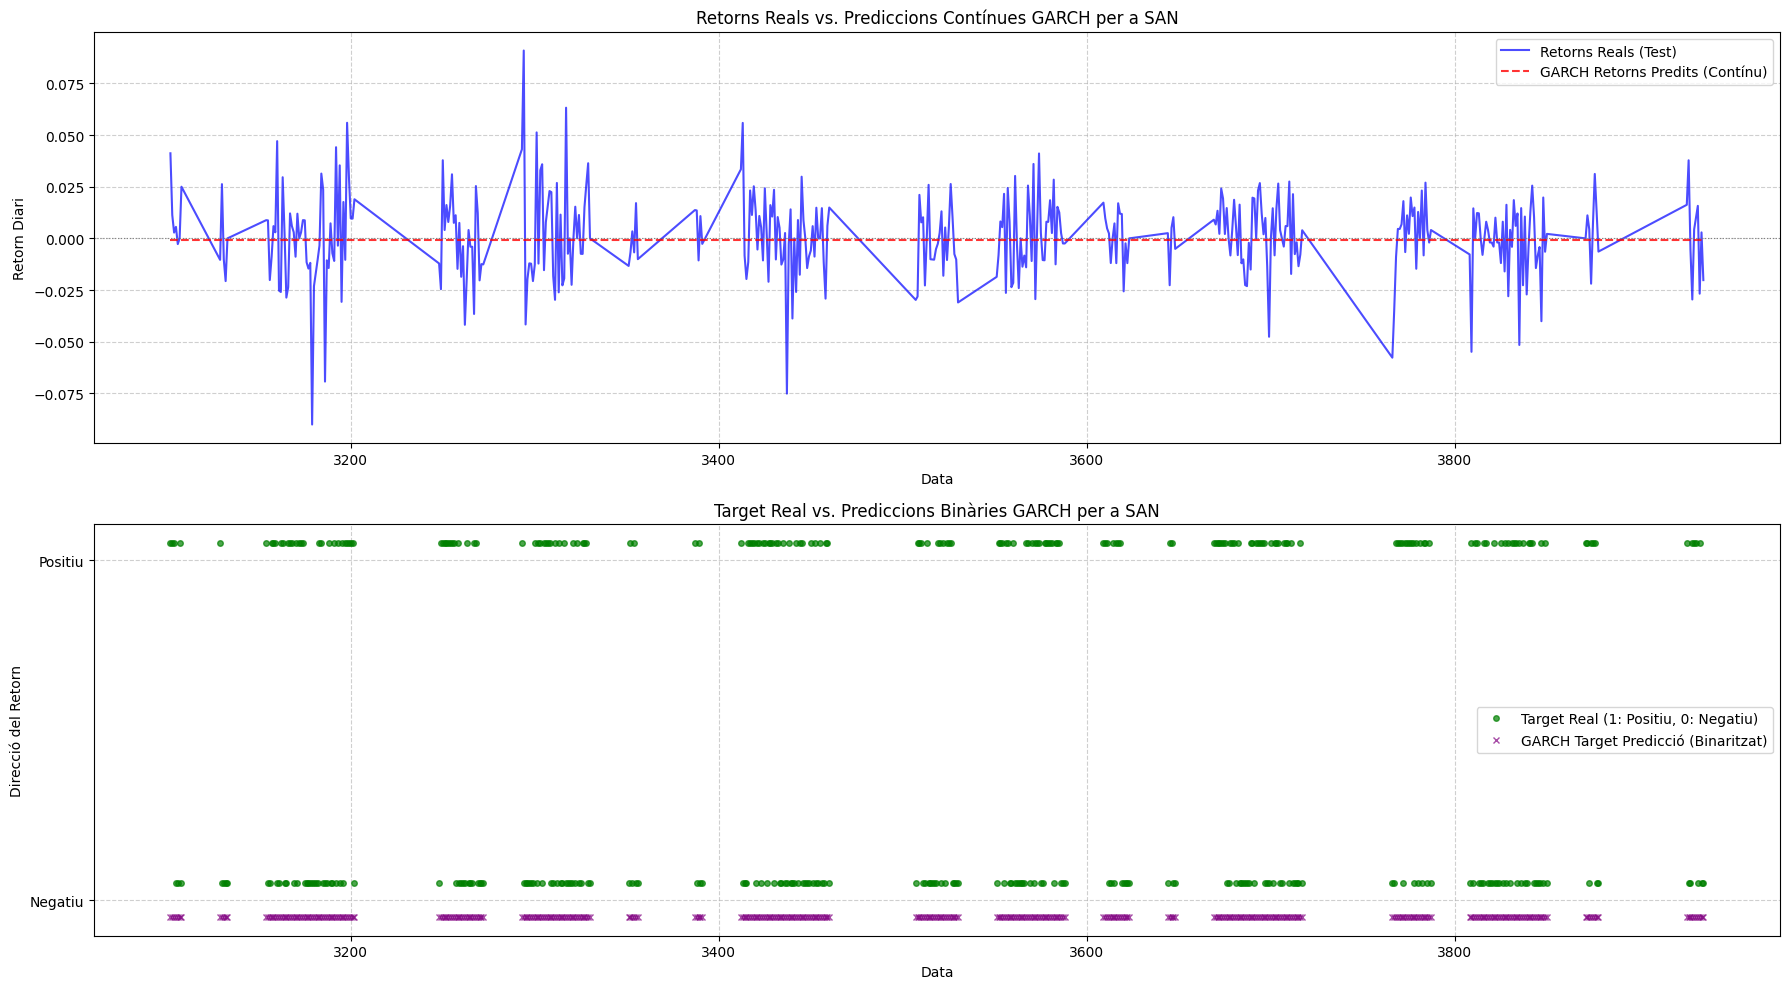


--- Aplicant models per a l'actiu: TEF ---
Grandària de les dades d'entrenament: 1589
Grandària de les dades de prova: 398
Grandària del target de prova (y_test): 398

Aplicant model ARIMA per a TEF...
Resum del model ARIMA per a TEF (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:             TEF_return   No. Observations:                 1589', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                4040.955', 'Date:                Sun, 15 Jun 2025   AIC                          -8073.909', 'Time:                        17:03:27   BIC                          -8052.426', 'Sample:                             0   HQIC                         -8065.929', '                               - 1589                                         ', 'Covariance Type:                  opg                                         ', '======

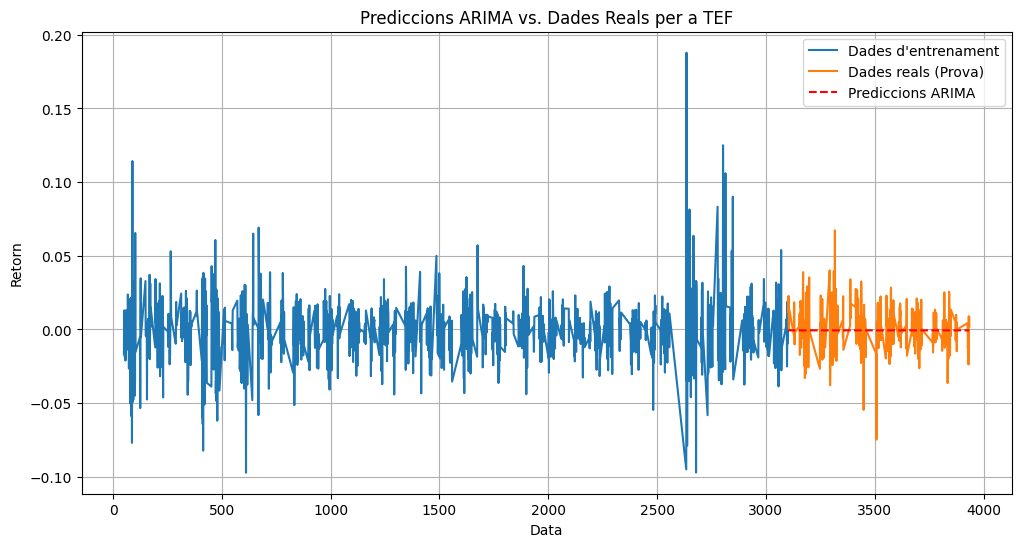


Aplicant model GARCH per a TEF...
Resum del model GARCH per a TEF (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                   TEF_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:                4303.12', "Distribution:      Standardized Student's t   AIC:                          -8596.23", 'Method:                  Maximum Likelihood   BIC:                          -8569.38', '                                              No. Observations:                 1589', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1588', 'Time:                              17:03:28   Df Model:                            1']


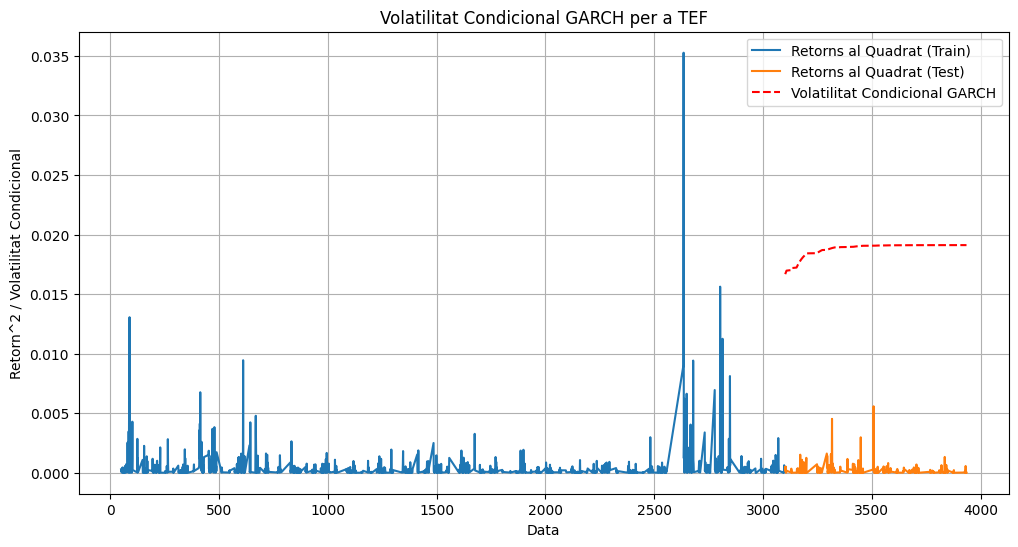


--- Avaluació de la Predicció de Direcció per a TEF ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.5553
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       221
           1       0.00      0.00      0.00       177

    accuracy                           0.56       398
   macro avg       0.28      0.50      0.36       398
weighted avg       0.31      0.56      0.40       398


GARCH (Binaritzat) - Accuracy: 0.5553
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       221
           1       0.00      0.00      0.00       177

    accuracy                           0.56       398
   macro avg       0.28      0.50      0.36       398
weighted avg       0.31      0.56      0.40       398



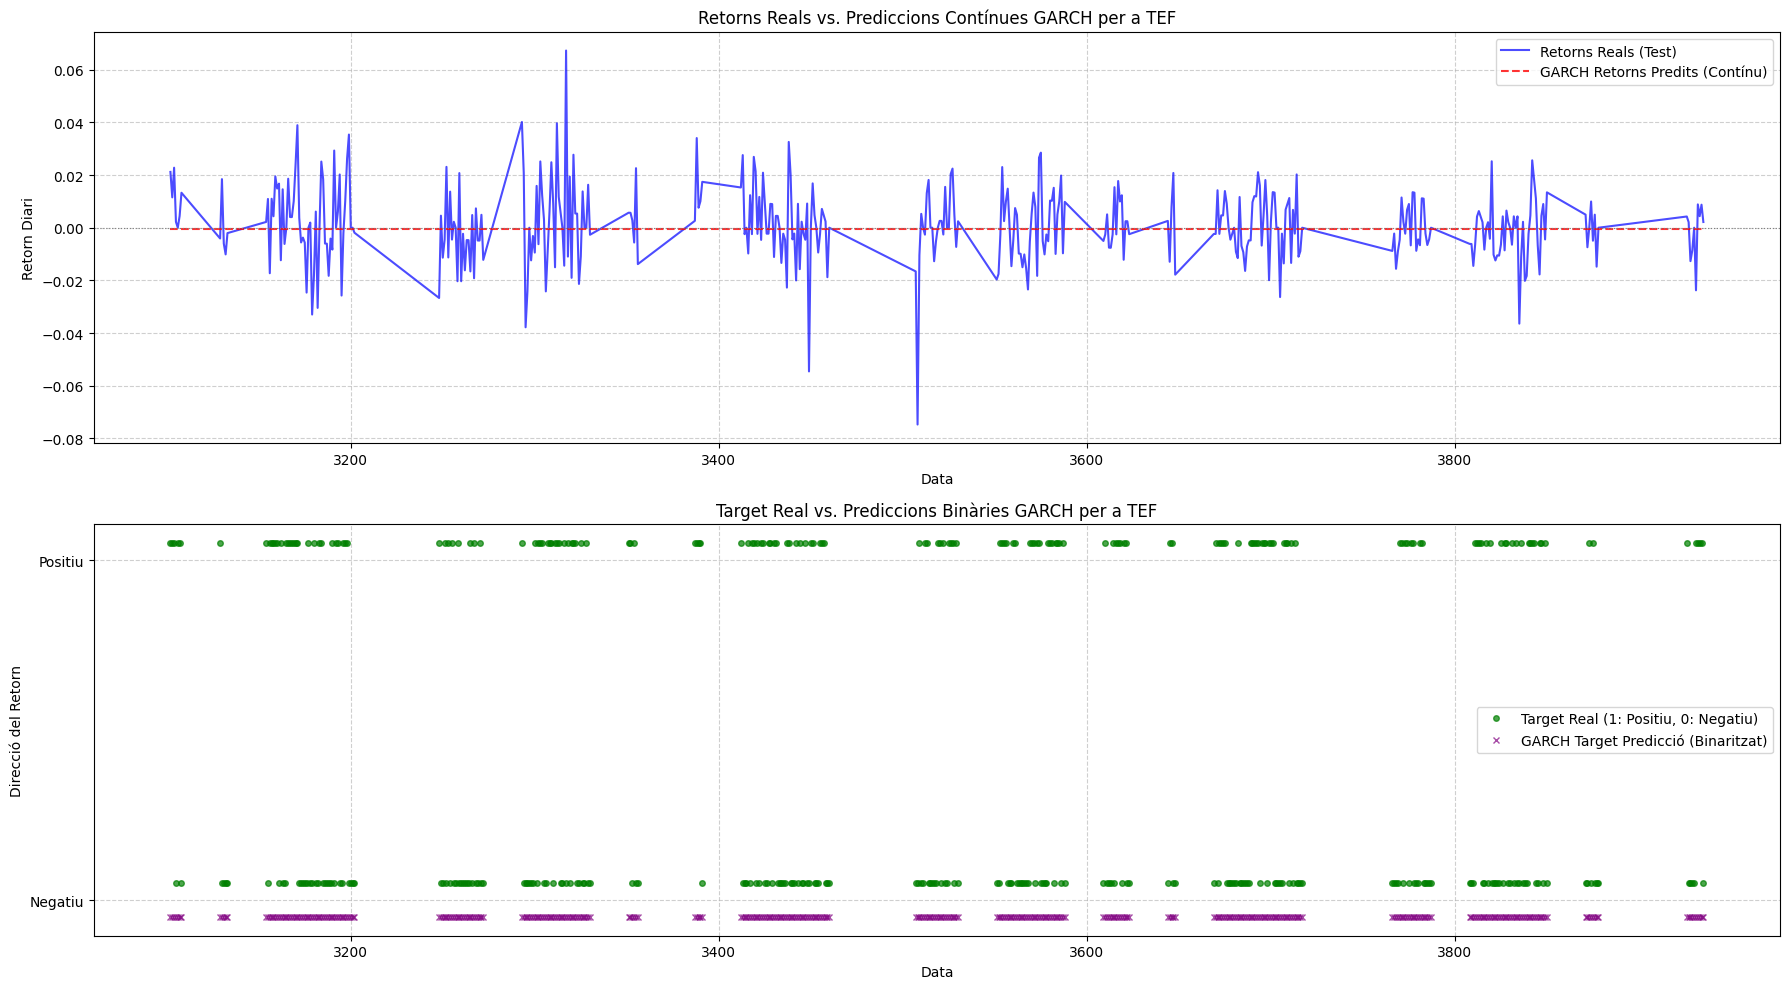


--- Aplicant models per a l'actiu: TSLA ---
Grandària de les dades d'entrenament: 1542
Grandària de les dades de prova: 386
Grandària del target de prova (y_test): 386

Aplicant model ARIMA per a TSLA...
Resum del model ARIMA per a TSLA (primeres línies):
['                               SARIMAX Results                                ', '==============================================================================', 'Dep. Variable:            TSLA_return   No. Observations:                 1542', 'Model:                 ARIMA(1, 0, 1)   Log Likelihood                2940.965', 'Date:                Sun, 15 Jun 2025   AIC                          -5873.930', 'Time:                        17:03:29   BIC                          -5852.566', 'Sample:                             0   HQIC                         -5865.982', '                               - 1542                                         ', 'Covariance Type:                  opg                                         ', '===

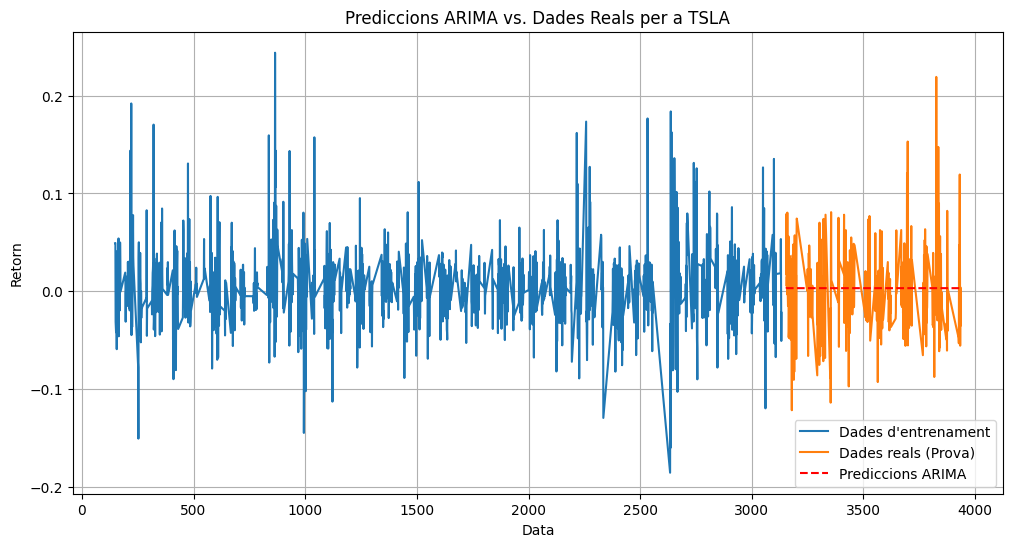


Aplicant model GARCH per a TSLA...
Resum del model GARCH per a TSLA (primeres línies):
['                        Constant Mean - GARCH Model Results                         ', '====================================================================================', 'Dep. Variable:                  TSLA_return   R-squared:                       0.000', 'Mean Model:                   Constant Mean   Adj. R-squared:                  0.000', 'Vol Model:                            GARCH   Log-Likelihood:               -1832.20', "Distribution:      Standardized Student's t   AIC:                           3674.40", 'Method:                  Maximum Likelihood   BIC:                           3701.10', '                                              No. Observations:                 1542', 'Date:                      Sun, Jun 15 2025   Df Residuals:                     1541', 'Time:                              17:03:29   Df Model:                            1']


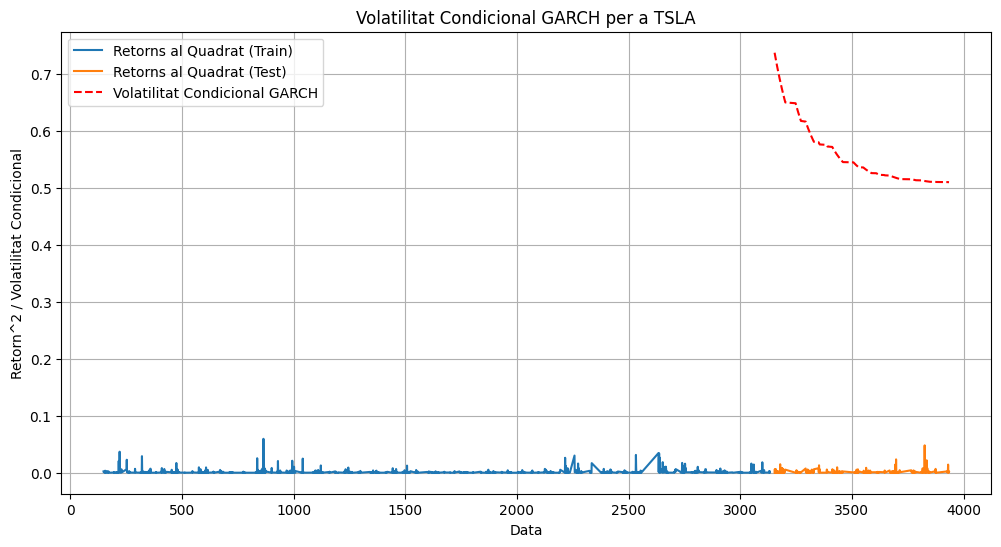


--- Avaluació de la Predicció de Direcció per a TSLA ---

--- Mètriques de Classificació per a la Direcció del Retorn ---
ARIMA (Binaritzat) - Accuracy: 0.4534
ARIMA Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       211
           1       0.45      1.00      0.62       175

    accuracy                           0.45       386
   macro avg       0.23      0.50      0.31       386
weighted avg       0.21      0.45      0.28       386


GARCH (Binaritzat) - Accuracy: 0.5466
GARCH Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       211
           1       0.00      0.00      0.00       175

    accuracy                           0.55       386
   macro avg       0.27      0.50      0.35       386
weighted avg       0.30      0.55      0.39       386



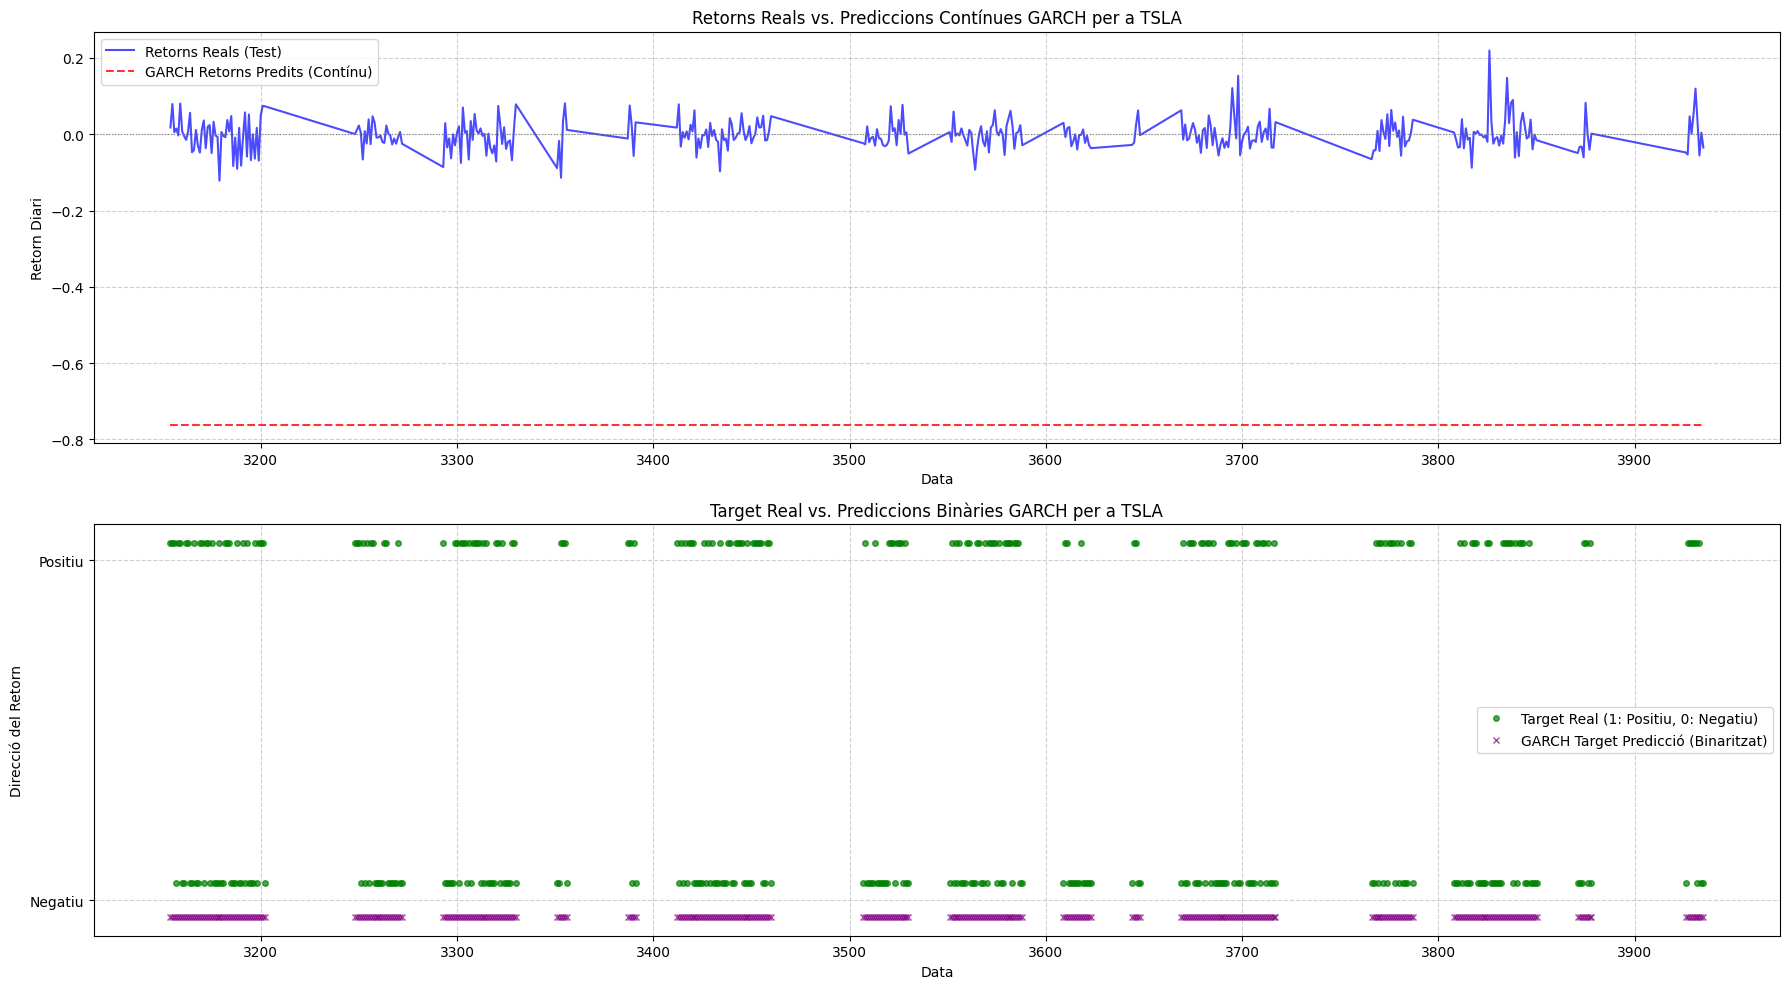


--- Finalitzada l'aplicació i avaluació de models ARIMA i GARCH ---


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Importa les llibreries que ja fas servir
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

# Importa les mètriques de sklearn per a avaluació de classificació
from sklearn.metrics import accuracy_score, classification_report

# Per suprimir advertiments, especialment de la convergència dels models
warnings.filterwarnings("ignore")

print("\n--- Iniciant l'aplicació de models ARIMA i GARCH ---")

# --- SUPOSICIONS CLAU ---
# df_clean_dict: Un diccionari on les claus són els noms dels actius
#              i els valors són DataFrames que contenen la columna '{asset}_return'.
# assets_valids: Una llista de noms d'actius que vols processar.


if not df_clean_dict or not assets_valids:
    print("Error: df_clean_dict o assets_valids no estan definits o estan buits.")
    print("Assegura't que les cel·les anteriors del notebook s'han executat correctament.")
else:
    for asset in assets_valids:
        print(f"\n--- Aplicant models per a l'actiu: {asset} ---")

        # Seleccionem la sèrie de retorns i la variable target binària per a l'actiu
        returns_col_name = f'{asset}_return'
        target_col_name = f'{asset}_target'

        if returns_col_name not in df_clean_dict[asset].columns or target_col_name not in df_clean_dict[asset].columns:
            print(f"Error: Les columnes '{returns_col_name}' o '{target_col_name}' no es troben per a l'actiu {asset}. Saltant.")
            continue

        returns = df_clean_dict[asset][returns_col_name]
        full_target = df_clean_dict[asset][target_col_name] # La variable target binària real

        # Dividim les dades en entrenament i prova (80% entrenament, 20% prova)
        train_size = int(len(returns) * 0.8)
        train_data, test_data = returns[0:train_size], returns[train_size:]
        y_test = full_target[train_size:] # Target binari real per al conjunt de test

        print(f"Grandària de les dades d'entrenament: {len(train_data)}")
        print(f"Grandària de les dades de prova: {len(test_data)}")
        print(f"Grandària del target de prova (y_test): {len(y_test)}")


        # Inicialitzem les prediccions a None per gestionar errors
        arima_predictions_continuous = None
        garch_predictions_continuous = None

        # ----------------------------------------------------
        # Model ARIMA
        # ----------------------------------------------------
        print(f"\nAplicant model ARIMA per a {asset}...")
        try:
            arima_model = ARIMA(train_data, order=(1, 0, 1))
            arima_results = arima_model.fit()
            print(f"Resum del model ARIMA per a {asset} (primeres línies):\n{arima_results.summary().as_text().splitlines()[0:10]}") # Limitem el summary

            start_index = len(train_data)
            end_index = len(returns) - 1
            # Assegurem que les prediccions s'alineen amb l'índex de test_data/y_test
            arima_predictions_continuous = arima_results.predict(start=start_index, end=end_index, dynamic=False)
            arima_predictions_continuous.index = test_data.index # Ajustem l'índex

            rmse_arima = np.sqrt(np.mean((arima_predictions_continuous - test_data)**2))
            print(f"RMSE (ARIMA) per a {asset}: {rmse_arima:.4f}")

            # Visualització de les prediccions ARIMA (mantingut del teu codi original)
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data, label='Dades d\'entrenament')
            plt.plot(test_data.index, test_data, label='Dades reals (Prova)')
            plt.plot(arima_predictions_continuous.index, arima_predictions_continuous, label='Prediccions ARIMA', color='red', linestyle='--')
            plt.title(f'Prediccions ARIMA vs. Dades Reals per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model ARIMA per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}")

        # ----------------------------------------------------
        # Model GARCH
        # ----------------------------------------------------
        print(f"\nAplicant model GARCH per a {asset}...")
        try:
            # Per a GARCH, s'utilitzen normalment retorns no escalats o escalats per 100 si són molt petits
            # Per coherència amb els retorns que ja tens, utilitzem train_data directament.
            # Recorda que garch_model.fit pot necessitar un .loc per evitar missatges de FutureWarning
            garch_model = arch_model(train_data.loc[train_data.index], vol='Garch', p=1, q=1, dist='StudentsT')
            garch_results = garch_model.fit(disp='off')
            print(f"Resum del model GARCH per a {asset} (primeres línies):\n{garch_results.summary().as_text().splitlines()[0:10]}") # Limitem el summary

            # Predicció del mean (retorn esperat) de GARCH per a la binarització
            # El forecast de GARCH inclou la predicció de la mitjana (mean)
            # Asegurem que l'horitzó sigui la longitud del test_data
            forecasts = garch_results.forecast(horizon=len(test_data), reindex=False)

            # La predicció de la mitjana condicional (retorn esperat) és el que ens interessa
            # per a la binarització. Està sota `mean`.
            # forecasts.mean.iloc[-1] agafa la darrera fila, que conté les prediccions per a l'horitzó complet.
            garch_predictions_continuous = pd.Series(forecasts.mean.iloc[-1].values, index=test_data.index)
            
            # --- NOTA IMPORTANT sobre la visualització GARCH original ---
            # El teu codi original de GARCH visualitzava la volatilitat condicional (np.sqrt(forecasts.variance)).
            # Per a la binarització i comparació de direcció, necessitem la predicció del RETORN (mean).
            # La visualització de volatilitat és correcta per al seu propòsit, la mantenim.
            garch_conditional_volatility = np.sqrt(forecasts.variance.dropna().iloc[0]) # Manté el teu codi original per volatilitat
            garch_conditional_volatility.index = test_data.index[:len(garch_conditional_volatility)]

            # Visualització de la volatilitat predita pel GARCH (mantingut del teu codi original)
            plt.figure(figsize=(12, 6))
            plt.plot(train_data.index, train_data**2, label='Retorns al Quadrat (Train)') # Proxy de volatilitat real
            plt.plot(test_data.index, test_data**2, label='Retorns al Quadrat (Test)') # Proxy de volatilitat real
            plt.plot(garch_conditional_volatility.index, garch_conditional_volatility, label='Volatilitat Condicional GARCH', color='red', linestyle='--')
            plt.title(f'Volatilitat Condicional GARCH per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn^2 / Volatilitat Condicional')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error en aplicar el model GARCH per a {asset}: {e}")
            print(f"Detall de l'error: {e.args}")

        # ------------------------------------------------------------------
        # Binarització i Avaluació de Prediccions de Direcció (ARIMA i GARCH)
        # ------------------------------------------------------------------
        print(f"\n--- Avaluació de la Predicció de Direcció per a {asset} ---")

        # Assegurem que tenim prediccions abans de continuar
        if arima_predictions_continuous is not None and garch_predictions_continuous is not None:
            # Binaritzar les prediccions contínues
            arima_pred_binary = (arima_predictions_continuous > 0).astype(int)
            garch_pred_binary = (garch_predictions_continuous > 0).astype(int)

            # Comprovar si hi ha desajustaments de longitud, si els índexs no quadren
            # Això hauria de ser menys comú ara que ajustem l'índex al fer la predicció
            if len(arima_pred_binary) != len(y_test):
                print(f"AVÍS: La longitud de les prediccions ARIMA ({len(arima_pred_binary)}) no coincideix amb el y_test ({len(y_test)}). Ajustant.")
                # Aquesta línia assegura que ambdues sèries tinguin la mateixa longitud i índex.
                # Potenciar error si les dates no coincideixen exactament.
                # Considera si cal fer un reindex. De moment, només agafem la part que coincideix.
                arima_pred_binary = arima_pred_binary.reindex(y_test.index).fillna(0) # o amb un mètode de interpolació
                garch_pred_binary = garch_pred_binary.reindex(y_test.index).fillna(0) # o amb un mètode de interpolació

            # Càlcul de mètriques
            print("\n--- Mètriques de Classificació per a la Direcció del Retorn ---")
            
            # ARIMA
            arima_accuracy = accuracy_score(y_test, arima_pred_binary)
            print(f"ARIMA (Binaritzat) - Accuracy: {arima_accuracy:.4f}")
            print("ARIMA Classification Report:")
            print(classification_report(y_test, arima_pred_binary, zero_division=0))

            # GARCH
            garch_accuracy = accuracy_score(y_test, garch_pred_binary)
            print(f"\nGARCH (Binaritzat) - Accuracy: {garch_accuracy:.4f}")
            print("GARCH Classification Report:")
            print(classification_report(y_test, garch_pred_binary, zero_division=0))

            # --- Visualització Comparativa: Retorns i Prediccions Binaritzades GARCH ---
            plt.figure(figsize=(18, 10))

            # Subgràfic 1: Retorns Reals vs. Prediccions Contínues de GARCH
            plt.subplot(2, 1, 1)
            plt.plot(test_data.index, test_data, label='Retorns Reals (Test)', color='blue', alpha=0.7)
            # Assegura't que les prediccions contínues tenen la mateixa longitud que test_data
            if len(garch_predictions_continuous) == len(test_data):
                plt.plot(garch_predictions_continuous.index, garch_predictions_continuous, label='GARCH Retorns Predits (Contínu)', color='red', linestyle='--', alpha=0.8)
            else:
                print(f"AVÍS: Les prediccions GARCH contínues ({len(garch_predictions_continuous)}) i test_data ({len(test_data)}) no coincideixen en longitud per al gràfic de retorns.")
            plt.axhline(0, color='gray', linestyle=':', linewidth=0.8) # Línia del zero
            plt.title(f'Retorns Reals vs. Prediccions Contínues GARCH per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Retorn Diari')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)

            # Subgràfic 2: Target Real vs. Prediccions Binàries de GARCH
            plt.subplot(2, 1, 2)
            # Utilitzem un petit offset per visualitzar millor els punts que es superposarien
            plt.plot(y_test.index, y_test + 0.05, 'o', label='Target Real (1: Positiu, 0: Negatiu)', color='green', markersize=4, alpha=0.7)
            plt.plot(garch_pred_binary.index, garch_pred_binary - 0.05, 'x', label='GARCH Target Predicció (Binaritzat)', color='purple', markersize=4, alpha=0.7)
            plt.yticks([0, 1], ['Negatiu', 'Positiu']) # Etiquetes per 0 i 1
            plt.title(f'Target Real vs. Prediccions Binàries GARCH per a {asset}')
            plt.xlabel('Data')
            plt.ylabel('Direcció del Retorn')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)

            plt.tight_layout()
            plt.show()

        else:
            print(f"No es van poder generar prediccions d'ARIMA o GARCH per a {asset}. No s'avaluen les mètriques de direcció.")

print("\n--- Finalitzada l'aplicació i avaluació de models ARIMA i GARCH ---")


--- Iniciant anàlisi de correlacions entre actius ---

Retorns consolidats per a 15 actius. Mostra del DataFrame de retorns:
         AAPL       AMS      AMZN      BBVA     GOOGL      GSPC      IBEX  \
149  0.017881 -0.006061  0.018492  0.048327  0.011468  0.022023  0.031963   
150  0.000306  0.027439  0.019572  0.006383 -0.001183 -0.004796  0.003322   
151  0.004009 -0.056380  0.042150 -0.002819  0.033665  0.006051 -0.002585   
152 -0.004867 -0.031447  0.001960  0.002827  0.003515 -0.001269 -0.000304   
153 -0.006152 -0.009740  0.003833 -0.007752 -0.015509 -0.003704 -0.017426   

         IXIC       JPM       LLY      MSFT      NVDA       SAN       TEF  \
149  0.018034  0.033764  0.020787  0.020147 -0.001088  0.063430  0.032876   
150 -0.005158 -0.013449  0.006604 -0.006457 -0.026144  0.008100 -0.001132   
151  0.008780  0.005112  0.005467 -0.016437  0.042506 -0.008766 -0.004532   
152 -0.004562 -0.000484  0.001903 -0.013991  0.012876  0.011791  0.002703   
153 -0.002002 -0.020112  0

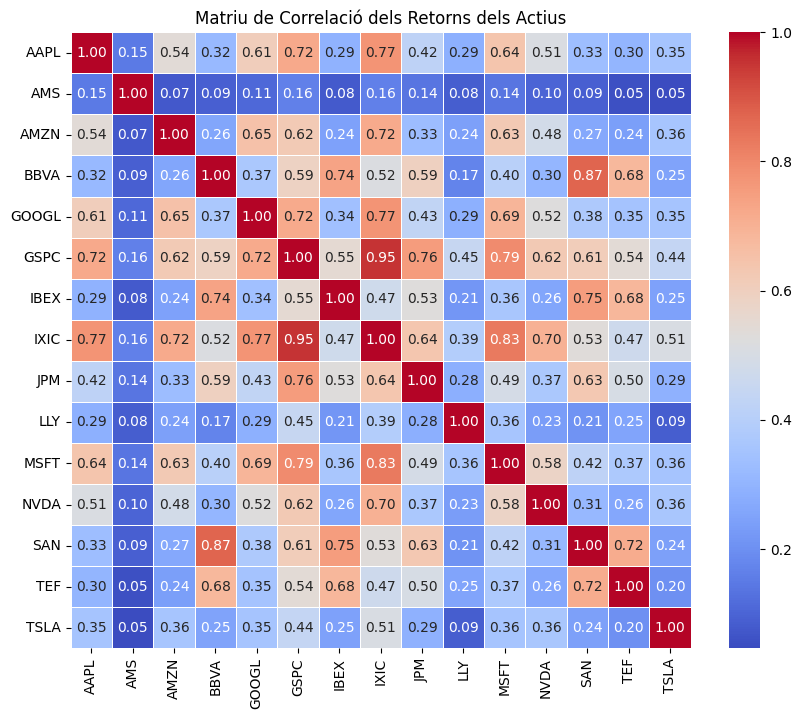


Calculant la Correlació Mòbil entre AAPL i AMS (finestra de 30 dies)...


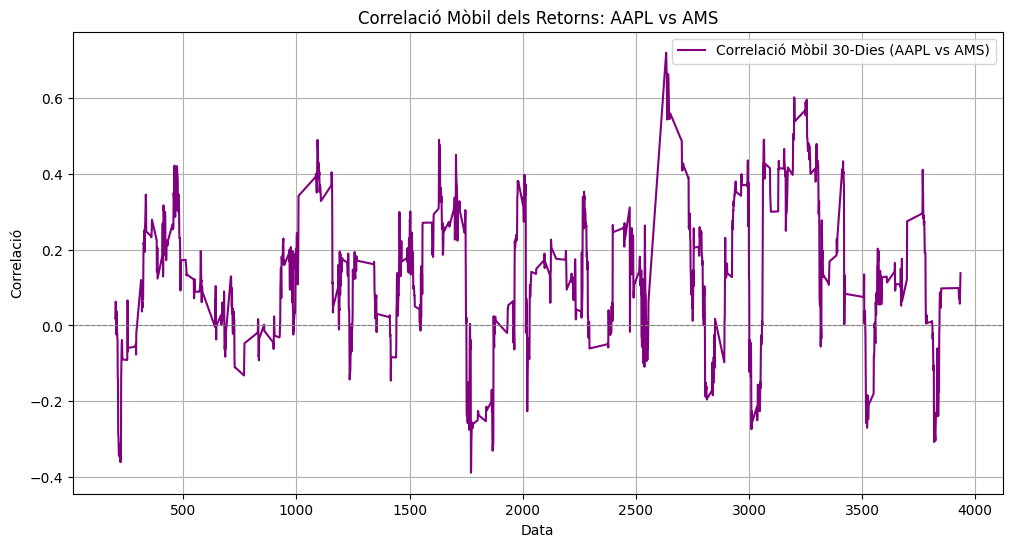


--- Anàlisi de correlacions finalitzada ---


In [9]:

warnings.filterwarnings("ignore")

print("\n--- Iniciant anàlisi de correlacions entre actius ---")

# --- SUPOSICIONS CLAU ---
# df_clean_dict: Un diccionari on les claus són els noms dels actius
#              i els valors són DataFrames que contenen la columna '{asset}_return'.
# assets_valids: Una llista de noms d'actius que vols processar.




if not df_clean_dict or not assets_valids:
    print("Error: df_clean_dict o assets_valids no estan definits o estan buits.")
    print("Assegura't que les cel·les anteriors del notebook s'han executat correctament.")
else:
    # 1. Consolidar els Retorns en un únic DataFrame
    all_returns = pd.DataFrame()
    
    for asset in assets_valids:
        returns_col_name = f'{asset}_return'
        if returns_col_name in df_clean_dict[asset].columns:
            # Seleccionem la columna de retorns i la renombren per a la fusió
            all_returns = pd.concat([all_returns, df_clean_dict[asset][returns_col_name].rename(asset)], axis=1)
        else:
            print(f"AVÍS: La columna '{returns_col_name}' no es troba per a l'actiu {asset}.")

    # Eliminar files amb valors NaN que puguin sorgir de la fusió si els rangs de dates no coincideixen
    all_returns.dropna(inplace=True)

    if all_returns.empty:
        print("Error: No es van poder consolidar retorns vàlids per a l'anàlisi de correlació.")
    else:
        print(f"\nRetorns consolidats per a {len(all_returns.columns)} actius. Mostra del DataFrame de retorns:")
        print(all_returns.head())

        # 2. Calcular la Matriu de Correlació (Correlació Estàtica)
        correlation_matrix = all_returns.corr()
        print("\nMatriu de Correlació (Estàtica) dels Retorns:")
        print(correlation_matrix)

        # 3. Visualitzar la Matriu de Correlació amb un Heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Matriu de Correlació dels Retorns dels Actius')
        plt.show()

        # 4. Analitzar la Correlació Mòbil (Rolling Correlation)
        # Escolliu un parell d'actius per analitzar la correlació mòbil
        if len(assets_valids) >= 2:
            asset1 = assets_valids[0]
            asset2 = assets_valids[1]

            print(f"\nCalculant la Correlació Mòbil entre {asset1} i {asset2} (finestra de 30 dies)...")
            
            # Assegurem que les sèries són DataFrame per aplicar rolling
            # i que no tenen NaN si és possible
            pair_data = all_returns[[asset1, asset2]].copy()
            
            # Calcula la correlació mòbil (p.ex., amb una finestra de 30 dies)
            rolling_corr = pair_data[asset1].rolling(window=30).corr(pair_data[asset2])

            plt.figure(figsize=(12, 6))
            plt.plot(rolling_corr.index, rolling_corr, label=f'Correlació Mòbil 30-Dies ({asset1} vs {asset2})', color='purple')
            plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            plt.title(f'Correlació Mòbil dels Retorns: {asset1} vs {asset2}')
            plt.xlabel('Data')
            plt.ylabel('Correlació')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Pots repetir això per altres parelles o fer un gràfic amb múltiples línies

        else:
            print("Es necessiten almenys dos actius per calcular la correlació mòbil.")

print("\n--- Anàlisi de correlacions finalitzada ---")


--- Iniciant anàlisi de Components Principals (PCA) dels retorns ---

Retorns consolidats per a PCA per a 15 actius. Mostra (primeres 5 files):
         AAPL       AMS      AMZN      BBVA     GOOGL      GSPC      IBEX  \
149  0.017881 -0.006061  0.018492  0.048327  0.011468  0.022023  0.031963   
150  0.000306  0.027439  0.019572  0.006383 -0.001183 -0.004796  0.003322   
151  0.004009 -0.056380  0.042150 -0.002819  0.033665  0.006051 -0.002585   
152 -0.004867 -0.031447  0.001960  0.002827  0.003515 -0.001269 -0.000304   
153 -0.006152 -0.009740  0.003833 -0.007752 -0.015509 -0.003704 -0.017426   

         IXIC       JPM       LLY      MSFT      NVDA       SAN       TEF  \
149  0.018034  0.033764  0.020787  0.020147 -0.001088  0.063430  0.032876   
150 -0.005158 -0.013449  0.006604 -0.006457 -0.026144  0.008100 -0.001132   
151  0.008780  0.005112  0.005467 -0.016437  0.042506 -0.008766 -0.004532   
152 -0.004562 -0.000484  0.001903 -0.013991  0.012876  0.011791  0.002703   
153 -0.

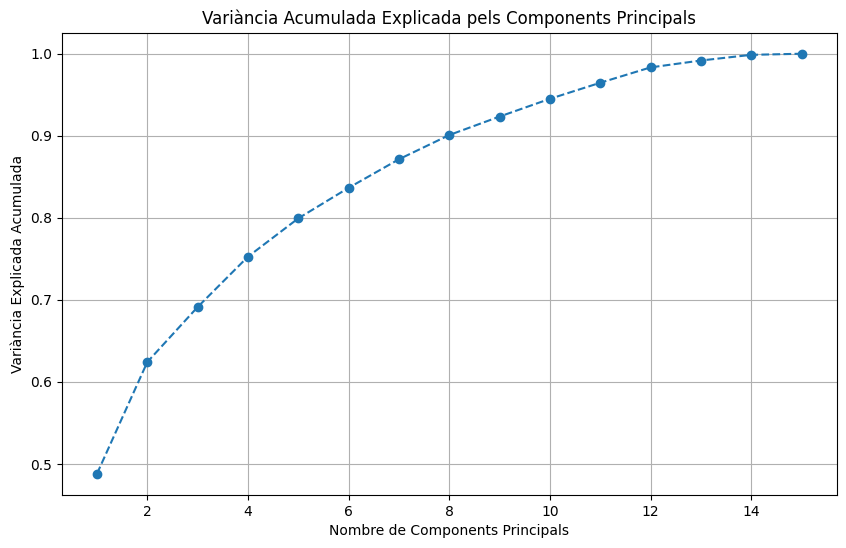


Càrregues (Loadings) dels Components Principals:
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
AAPL  -0.267907 -0.241984  0.028479 -0.014364 -0.111282  0.053153 -0.193048   
AMS   -0.064486 -0.040842  0.844078 -0.506879  0.011794 -0.125325  0.075254   
AMZN  -0.245975 -0.298208 -0.125179 -0.002491 -0.237426 -0.454489 -0.038710   
BBVA  -0.261562  0.402271 -0.049105 -0.088517 -0.080715  0.000482  0.057422   
GOOGL -0.281515 -0.223225 -0.056798  0.024203 -0.247169 -0.263164 -0.069716   
GSPC  -0.351495 -0.068621  0.044932  0.062908  0.031911  0.153941 -0.162975   
IBEX  -0.245525  0.394257 -0.037499 -0.022744  0.008302 -0.203124  0.132664   
IXIC  -0.348357 -0.181218 -0.019754 -0.014527 -0.006224  0.056101 -0.033844   
JPM   -0.272422  0.163336  0.082888  0.002332  0.102814  0.500518 -0.559264   
LLY   -0.156207 -0.069878  0.377615  0.717282  0.483910 -0.131212  0.125778   
MSFT  -0.299120 -0.209378  0.019718  0.070020 -0.147718  0.004153 -0.016036   
NV

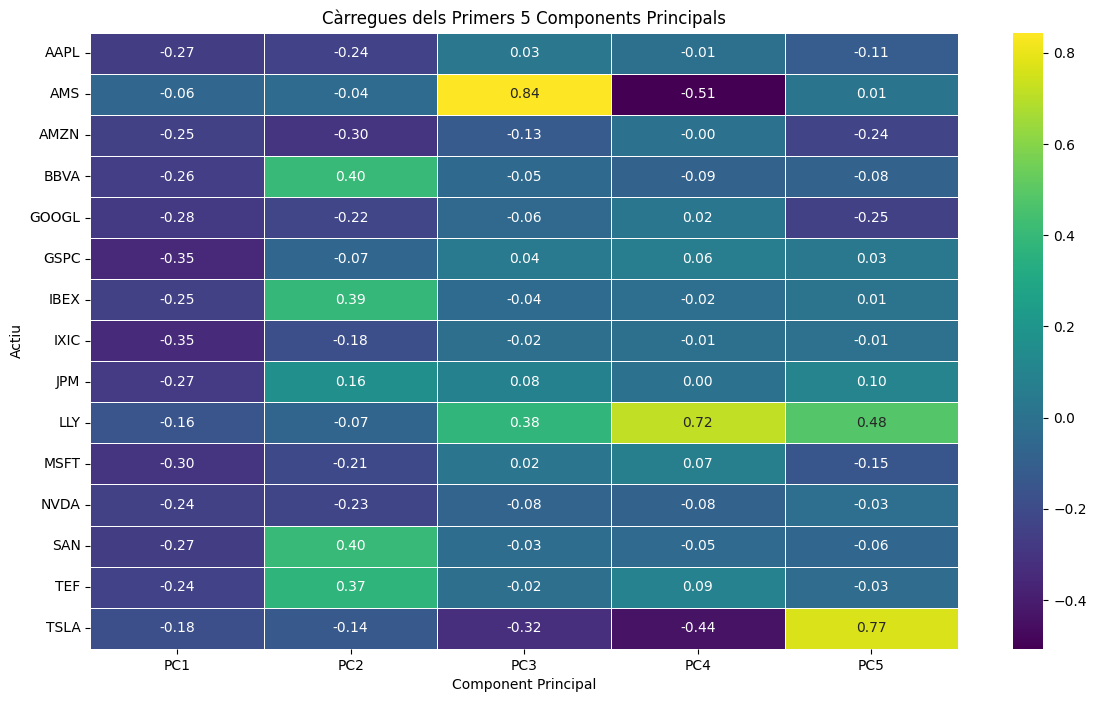


Primeres 5 files de les dades transformades en 2 Components Principals:
          PC1       PC2
149 -5.259491  2.416863
150  0.174173  0.151827
151 -1.049154 -1.461184
152  0.473693  0.680874
153  1.458466 -0.712322


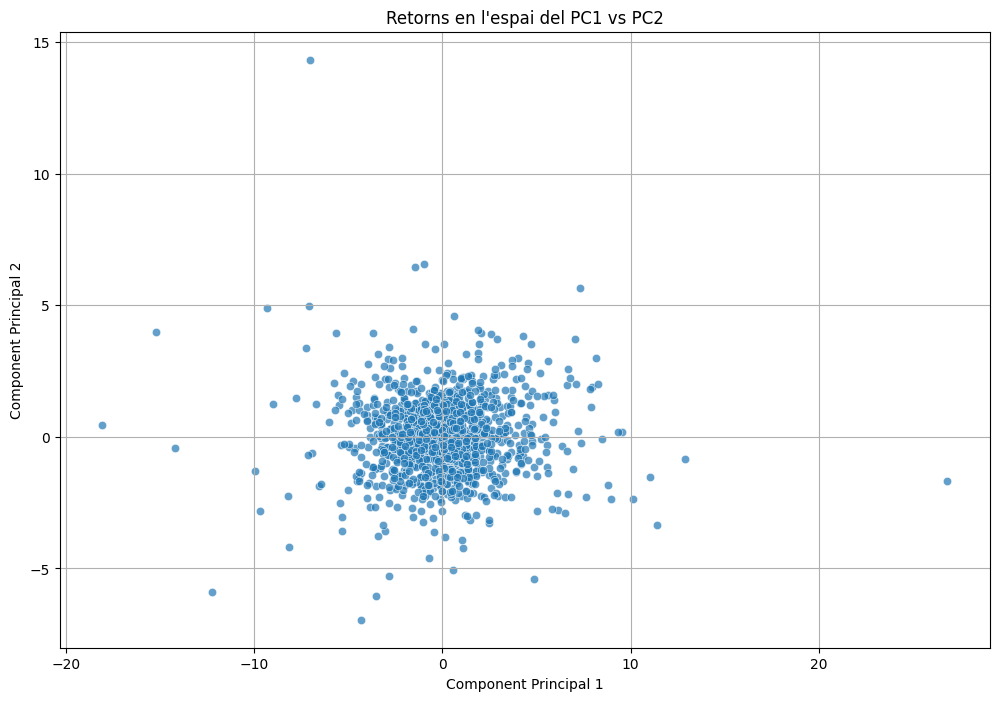


--- Anàlisi de Components Principals (PCA) finalitzada ---


In [13]:


warnings.filterwarnings("ignore")

print("\n--- Iniciant anàlisi de Components Principals (PCA) dels retorns ---")


if not df_clean_dict or not assets_valids:
    print("Error: df_clean_dict o assets_valids no estan definits o estan buits.")
    print("Assegura't que les cel·les anteriors del notebook s'han executat correctament.")
else:
    # 1. Consolidar els Retorns en un únic DataFrame
    all_returns_pca = pd.DataFrame()
    
    for asset in assets_valids:
        returns_col_name = f'{asset}_return'
        if returns_col_name in df_clean_dict[asset].columns:
            all_returns_pca = pd.concat([all_returns_pca, df_clean_dict[asset][returns_col_name].rename(asset)], axis=1)
        else:
            print(f"AVÍS: La columna '{returns_col_name}' no es troba per a l'actiu {asset}. Saltant {asset}.")

    # Eliminar files amb valors NaN que puguin sorgir de la fusió
    all_returns_pca.dropna(inplace=True)

    if all_returns_pca.empty:
        print("Error: No es van poder consolidar retorns vàlids per a l'anàlisi PCA. El DataFrame resultant està buit.")
    elif len(all_returns_pca.columns) < 2:
        print(f"Error: Es necessiten almenys 2 actius amb dades per realitzar PCA. Només es van trobar {len(all_returns_pca.columns)}.")
    else:
        print(f"\nRetorns consolidats per a PCA per a {len(all_returns_pca.columns)} actius. Mostra (primeres 5 files):")
        print(all_returns_pca.head())

        # 2. Escalar les Dades
        # És crucial escalar les dades per a PCA, ja que és sensible a l'escala.
        # Aquí escalem cada columna (retorn de cada actiu) a mitjana 0 i desviació estàndard 1.
        scaler_pca = StandardScaler()
        returns_scaled = scaler_pca.fit_transform(all_returns_pca)
        returns_scaled_df = pd.DataFrame(returns_scaled, columns=all_returns_pca.columns, index=all_returns_pca.index)

        print("\nRetorns escalats (primeres 5 files):")
        print(returns_scaled_df.head())

        # 3. Aplicar PCA
        # n_components=None per retenir tots els components i veure quanta variància explica cadascun
        pca = PCA(n_components=None) 
        pca.fit(returns_scaled_df)

        # 4. Analitzar la Variança Explicada
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance_ratio)

        print(f"\nVariància explicada per cada component principal:")
        for i, var in enumerate(explained_variance_ratio):
            print(f"  PC {i+1}: {var:.4f} ({cumulative_explained_variance[i]:.4f} acumulada)")

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
        plt.title('Variància Acumulada Explicada pels Components Principals')
        plt.xlabel('Nombre de Components Principals')
        plt.ylabel('Variància Explicada Acumulada')
        plt.grid(True)
        plt.show()

        # 5. Interpretar els Components (Loadings)
        # Els 'loadings' són els pesos de cada variable original en cada component principal.
        # Ajuda a entendre quines característiques (actius) contribueixen més a cada PC.
        loadings_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=all_returns_pca.columns)
        
        print("\nCàrregues (Loadings) dels Components Principals:")
        print(loadings_df)

        # Visualitzar les càrregues dels primers components (els que expliquen més variància)
        # Podem seleccionar els primers 3 o 4 components per a la visualització, ja que solen ser els més importants
        num_components_to_plot = min(5, pca.n_components_) # Limitem la visualització a un màxim de 5 components
        if num_components_to_plot > 0:
            plt.figure(figsize=(14, 8))
            sns.heatmap(loadings_df.iloc[:, :num_components_to_plot], annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
            plt.title(f'Càrregues dels Primers {num_components_to_plot} Components Principals')
            plt.xlabel('Component Principal')
            plt.ylabel('Actiu')
            plt.show()

        # 6. Transformar les dades i veure els components principals
        # Si vols utilitzar els components principals com a noves característiques per a un model,
        # pots decidir quants components retenir en funció de la variància explicada acumulada.
        # Per a la visualització, normalment es projecta a 2 o 3 dimensions.
        n_components_to_visualize = min(2, pca.n_components_) # Limitem a 2 per a un gràfic 2D

        if n_components_to_visualize > 0:
            pca_transformed_data = pca.transform(returns_scaled_df)[:, :n_components_to_visualize]
            pca_transformed_df = pd.DataFrame(pca_transformed_data, columns=[f'PC{i+1}' for i in range(n_components_to_visualize)], index=all_returns_pca.index)
            
            print(f"\nPrimeres 5 files de les dades transformades en {n_components_to_visualize} Components Principals:")
            print(pca_transformed_df.head())

            if n_components_to_visualize >= 2:
                plt.figure(figsize=(12, 8))
                sns.scatterplot(x='PC1', y='PC2', data=pca_transformed_df, alpha=0.7)
                plt.title('Retorns en l\'espai del PC1 vs PC2')
                plt.xlabel('Component Principal 1')
                plt.ylabel('Component Principal 2')
                plt.grid(True)
                plt.show()
            else:
                print(f"Només un component principal generat. No es pot fer gràfic 2D de PC1 vs PC2.")
        else:
            print("No es van generar components principals per visualitzar.")

print("\n--- Anàlisi de Components Principals (PCA) finalitzada ---")